# Chapter 1: The Baseline (LOS Calibration)
- Goal: Prove the hardware is stable.
- Visuals: Overlay all 20 samples from Channel 1 (LOS) on top of each other. They should look like a single thick line.
- Metric: Show that the FP_Index (First Path) always hits the same spot (e.g., ~746).

DEBUG: Calibration data: dataset\calibrations
DEBUG: Channel data:     dataset\channels

✅ SUCCESS: Found the data folder! Starting analysis...
---------------------------------------------------------------------------
CHANNEL    | SAMPLES    | AVG START INDEX      | STABILITY      
---------------------------------------------------------------------------
CH 1       | 20         | 746                  | +/- 2.40
CH 2       | 20         | 746                  | +/- 2.37
CH 3       | 20         | 746                  | +/- 2.51
CH 4       | 20         | 746                  | +/- 2.38
CH 5       | 20         | 746                  | +/- 2.63
CH 7       | 20         | 746                  | +/- 2.65


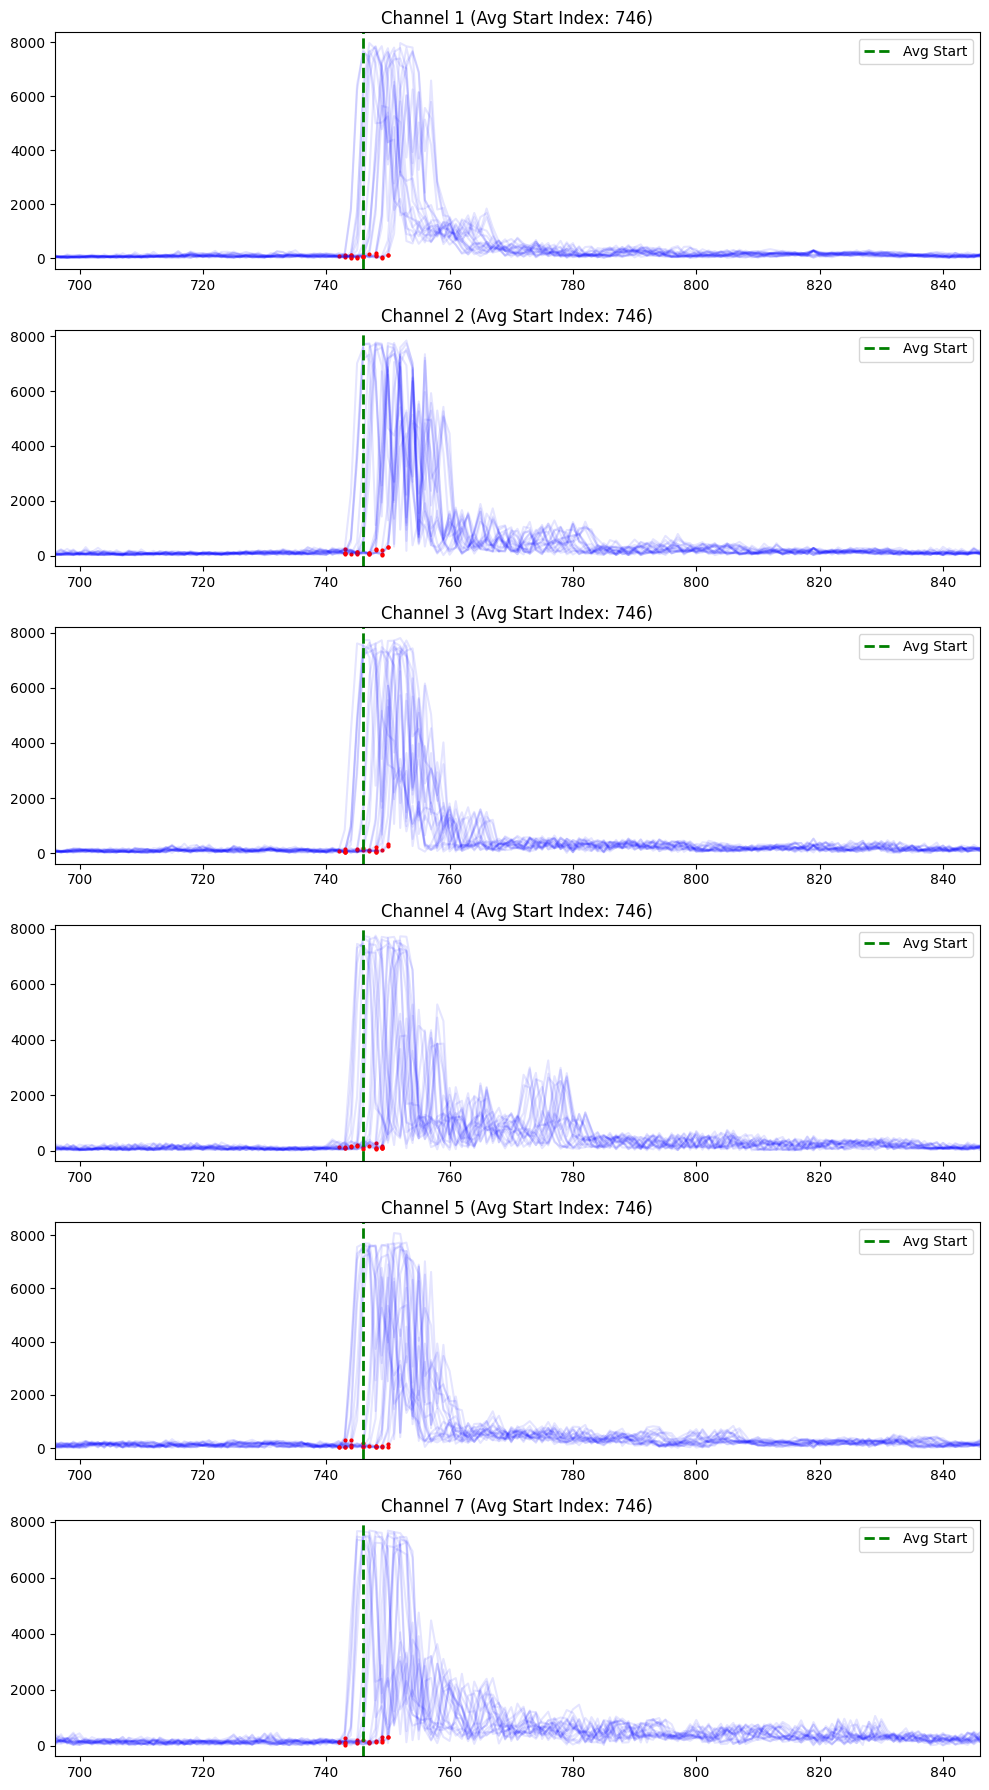

In [16]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. PATH CONFIGURATION
# ==========================================
# Base data directories (relative to notebook location in capstone/)
CALIBRATION_DIR = os.path.join('dataset', 'calibrations')
CHANNEL_DIR = os.path.join('dataset', 'channels')

DATA_DIR = CALIBRATION_DIR

print(f"DEBUG: Calibration data: {DATA_DIR}")
print(f"DEBUG: Channel data:     {CHANNEL_DIR}")

if not os.path.exists(DATA_DIR):
    print(f"\n❌ CRITICAL ERROR: Folder not found at {DATA_DIR}")
    if os.path.exists('dataset'):
        print(f"Contents of dataset/: {os.listdir('dataset')}")
else:
    print("\n✅ SUCCESS: Found the data folder! Starting analysis...")

# ==========================================
# 2. ANALYSIS LOGIC
# ==========================================
CHANNELS = [1, 2, 3, 4, 5, 7]
NOISE_THRESHOLD_SIGMA = 3.0 

def parse_cir_file(filepath):
    cir_samples = []
    if not os.path.exists(filepath):
        print(f"   -> Missing file: {os.path.basename(filepath)}")
        return []

    with open(filepath, 'r') as f:
        header = f.readline() 
        for line in f:
            line = line.strip()
            if not line or len(line) < 10: continue 
            
            parts = line.split(',')
            try:
                # CIR data starts from column 9 onwards
                cir_data = [int(x) for x in parts[9:] if x.lstrip('-').isdigit()]
                if len(cir_data) > 100:
                    cir_samples.append(cir_data)
            except ValueError:
                continue 
    return cir_samples

def detect_first_path(cir_data):
    """ Finds the First Path index (corresponds to TOA) """
    cir = np.array(cir_data)
    if len(cir) == 0: return 0
    
    max_peak_idx = np.argmax(cir)
    
    noise_section = cir[:min(50, max_peak_idx)]
    if len(noise_section) == 0: return 0
    
    noise_mean = np.mean(noise_section)
    noise_std = np.std(noise_section)
    threshold = noise_mean + (NOISE_THRESHOLD_SIGMA * noise_std)
    
    first_path = max_peak_idx
    for i in range(max_peak_idx, 0, -1):
        if cir[i] < threshold:
            first_path = i
            break
    return first_path

# ==========================================
# 3. RUN AND PLOT
# ==========================================
print("-" * 75)
print(f"{'CHANNEL':<10} | {'SAMPLES':<10} | {'AVG START INDEX':<20} | {'STABILITY':<15}")
print("-" * 75)

fig, axes = plt.subplots(len(CHANNELS), 1, figsize=(10, 18))
if len(CHANNELS) == 1: axes = [axes]

for i, ch in enumerate(CHANNELS):
    filename = f"2m_loscalibration_c{ch}.csv"
    filepath = os.path.join(DATA_DIR, filename)
    
    samples = parse_cir_file(filepath)
    ax = axes[i]
    start_indices = []
    
    if len(samples) > 0:
        for cir_wave in samples:
            fp_idx = detect_first_path(cir_wave)
            start_indices.append(fp_idx)
            
            ax.plot(cir_wave, color='blue', alpha=0.1)
            ax.plot(fp_idx, cir_wave[fp_idx], 'r.', markersize=4)
        
        avg_start = int(np.mean(start_indices))
        std_dev = np.std(start_indices)
        
        print(f"CH {ch:<7} | {len(samples):<10} | {avg_start:<20} | +/- {std_dev:.2f}")
        
        ax.set_title(f"Channel {ch} (Avg Start Index: {avg_start})")
        ax.axvline(avg_start, color='green', linestyle='--', linewidth=2, label='Avg Start')
        ax.set_xlim(max(0, avg_start - 50), avg_start + 100)
        ax.legend(loc='upper right')
    else:
        print(f"CH {ch:<7} | 0          | N/A                  | N/A")
        ax.text(0.5, 0.5, f"File {filename} not found", ha='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

Analysis of Calibration Results & Methodology1. Verification of Signal Alignment (The "Green Line")Observation:Across all 20 calibration samples for every channel (1, 2, 3, 4, 5, 7), the First Path Index consistently appeared at Index ~746 (with a stability of $\pm$ 2.4 indices).Derivation Method:The "Start Index" was derived programmatically using a leading-edge detection algorithm:Peak Detection: Identified the maximum amplitude index in the raw Channel Impulse Response (CIR).Noise Floor Estimation: Calculated the mean ($\mu$) and standard deviation ($\sigma$) of the noise from the first 50 empty samples.Back-Search: Traversed backwards from the peak index until the signal amplitude dropped below the noise threshold ($\mu + 3\sigma$).Result: The index where the signal first rises above the noise floor is marked as the "First Path."Hardware Explanation:The consistency of Index 746 is intrinsic to the Decawave DW1000 chip. The chip utilizes a hardware Leading Edge Detection (LDE) algorithm which automatically time-shifts the received waveform within its accumulator memory. It aligns the leading edge of the pulse to a fixed internal reference (typically around index 740–750). This behavior confirms that the hardware is successfully and consistently locking onto the Line-of-Sight signal.Implication for Preprocessing:Since the signal start is deterministic and stable, we can implement Fixed Windowing for our Neural Network. We will standardly slice the input data from Index 740 to 890 (150 samples). This ensures the model always receives the complete pulse shape without the computational overhead of dynamic alignment.2. The Role of Antenna Delay CalibrationThe Paradox:If the CIR waveform shape (the Neural Network's input) remains identical regardless of software calibration, why is calibration necessary?The Solution:Calibration is required to correct the Label (Ground Truth), not the Input.The Input (CIR): The physical shape of the waveform is determined by physics (walls, obstacles, reflections). Changing the ANT_DLY register in software does not alter the physical wave flying through the air.The Label (Distance Error): The Neural Network is trained to predict the ranging error caused by NLOS conditions. The ground truth error is calculated as:$$\text{Error} = \text{Measured Distance} - \text{True Distance}$$Conclusion:Without calibration, the hardware introduces a static offset (e.g., reading 2.60m for a 2.00m path). This would force the AI to learn that a "perfect" Line-of-Sight signal corresponds to a large error (e.g., +0.60m), which is false.By calibrating the antenna delay, we ensure that Clean LOS Signal $\approx$ 0.00m Error. This effectively "zeroes the scale," ensuring that any error the Neural Network learns to predict is purely generated by environmental factors (NLOS) and not hardware bias.

# Chapter 2: The Multi-Channel Fingerprint

- Goal: Show how different channels "see" the same room.
- Visuals: Plot the same LOS scenario across all 6 channels.
- Discovery: Higher channels (like 5 and 7) usually have sharper peaks but higher attenuation. This justifies why you are using multi-channel data for your Liquid Neural Network (LNN).
- In UWB systems, lower channels typically offer better penetration through obstacles, while higher channels provide better temporal resolution due to wider bandwidth. This "fingerprint" is what your model uses to distinguish between environmental effects and hardware characteristics.
- The Multi-Channel Fingerprint Storyline
Objective: Analyze the consistency of the pulse shape across different center frequencies under identical Line-of-Sight (LOS) conditions.

- Hypothesis: Higher channels (Channel 5/7) will exhibit sharper rising edges and higher Kurtosis, while lower channels (Channel 1/2) may show more "ringing" but better signal stability.

- LNN Relevance: The Tau Controller in your LNN needs to learn that a "fast" time constant on Channel 7 might look different than a "fast" time constant on Channel 1 due to these physical differences.

## 2.1 Multi-Channel Analysis

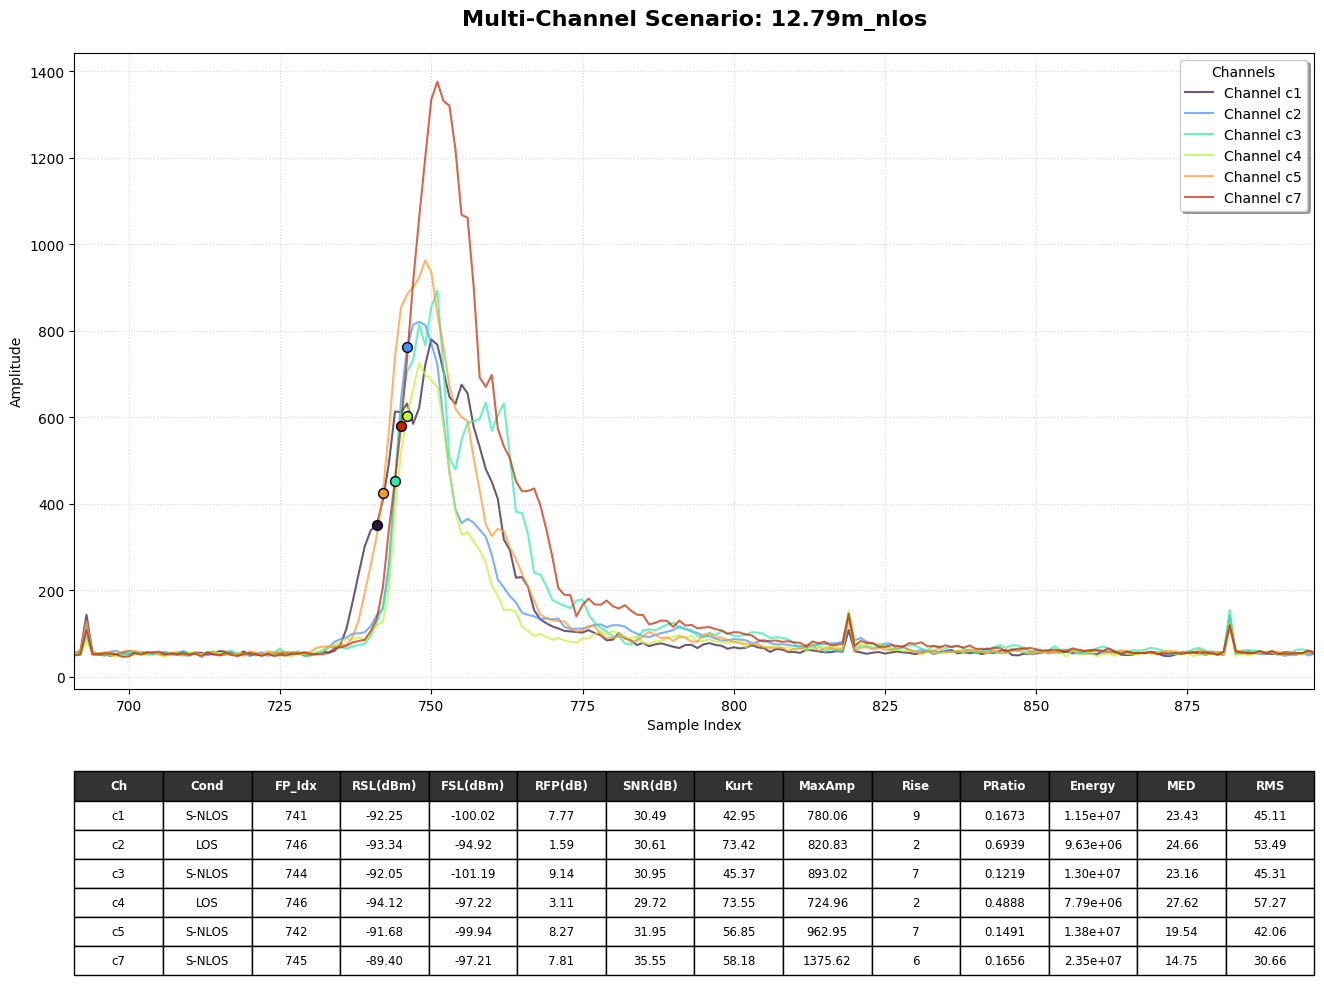

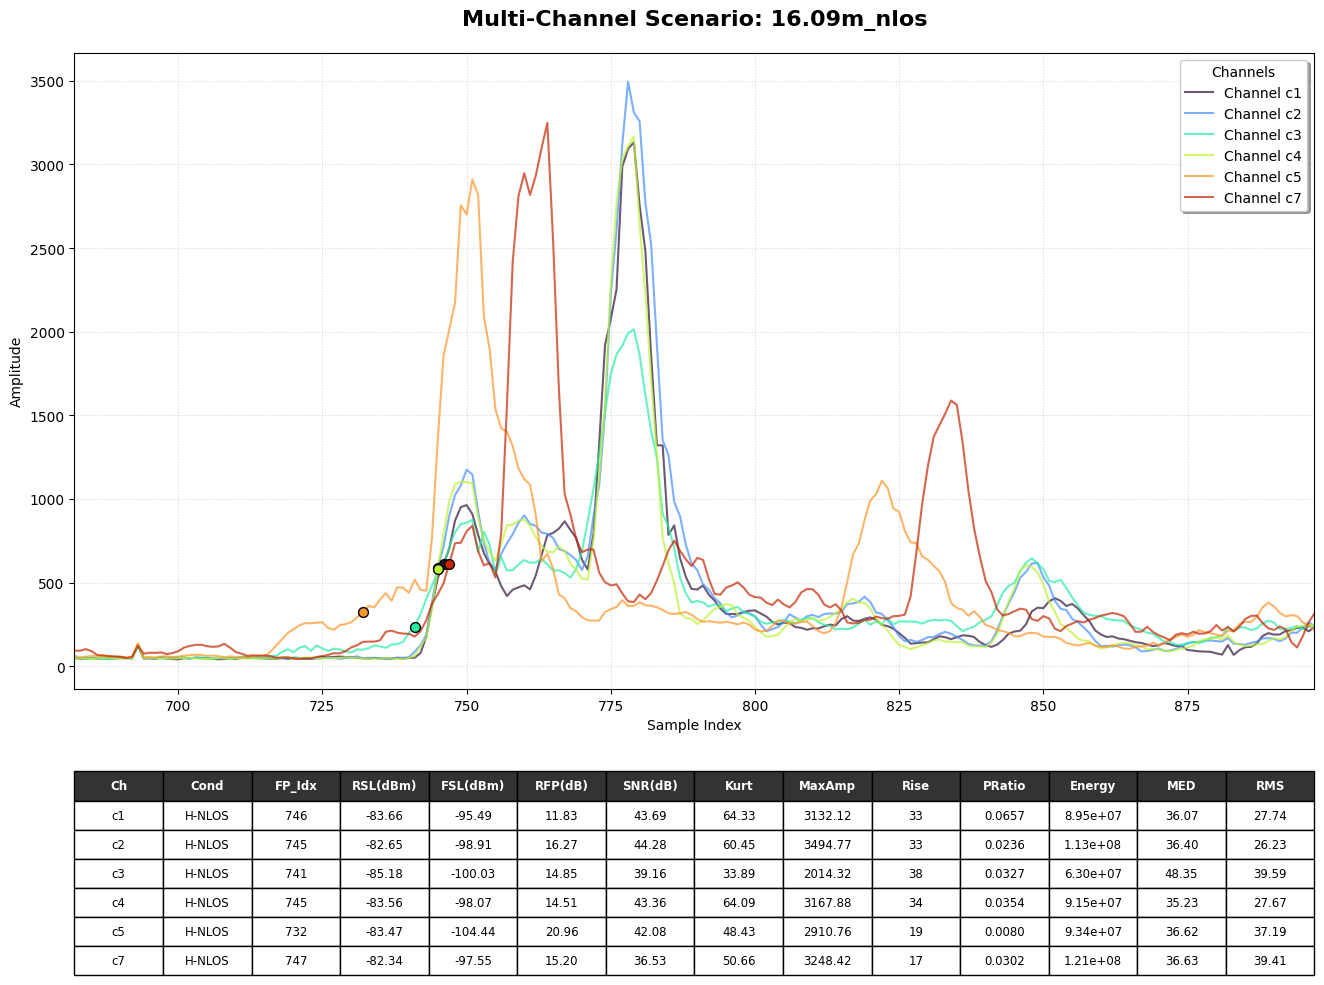

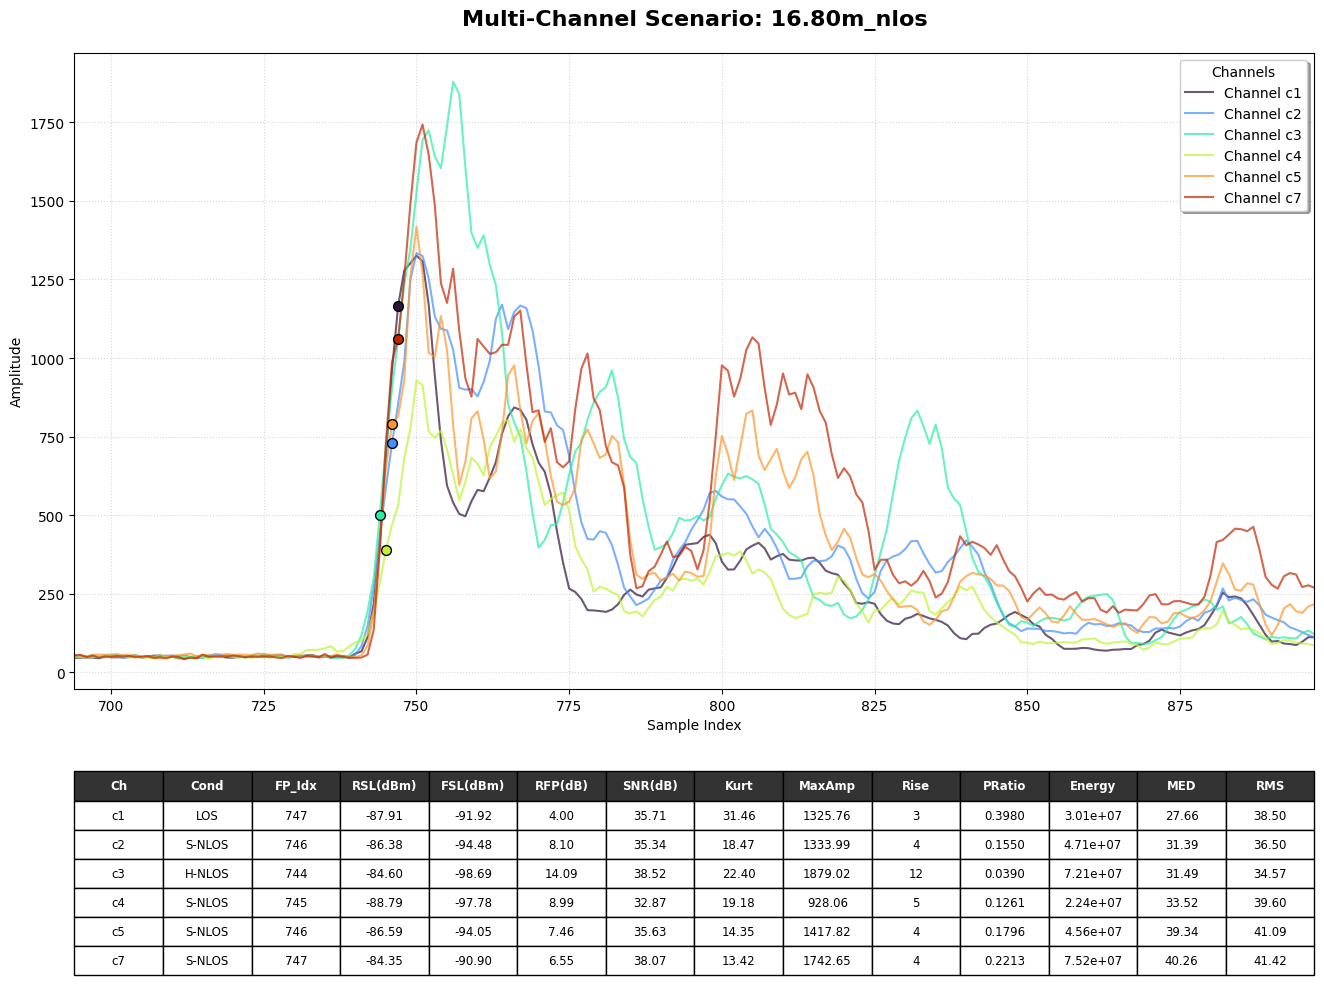

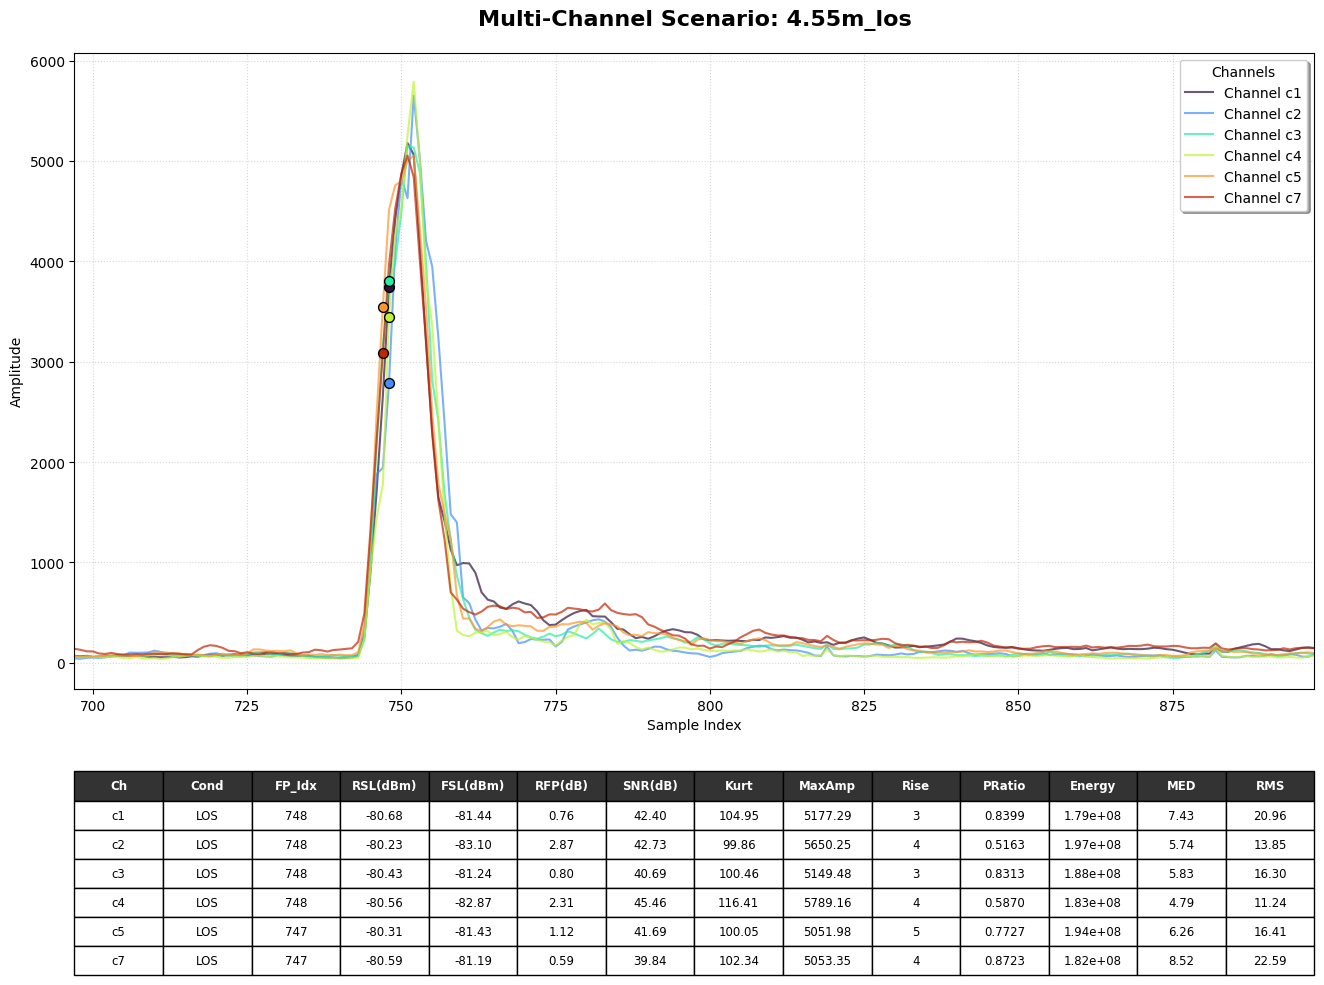

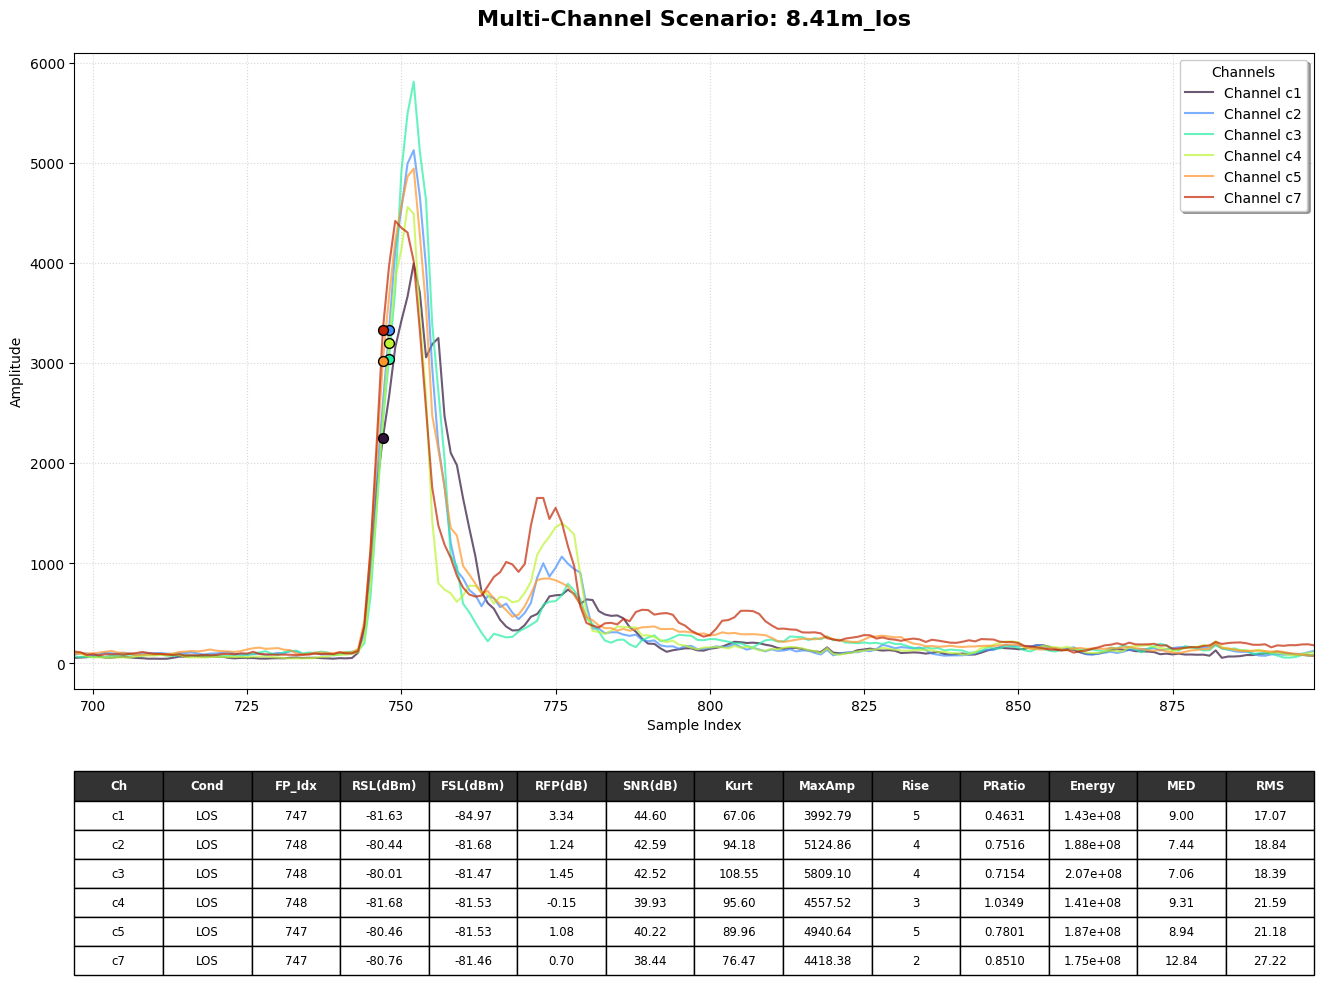

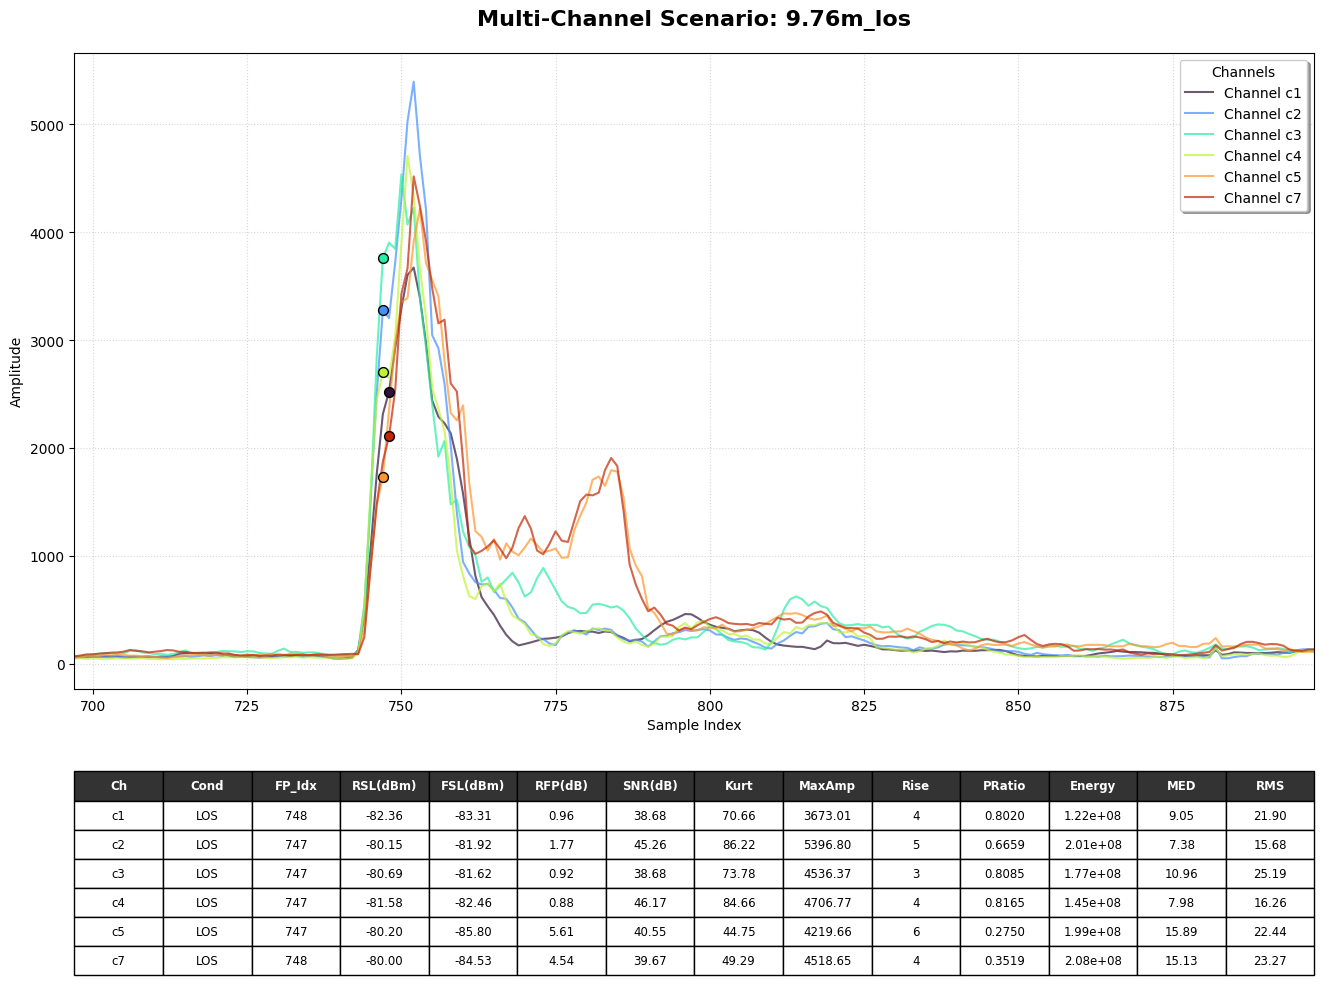

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
import glob
import re
import os

# ==========================================
# 1. METRIC CALCULATION
# ==========================================
def get_original_metrics(filepath):
    try:
        df = pd.read_csv(filepath)
        cir_cols = sorted([c for c in df.columns if c.startswith('CIR')], key=lambda x: int(x.replace('CIR', '')))
        if not cir_cols: return None 
        
        # --- WAVEFORM: MEAN OF ALL ROWS ---
        avg_wave = np.mean(df[cir_cols].values, axis=0)
        
        # --- Constants & Signal Strength ---
        A = 121.74 
        N = df['RXPACC'].mean() if 'RXPACC' in df.columns else (df['RXP_ACC'].mean() if 'RXP_ACC' in df.columns else 128.0)
        
        # RSL Logic & Total Energy
        total_energy = np.sum(avg_wave**2)
        C = df['CIR_PWR'].mean() if 'CIR_PWR' in df.columns else total_energy / (2**17) 
        RSL = 10 * np.log10( (max(C, 1e-9) * (2**17)) / (N**2) ) - A

        # FSL Logic (First Path)
        hw_fp_idx = int(df['FP_INDEX'].mean() / 64)
        if 'FP_AMPL1' in df.columns:
            f1, f2, f3 = df['FP_AMPL1'].mean(), df['FP_AMPL2'].mean(), df['FP_AMPL3'].mean()
        else:
            f1, f2, f3 = avg_wave[max(0, hw_fp_idx-1)], avg_wave[hw_fp_idx], avg_wave[min(len(avg_wave)-1, hw_fp_idx+1)]
        
        fp_energy = (f1**2 + f2**2 + f3**2)
        FSL = 10 * np.log10( max(fp_energy, 1e-9) / (N**2) ) - A
        RFP = RSL - FSL

        # --- Adjusted Thresholds for LOS Accuracy ---
        if RFP < 6.0: condition = "LOS"
        elif RFP <= 10.0: condition = "S-NLOS"
        else: condition = "H-NLOS"

        # --- Quality, Rise Time & Power Ratio ---
        max_amp = np.max(avg_wave)
        peak_idx = np.argmax(avg_wave)
        rise_time = peak_idx - hw_fp_idx
        power_ratio = fp_energy / max(total_energy, 1e-9)
        
        std_noise = df['STD_NOISE'].mean() if 'STD_NOISE' in df.columns else np.std(avg_wave[0:30])
        SNR = 20 * np.log10(max_amp / (std_noise + 1e-9))
        
        # --- Delay Analysis (Mean Excess Delay & RMS) ---
        pdp = avg_wave[hw_fp_idx:]**2
        pwr_sum = np.sum(pdp) + 1e-9
        mean_delay = np.sum(pdp * np.arange(len(pdp))) / pwr_sum
        rms_delay = np.sqrt(max(0, (np.sum(pdp * (np.arange(len(pdp))**2)) / pwr_sum) - (mean_delay**2)))

        return {
            "Ch": re.search(r'_(c\d+)\.csv', filepath).group(1),
            "Wave": avg_wave, "FP": hw_fp_idx, "Cond": condition,
            "RSL": f"{RSL:.2f}", "FSL": f"{FSL:.2f}", "RFP": f"{RFP:.2f}",
            "SNR": f"{SNR:.2f}", "Kurt": f"{kurtosis(avg_wave):.2f}",
            "MaxAmp": f"{max_amp:.2f}", "Rise": f"{rise_time}",
            "PRatio": f"{power_ratio:.4f}", "Energy": f"{total_energy:.2e}",
            "MED": f"{mean_delay:.2f}", "RMS": f"{rms_delay:.2f}"
        }
    except Exception: return None

def plot_overlay_with_table(scenario_prefix):
    files = sorted(glob.glob(f"{scenario_prefix}_c*.csv"), 
                   key=lambda x: int(re.search(r'_c(\d+)', x).group(1)))
    if not files: return

    results = [get_original_metrics(f) for f in files if get_original_metrics(f) is not None]
    
    fig, ax = plt.subplots(figsize=(16, 12))
    colors = plt.cm.turbo(np.linspace(0, 0.9, len(results)))
    
    for i, res in enumerate(results):
        ax.plot(res['Wave'], color=colors[i], label=f"Channel {res['Ch']}", lw=1.5, alpha=0.7)
        ax.scatter(res['FP'], res['Wave'][res['FP']], color=colors[i], s=50, edgecolors='black', zorder=5)

    ax.set_title(f"Multi-Channel Scenario: {os.path.basename(scenario_prefix)}", fontsize=16, fontweight='bold', pad=20)
    ax.set_ylabel("Amplitude")
    ax.set_xlabel("Sample Index")
    
    all_fps = [res['FP'] for res in results]
    ax.set_xlim(min(all_fps) - 50, max(all_fps) + 150)
    ax.grid(True, linestyle=':', alpha=0.5)
    ax.legend(loc='upper right', title="Channels", shadow=True)

    # --- TABLE HEADERS & ROWS (Including FP_Index) ---
    headers = ["Ch", "Cond", "FP_Idx", "RSL(dBm)", "FSL(dBm)", "RFP(dB)", "SNR(dB)", "Kurt", "MaxAmp", "Rise", "PRatio", "Energy", "MED", "RMS"]
    rows = [[r['Ch'], r['Cond'], r['FP'], r['RSL'], r['FSL'], r['RFP'], r['SNR'], r['Kurt'], 
             r['MaxAmp'], r['Rise'], r['PRatio'], r['Energy'], r['MED'], r['RMS']] for r in results]
    
    table = plt.table(cellText=rows, colLabels=headers, loc='bottom', cellLoc='center', bbox=[0, -0.45, 1, 0.32])
    table.auto_set_font_size(False)
    table.set_fontsize(8.5)
    
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#333333')

    plt.subplots_adjust(bottom=0.35)
    plt.show()

# Execution — search in dataset/channel/
all_csvs = glob.glob(os.path.join(CHANNEL_DIR, "*.csv"))
unique_scenarios = sorted(list(set([re.sub(r'_c\d+\.csv$', '', f) for f in all_csvs if "_c" in f])))
for s in unique_scenarios:
    plot_overlay_with_table(s)

## 2.2 Individual Analysis

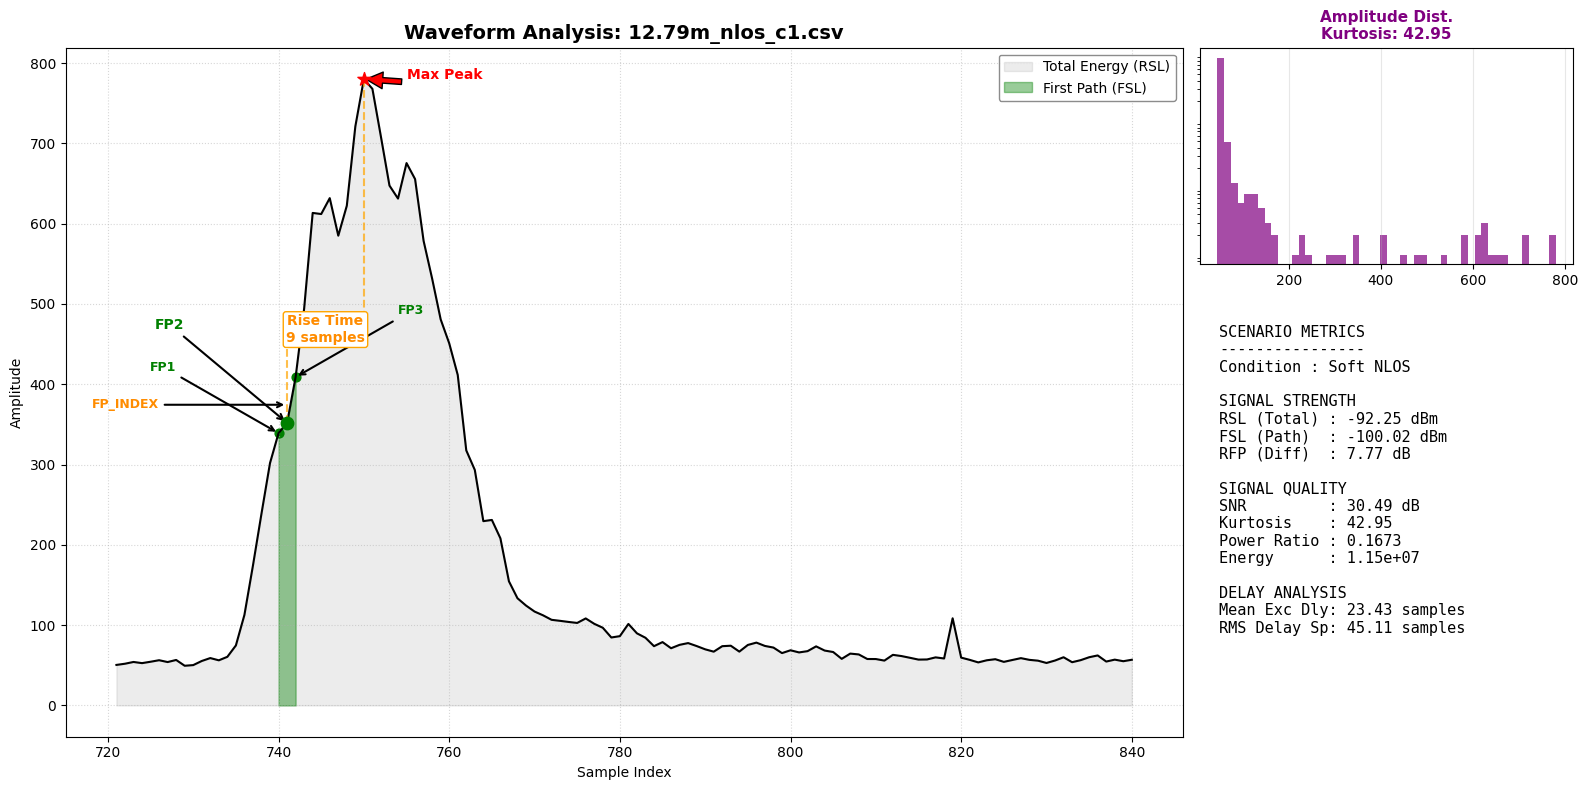

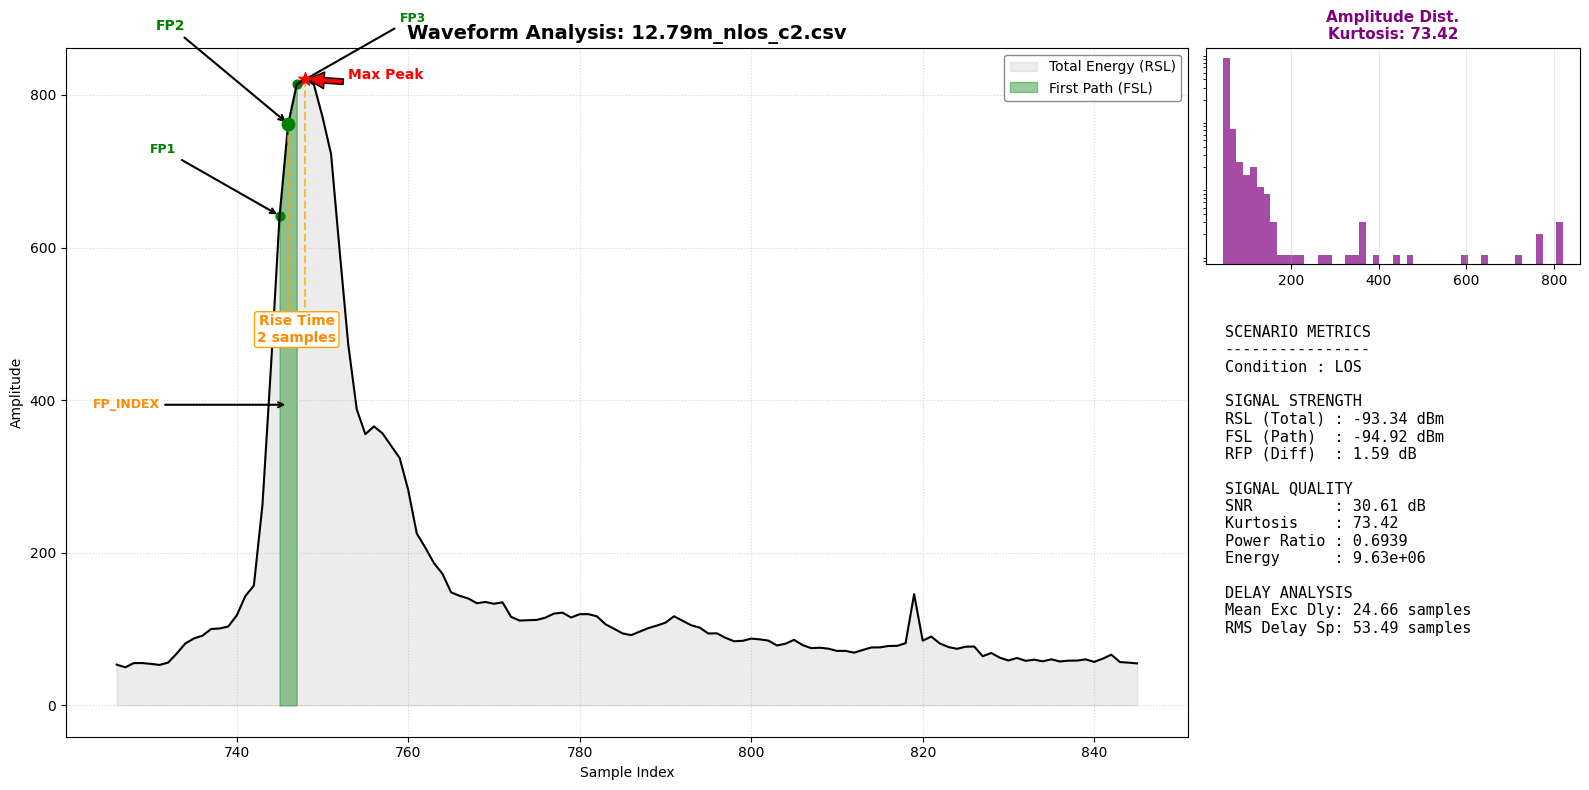

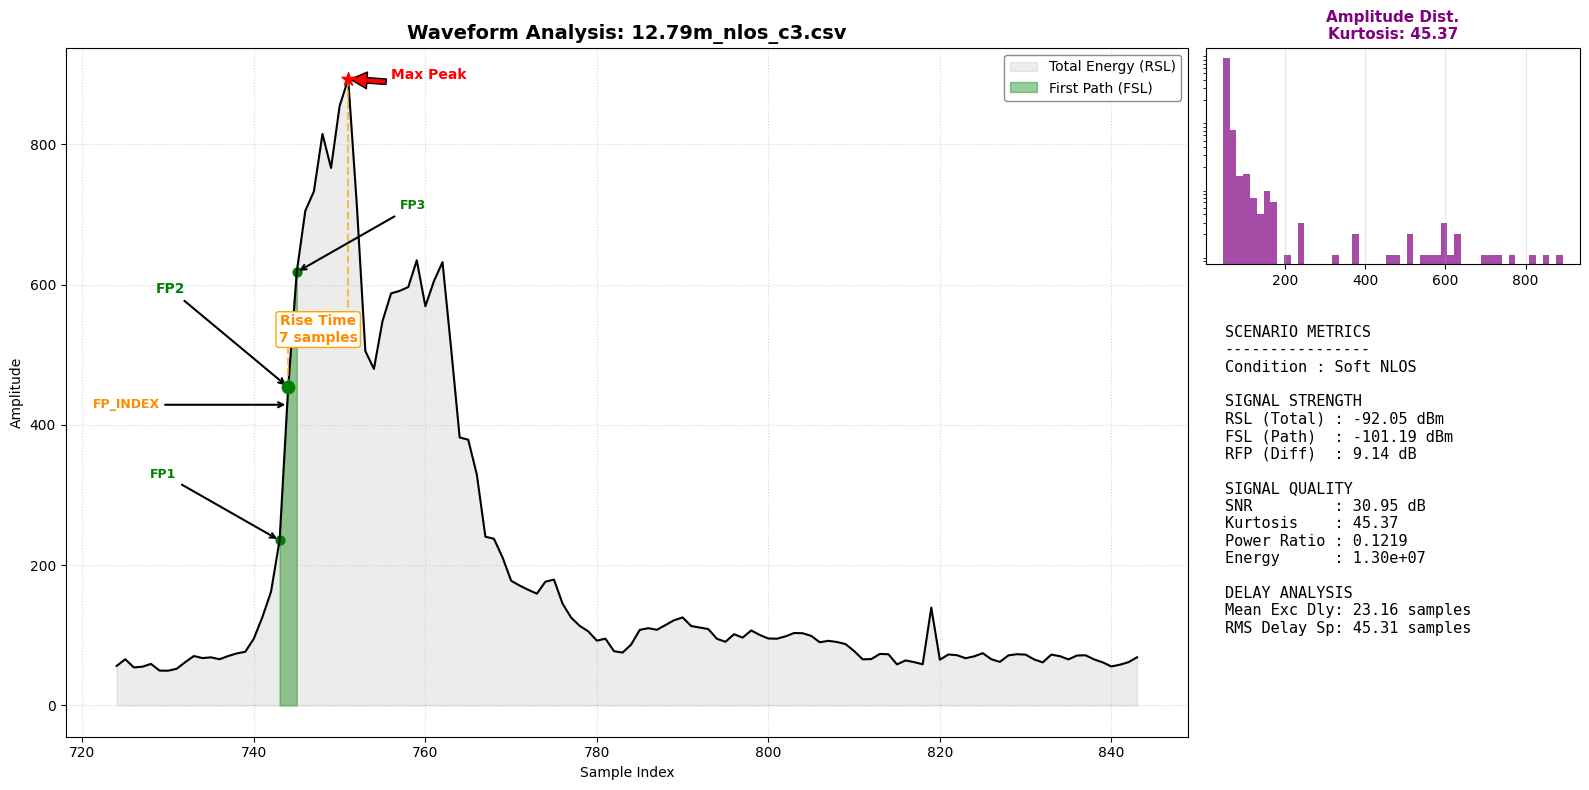

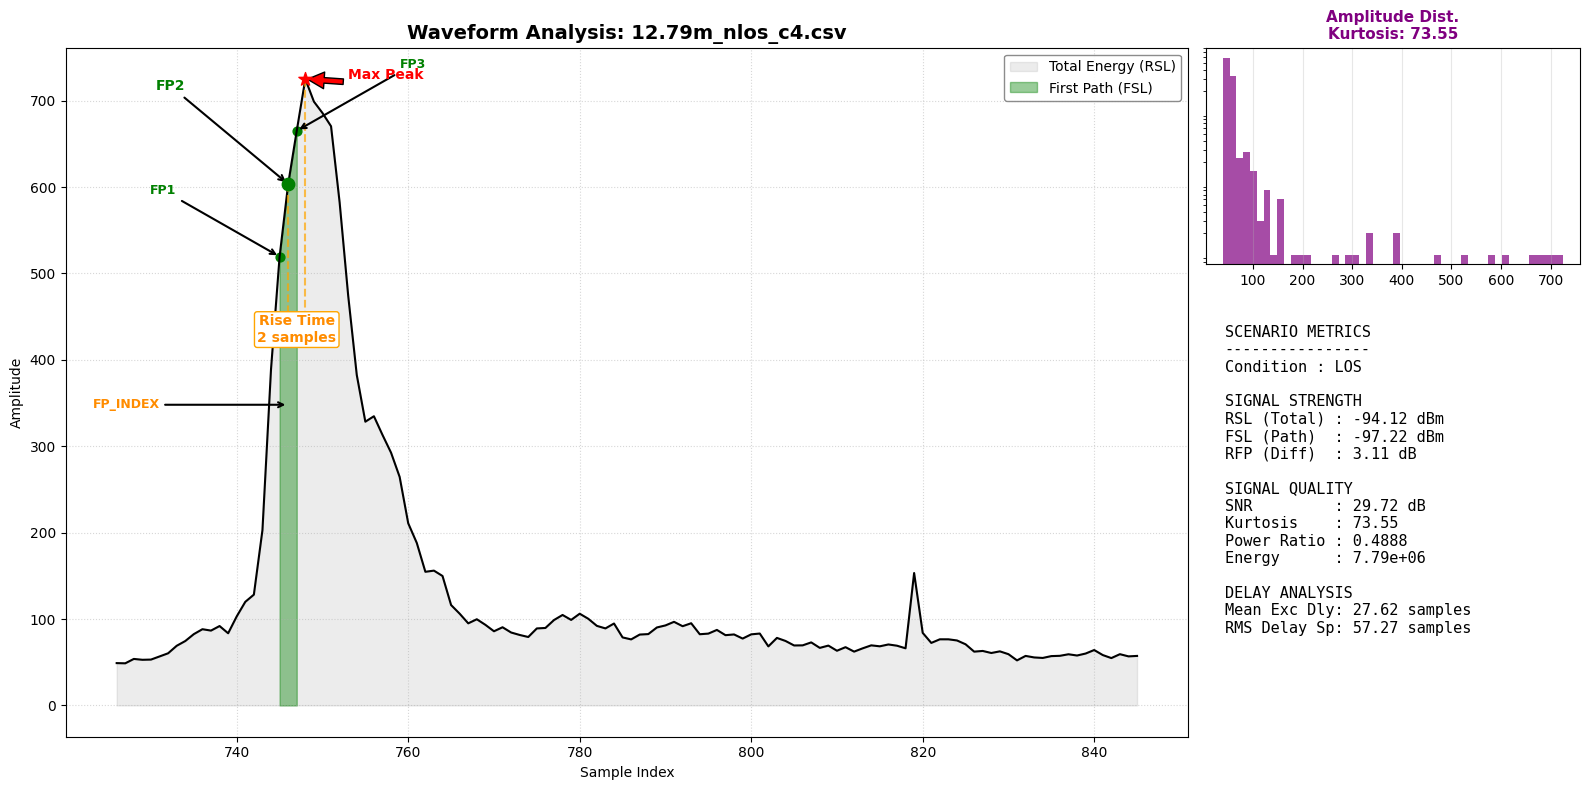

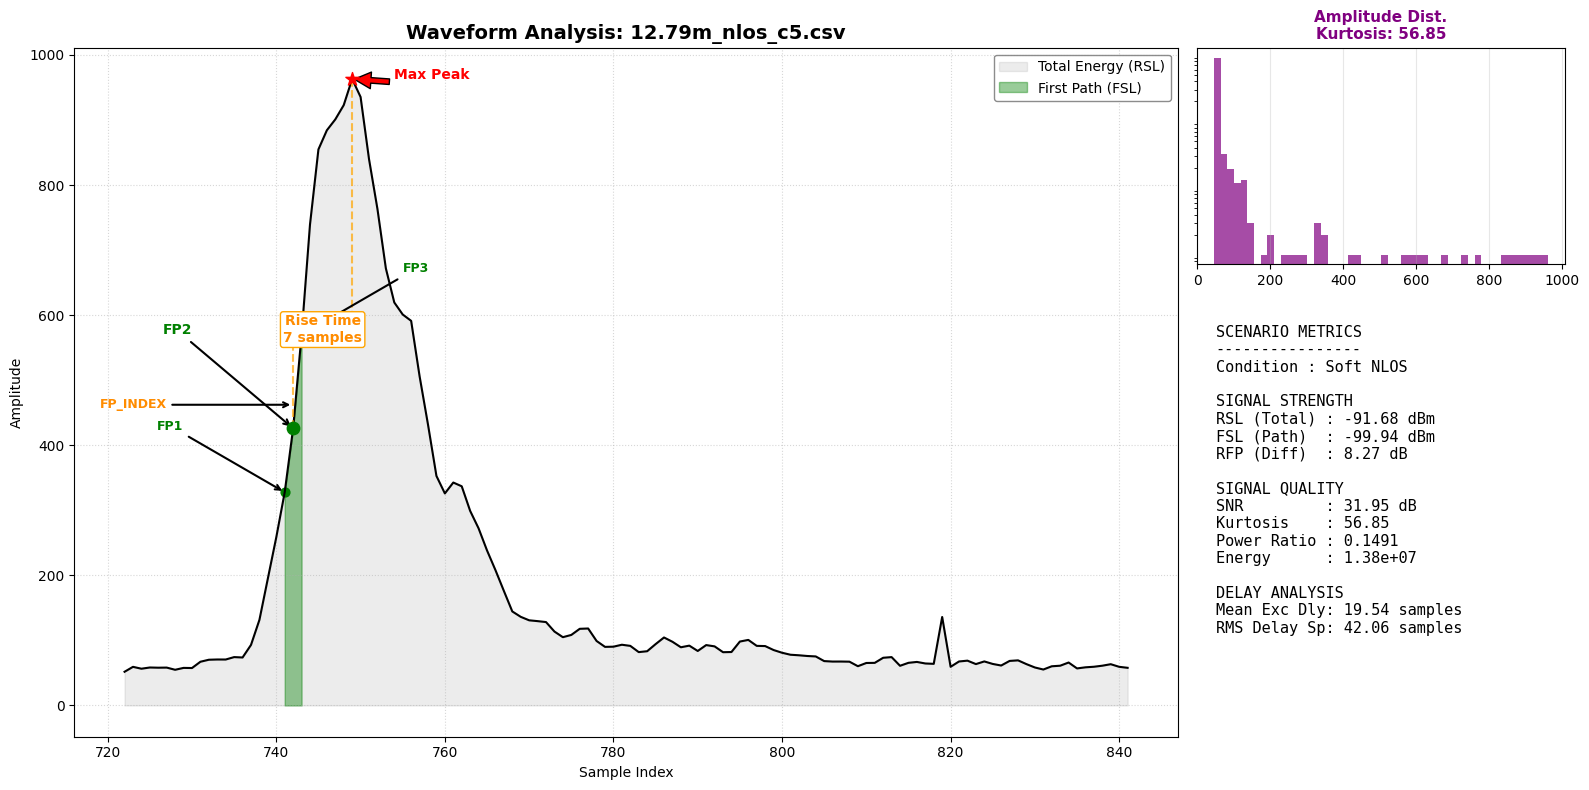

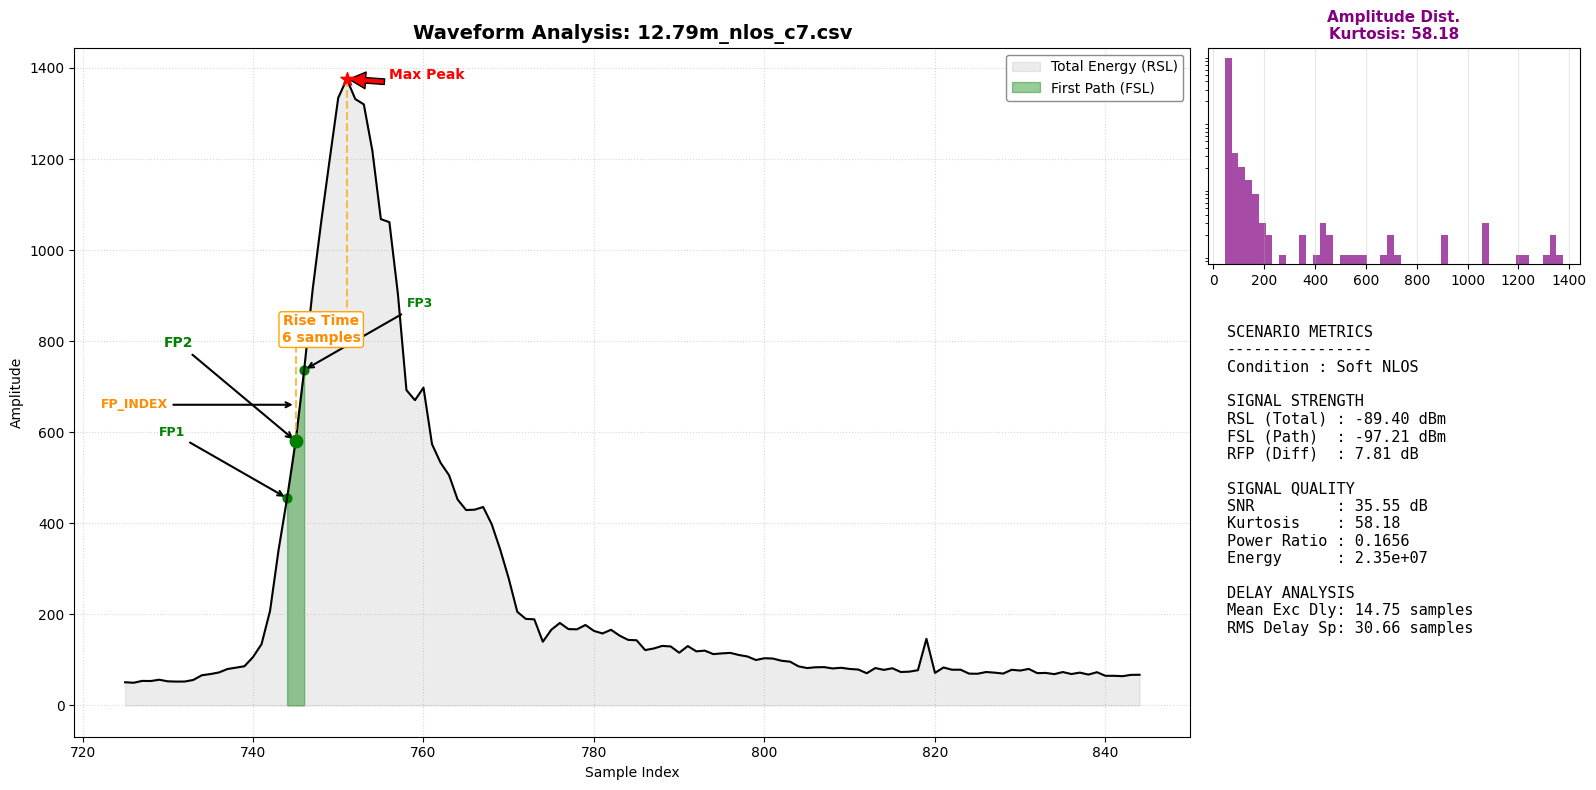

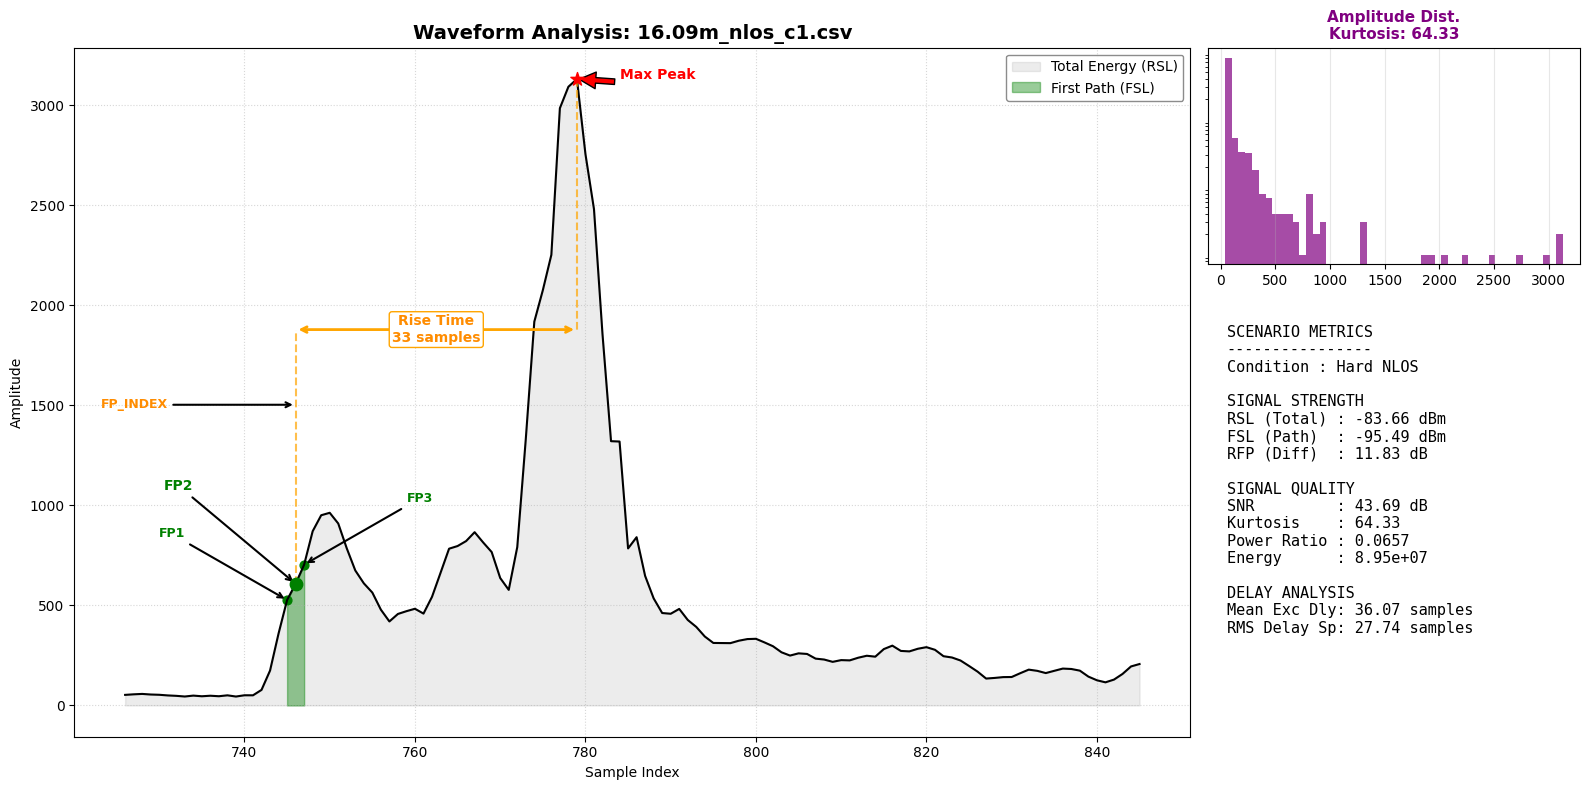

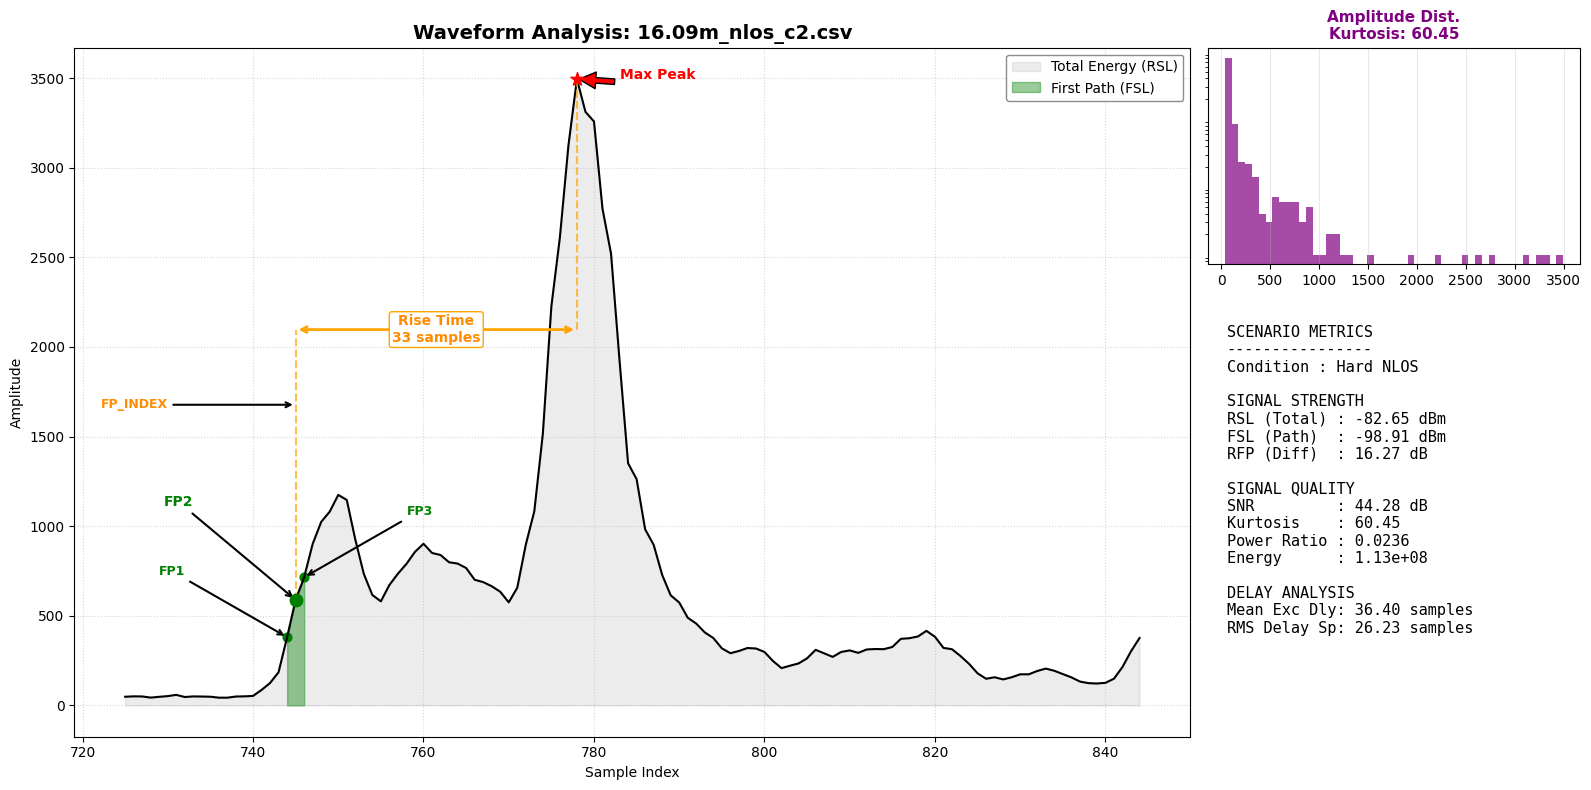

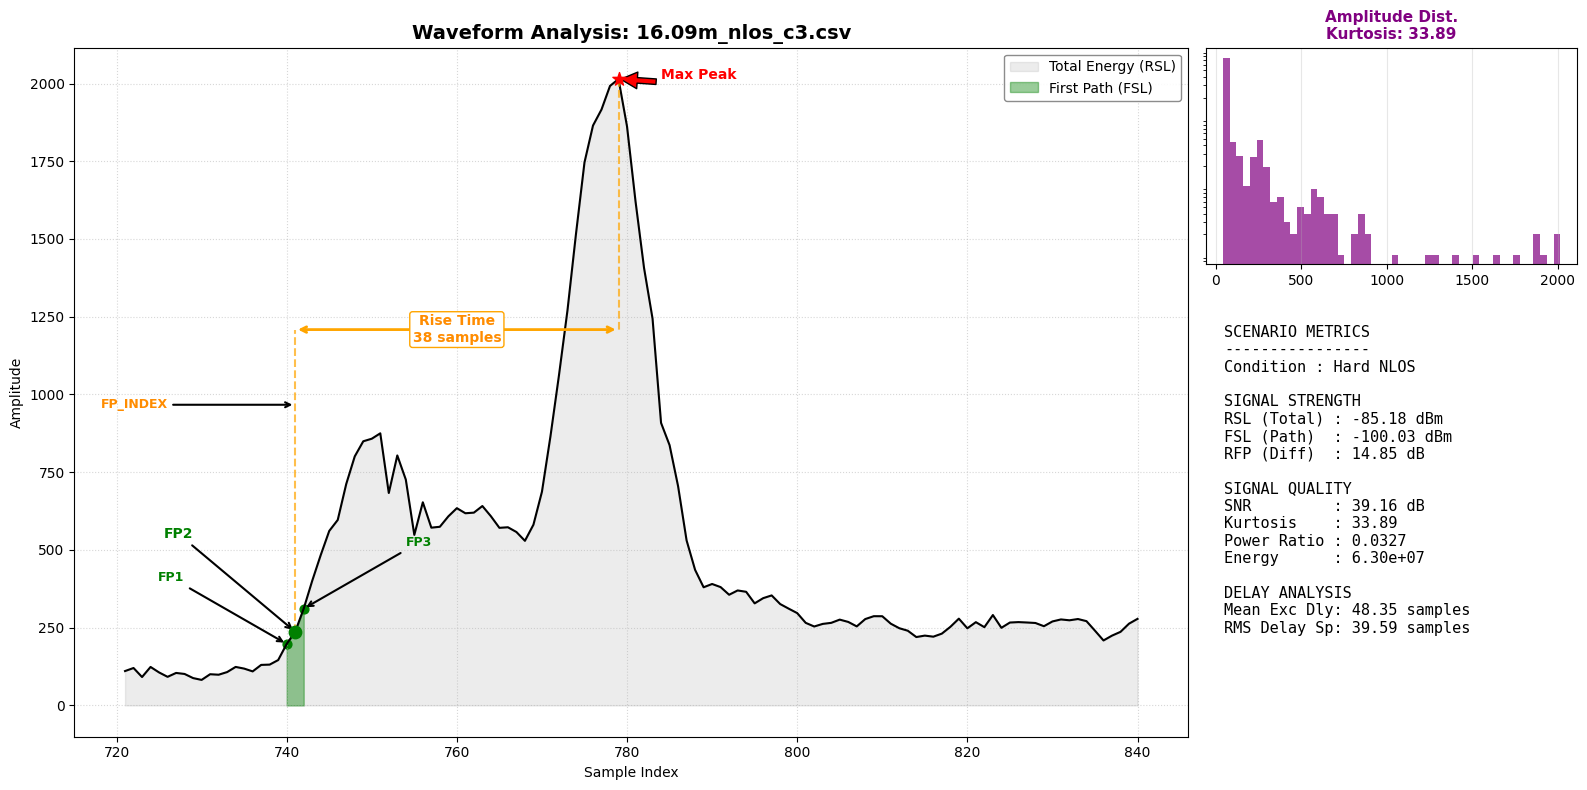

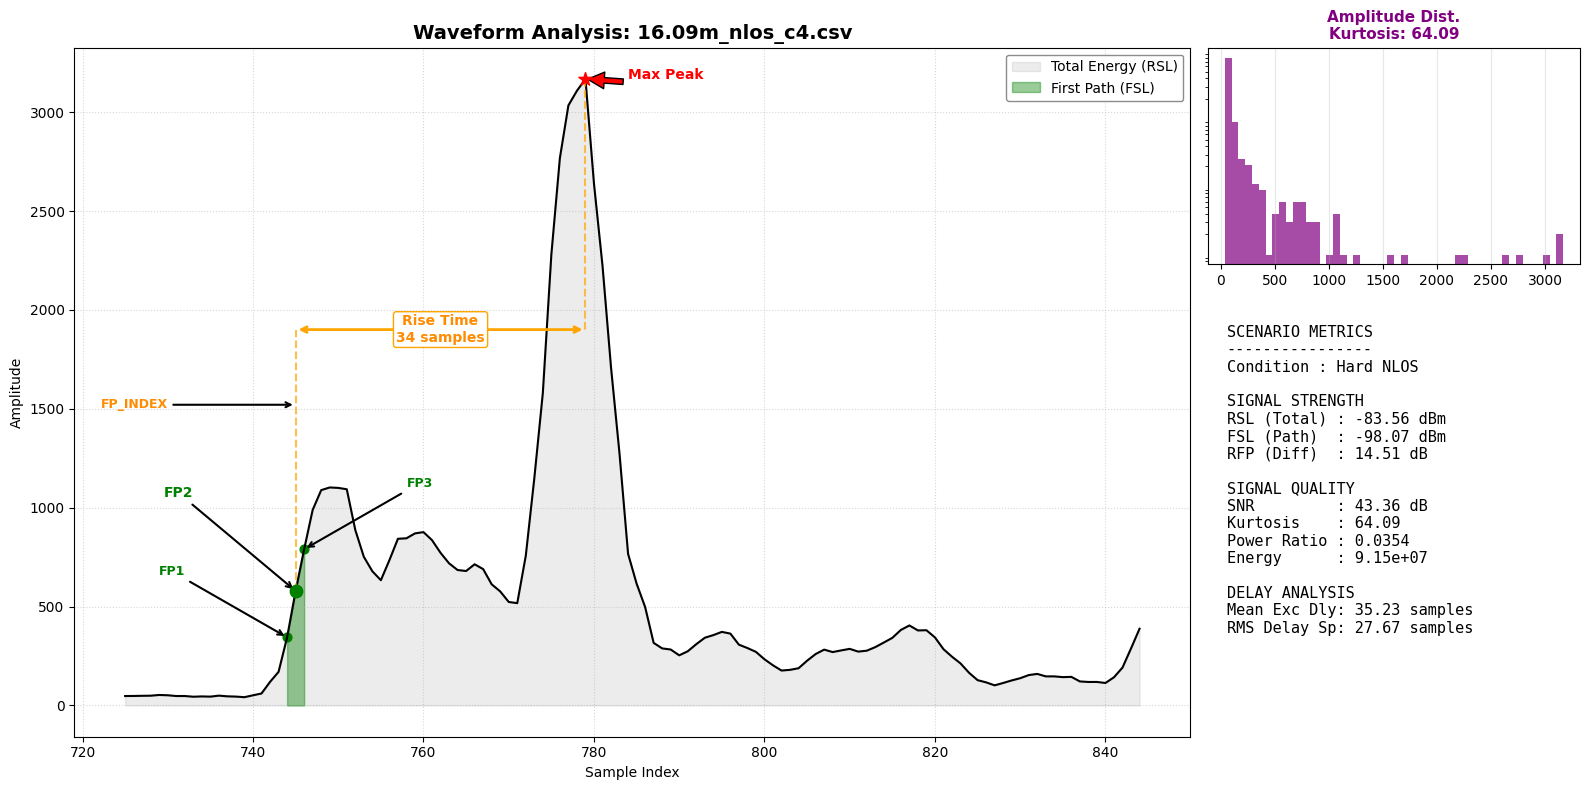

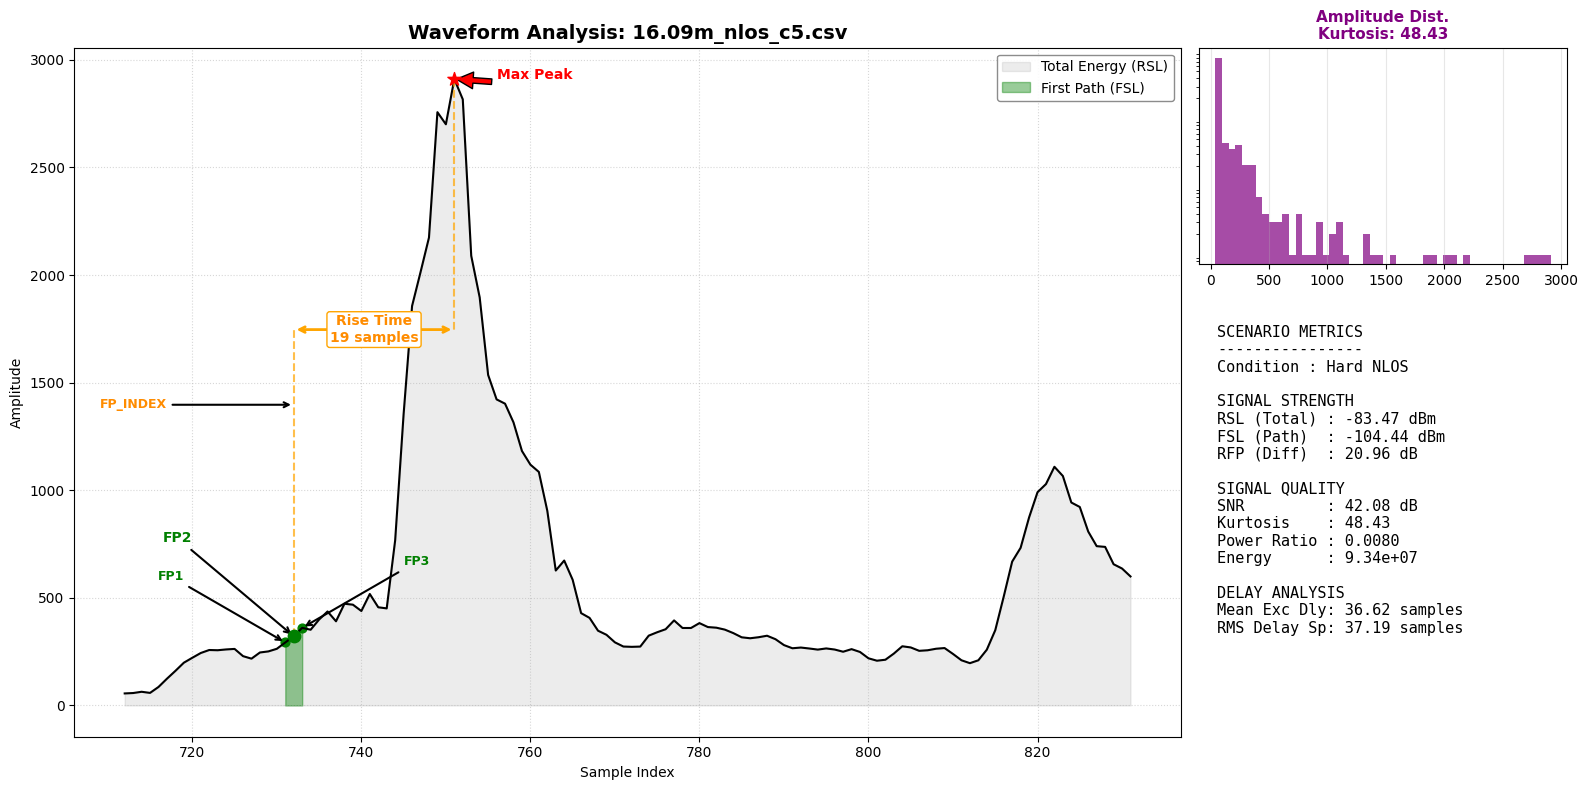

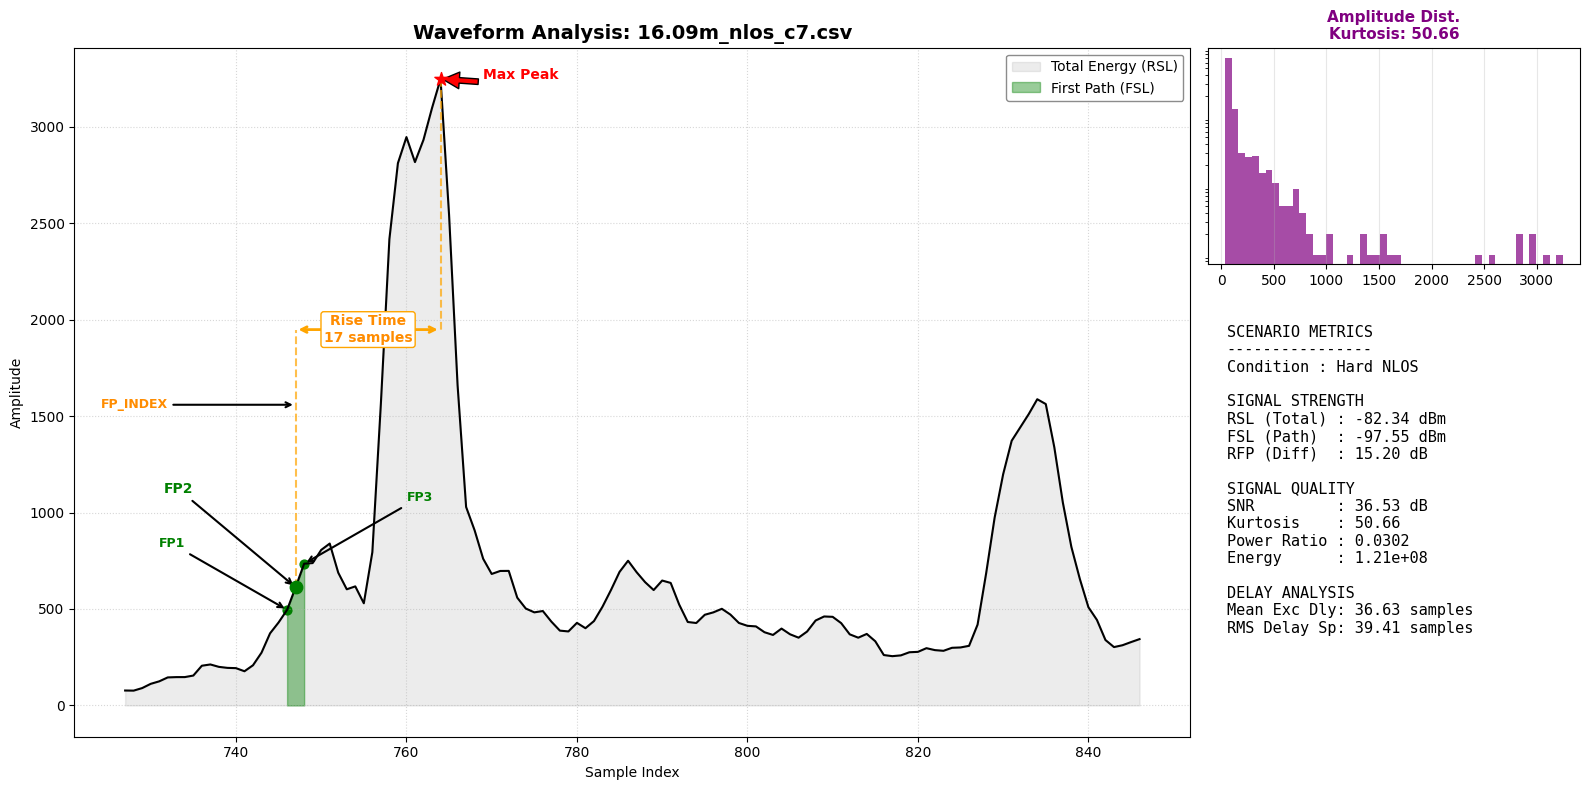

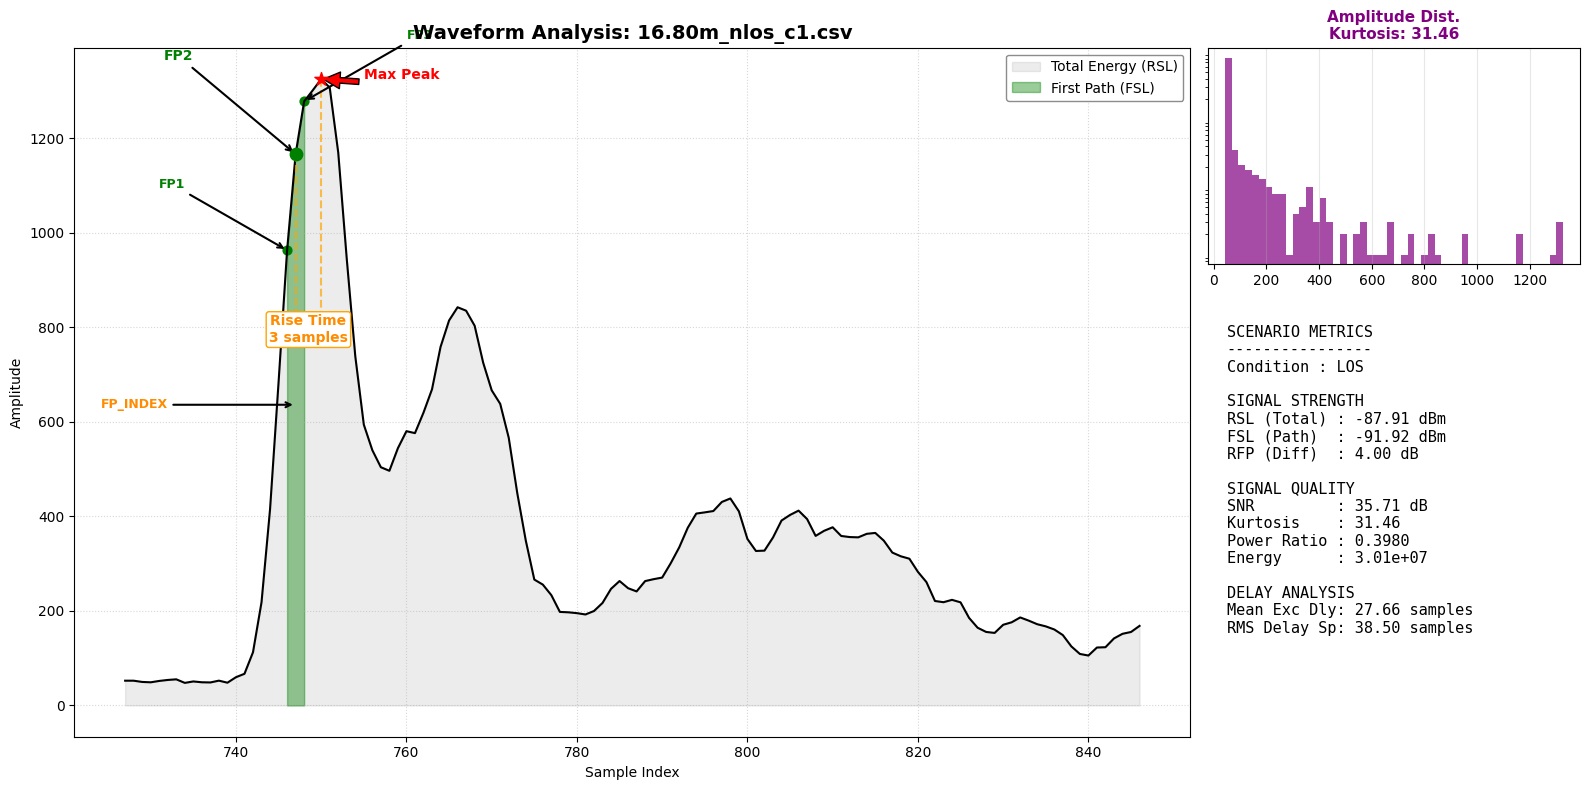

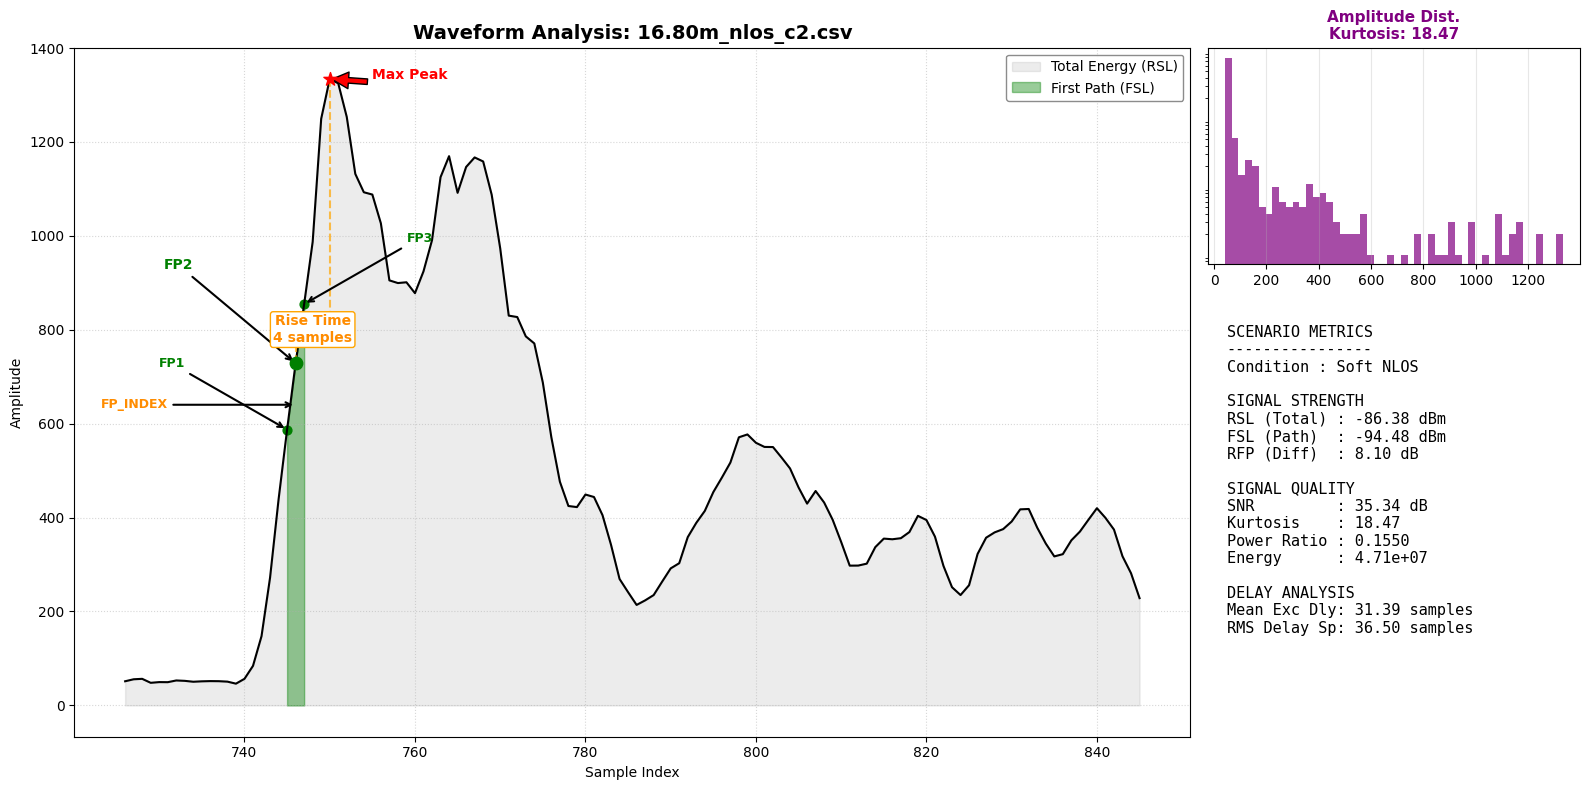

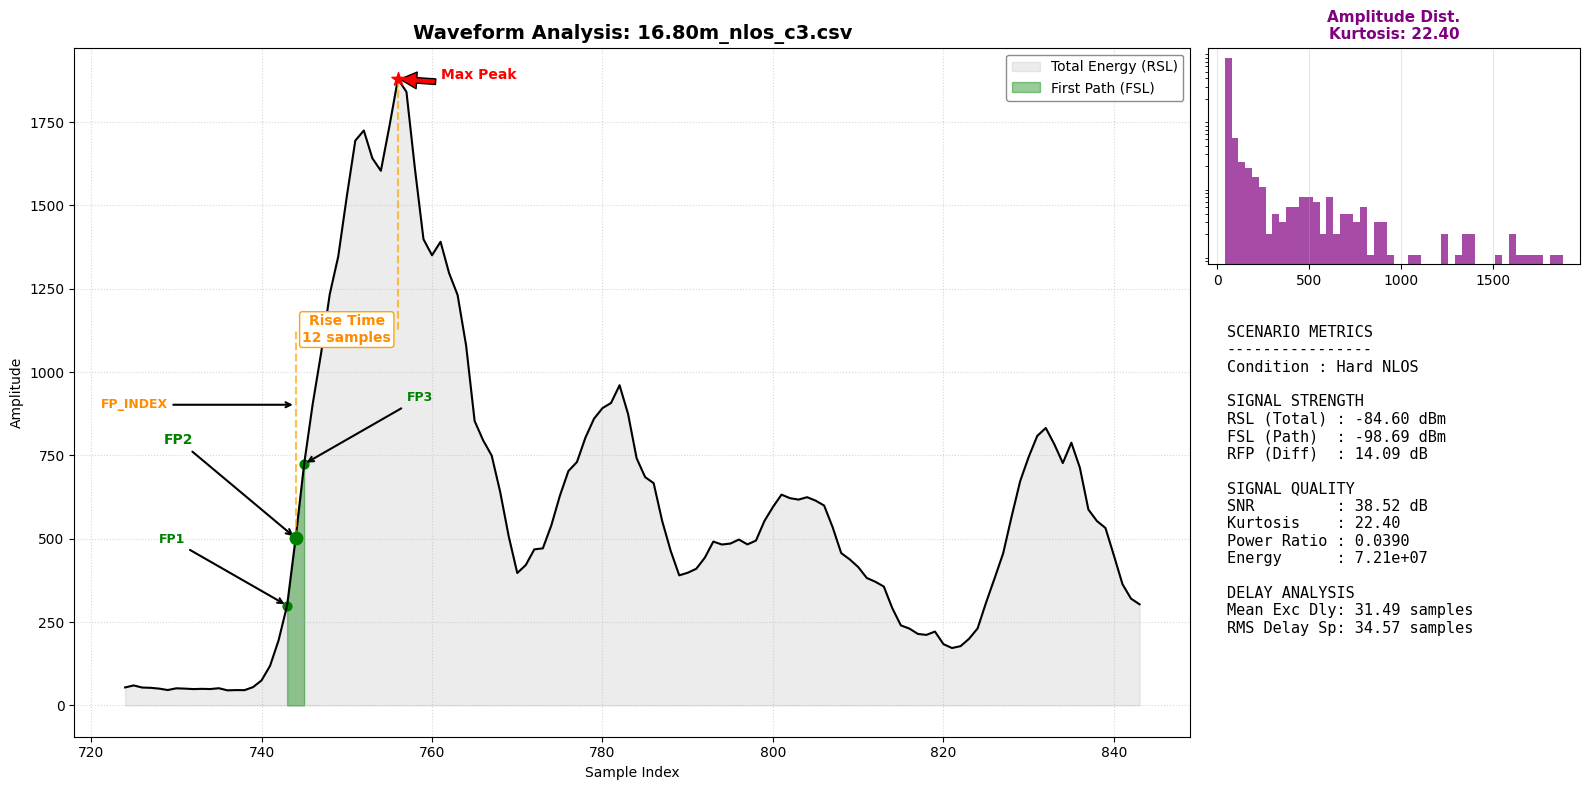

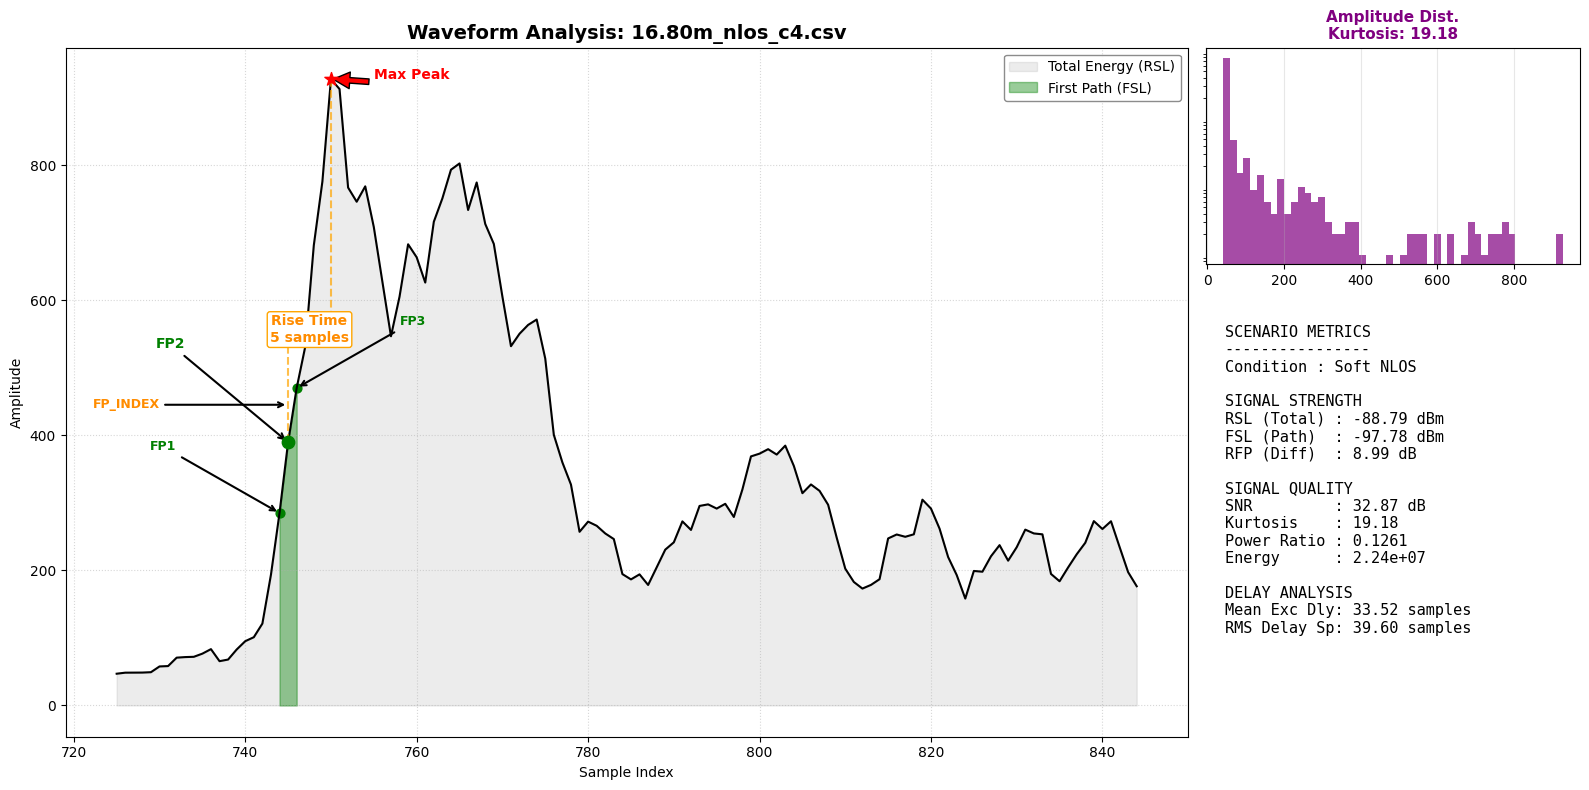

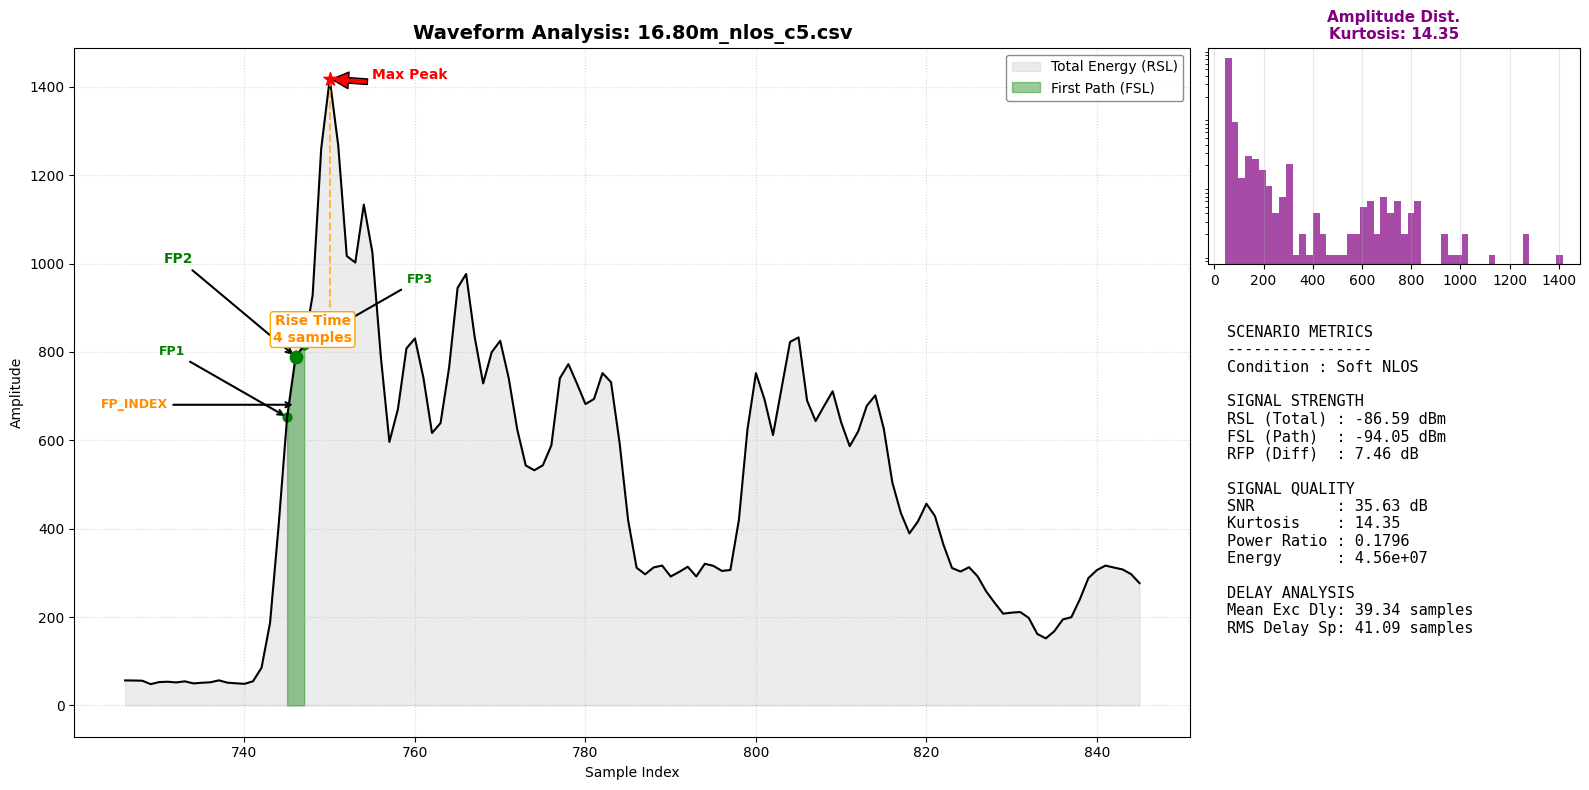

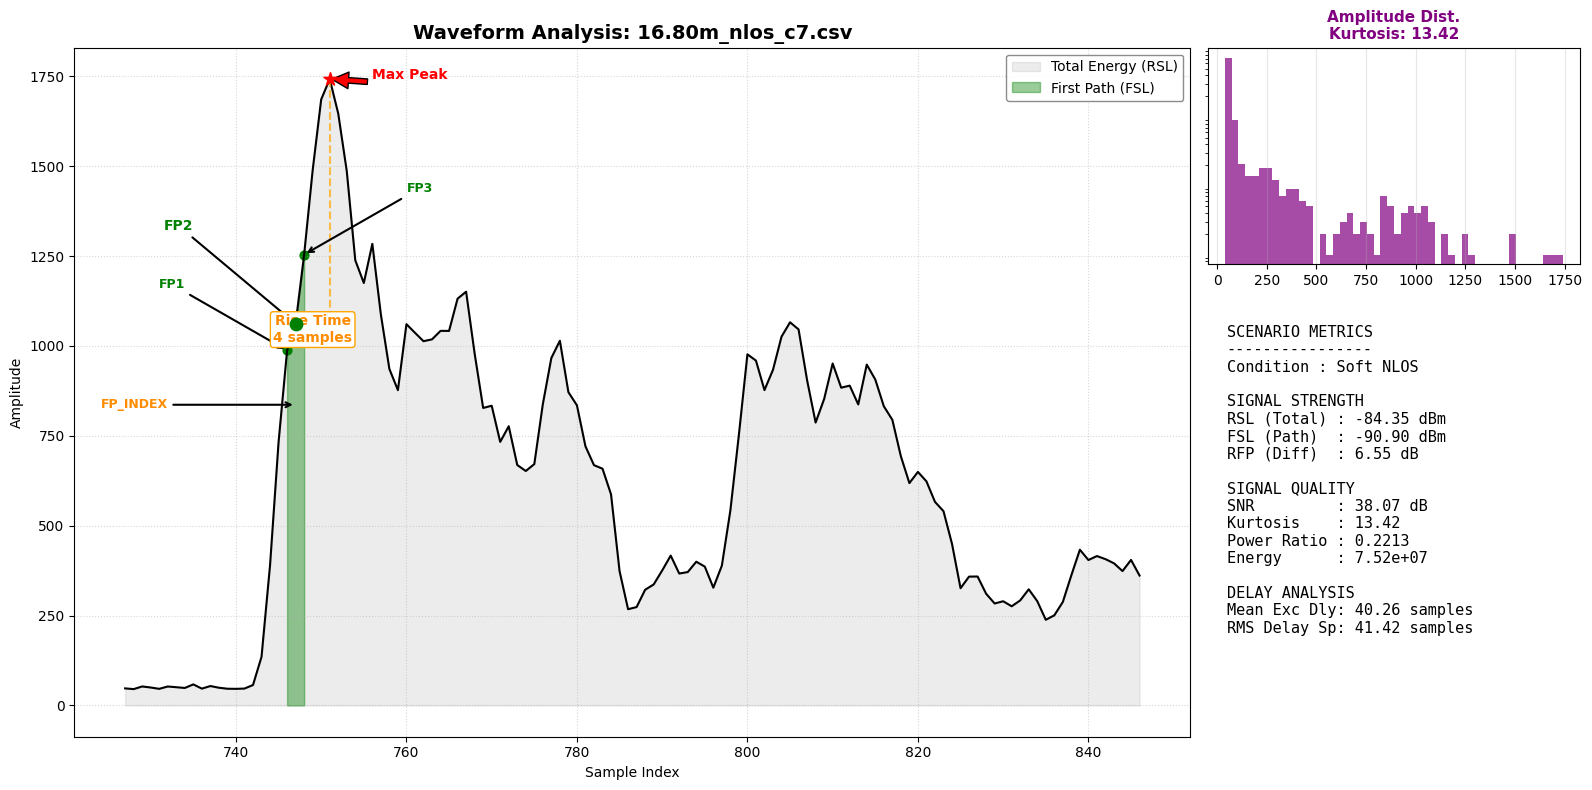

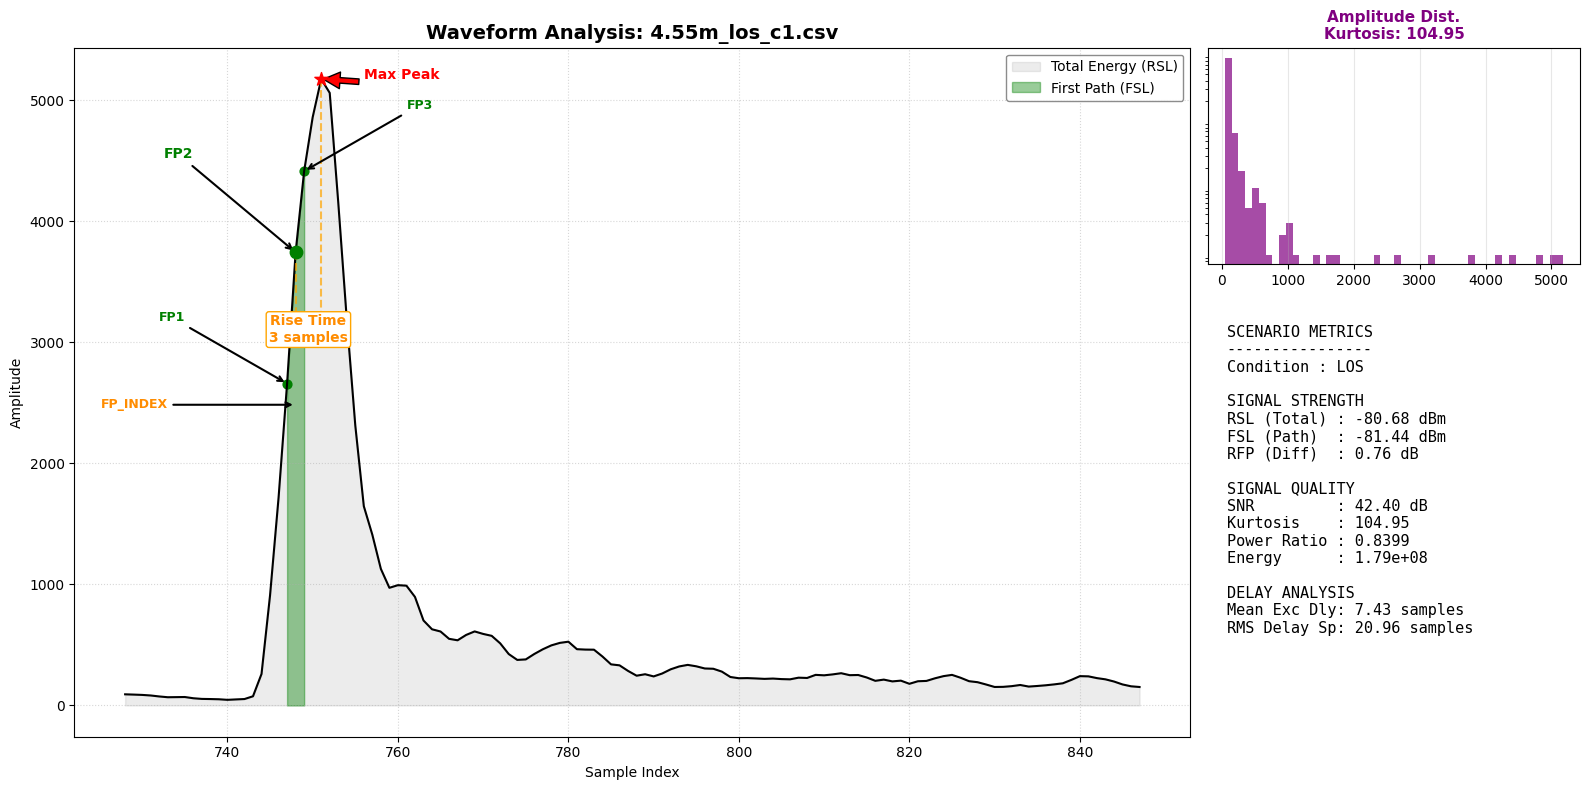

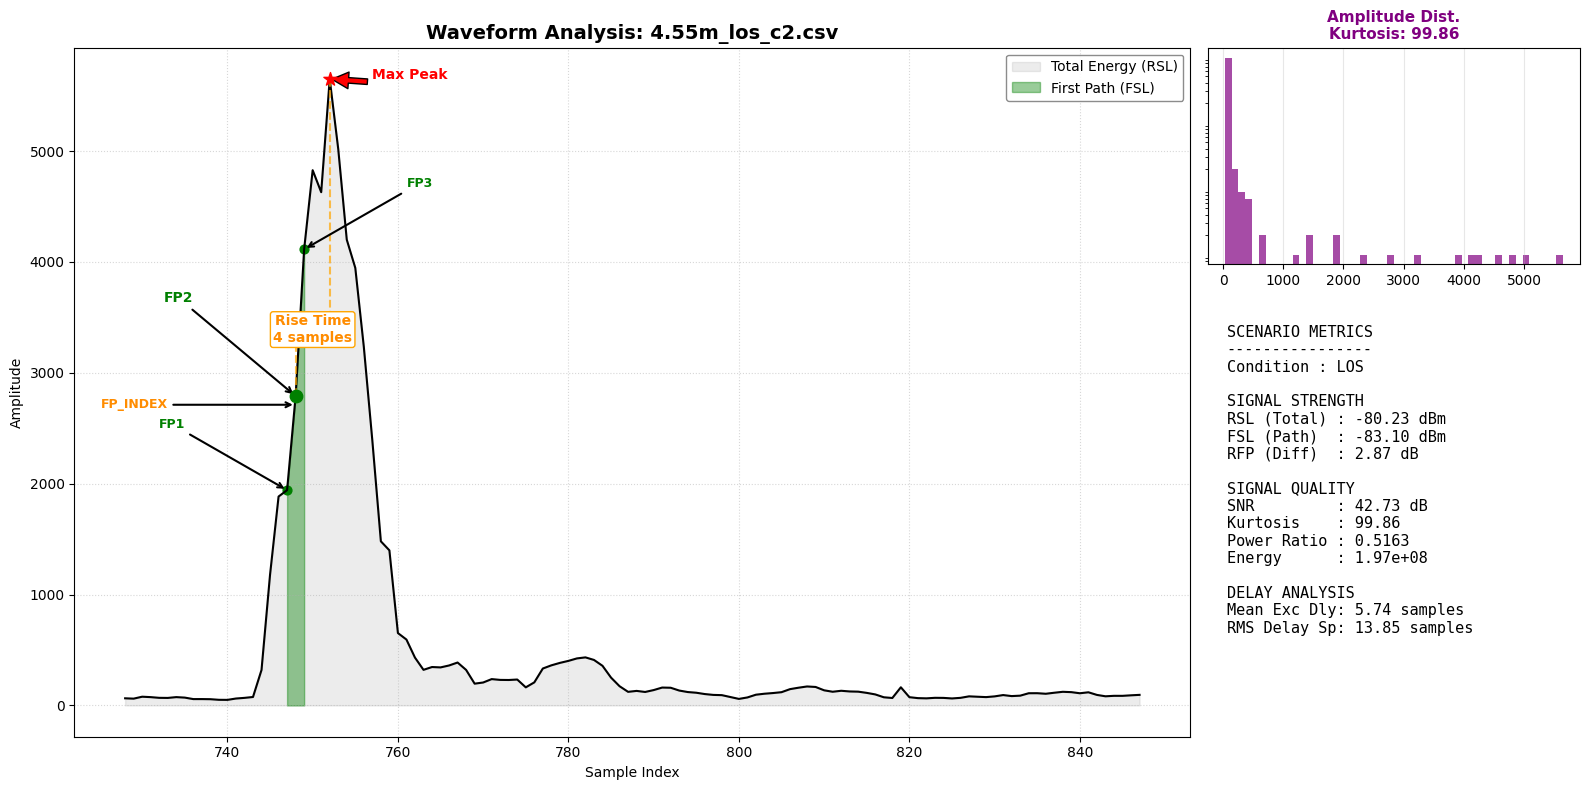

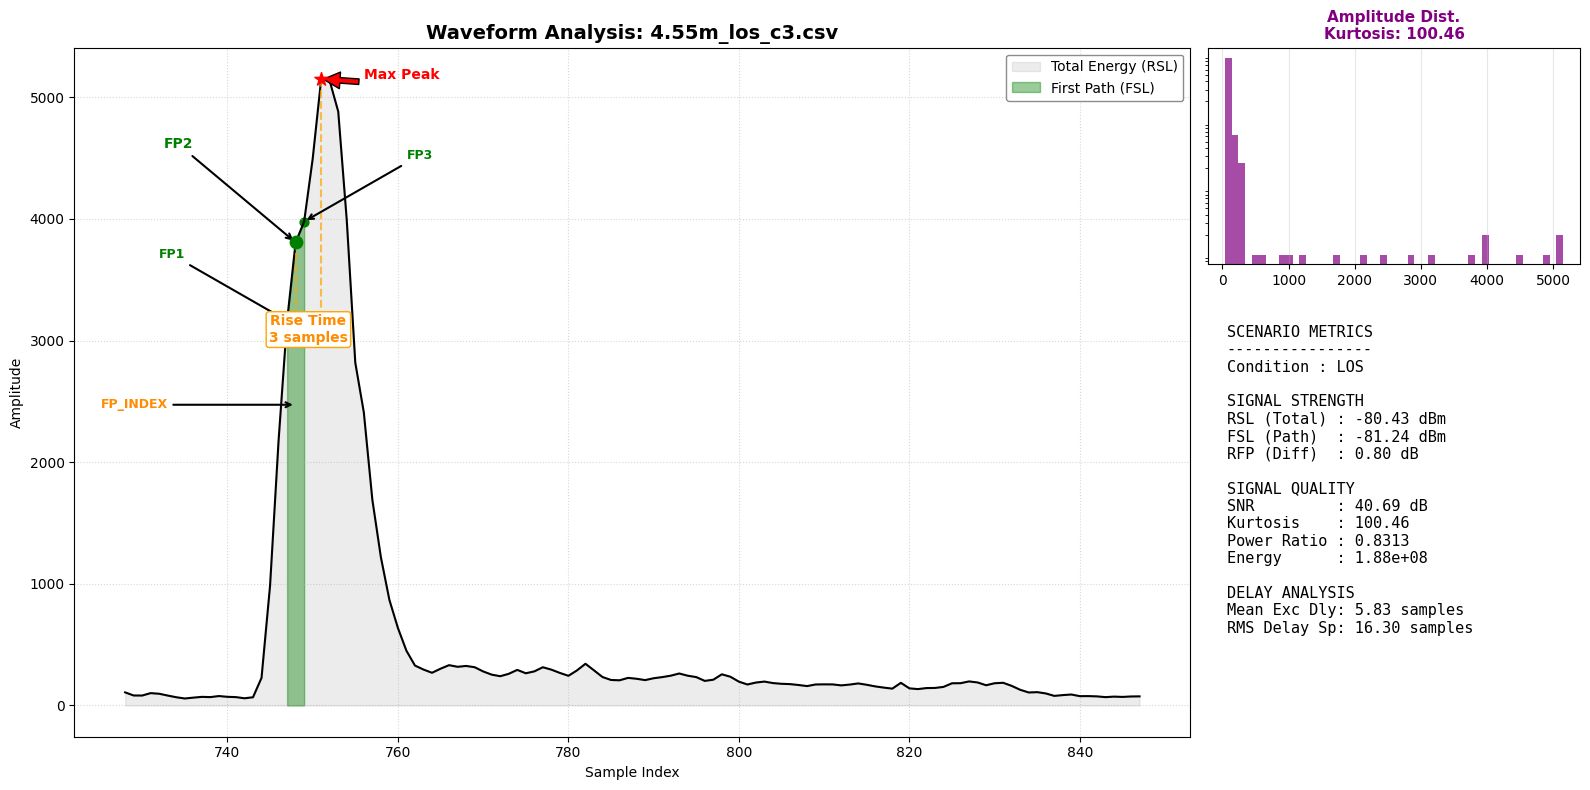

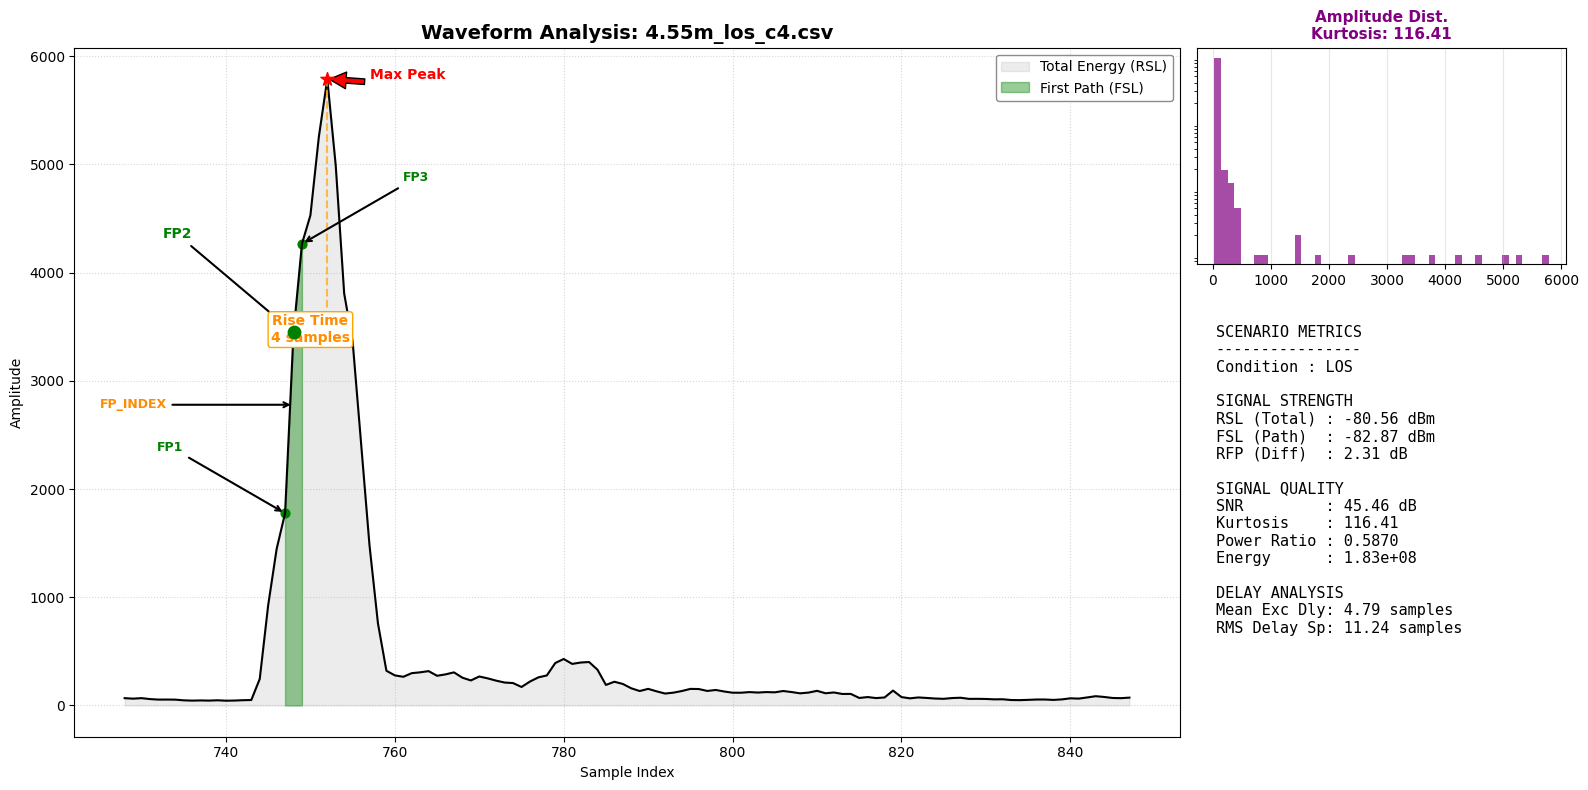

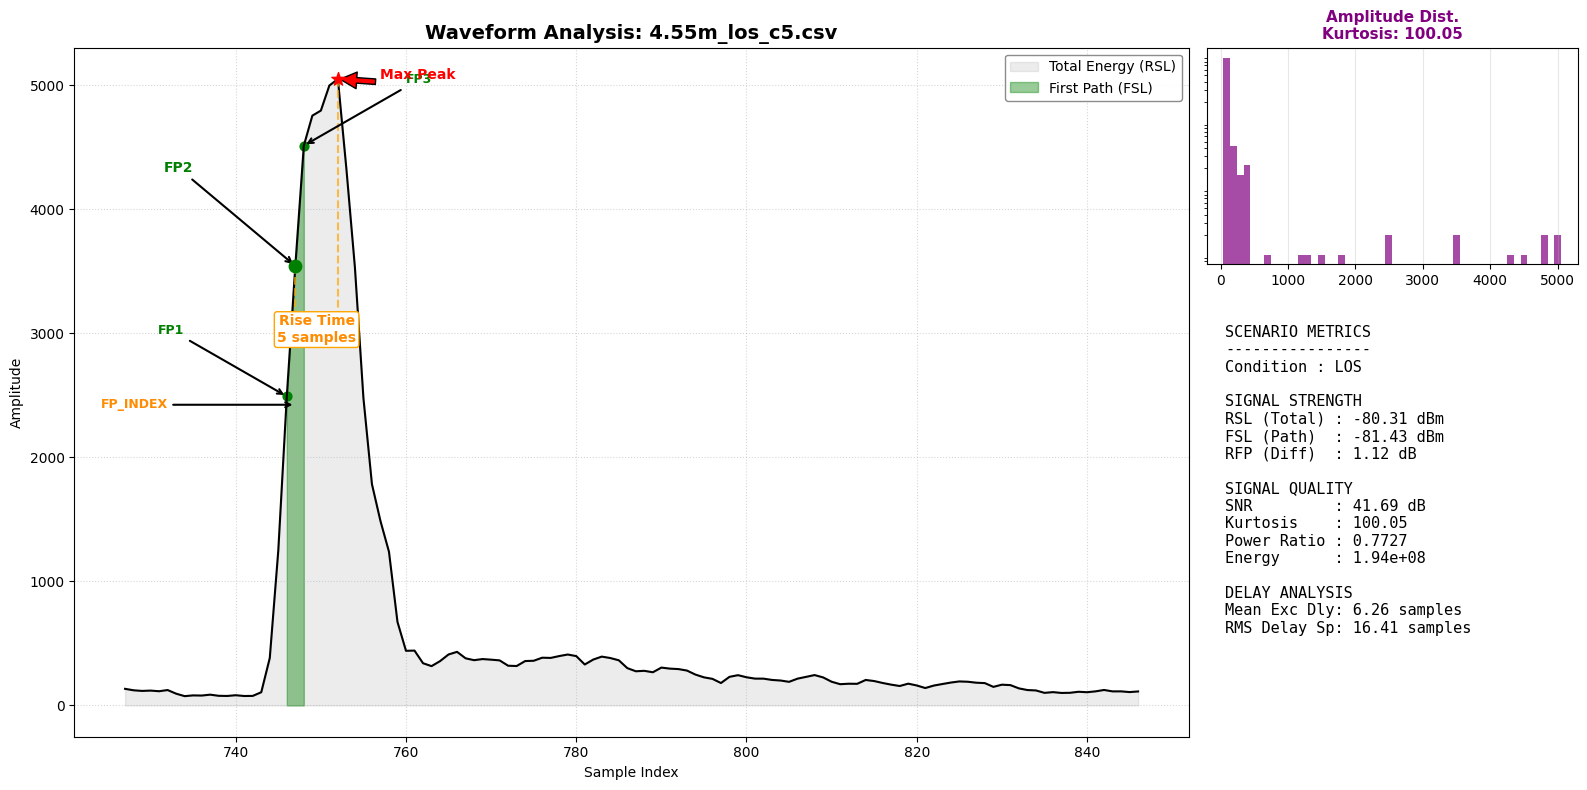

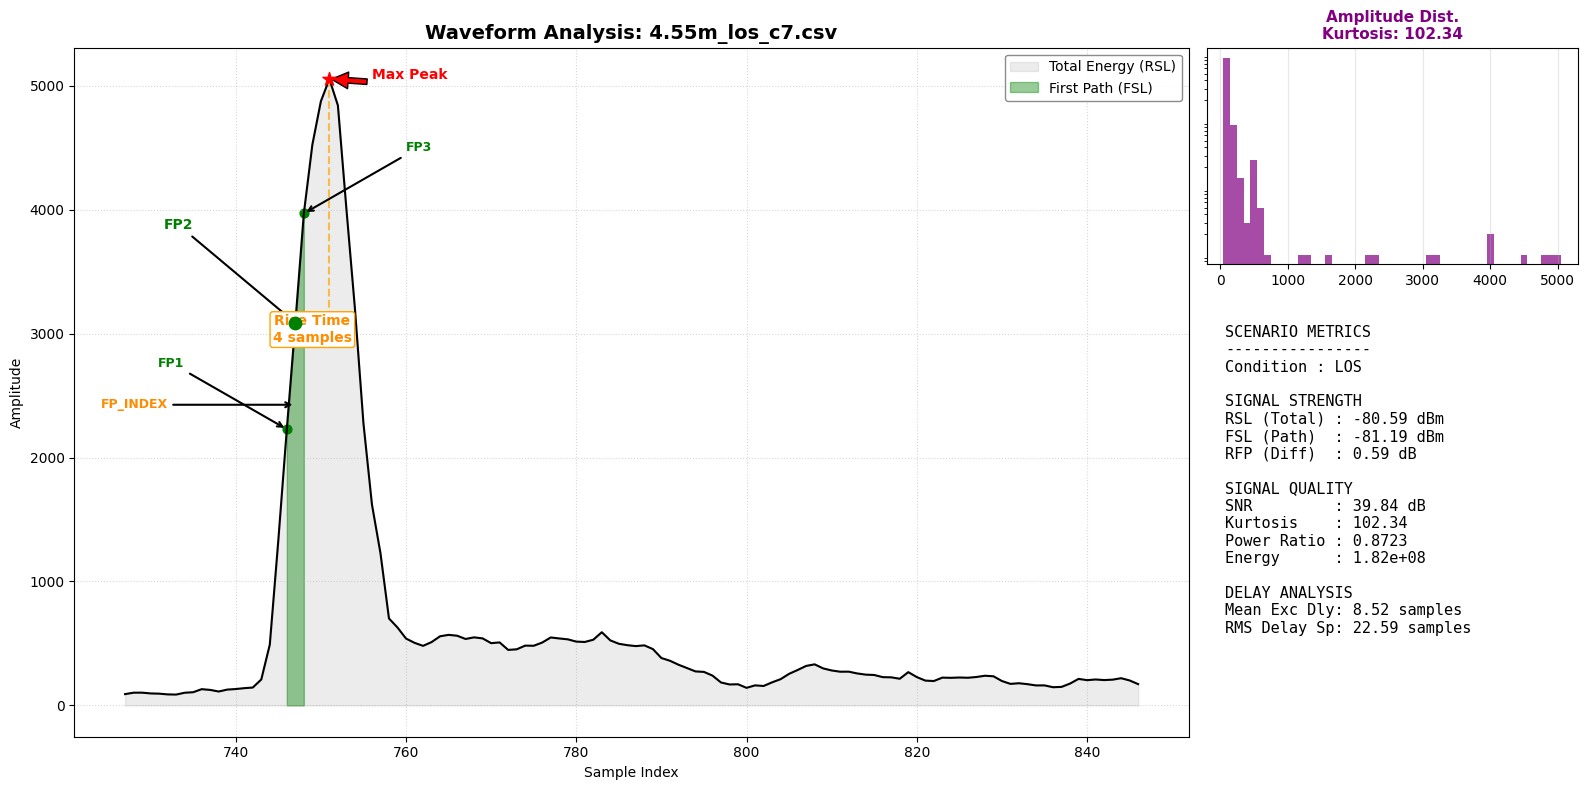

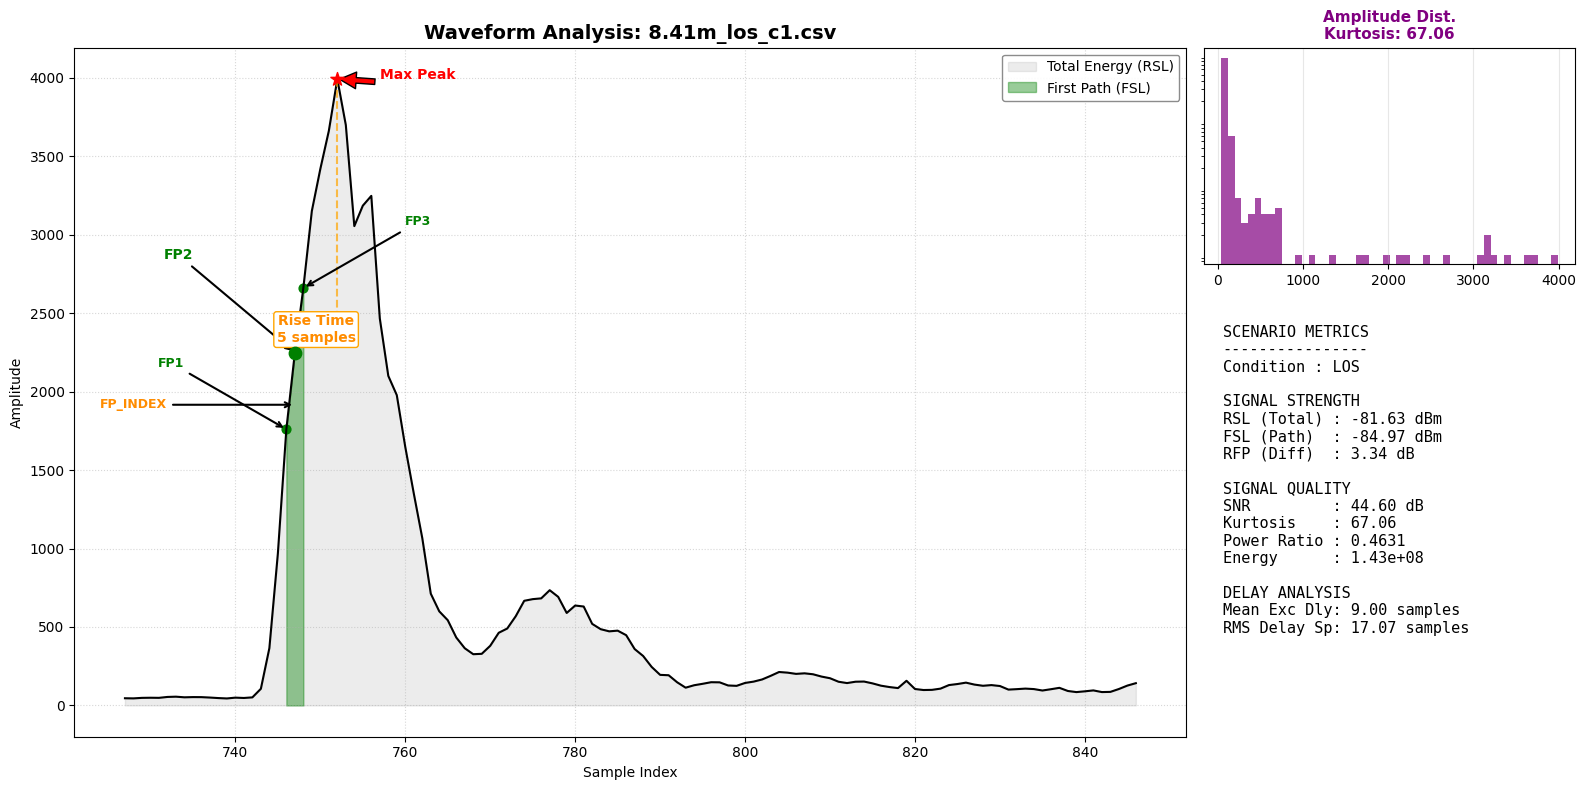

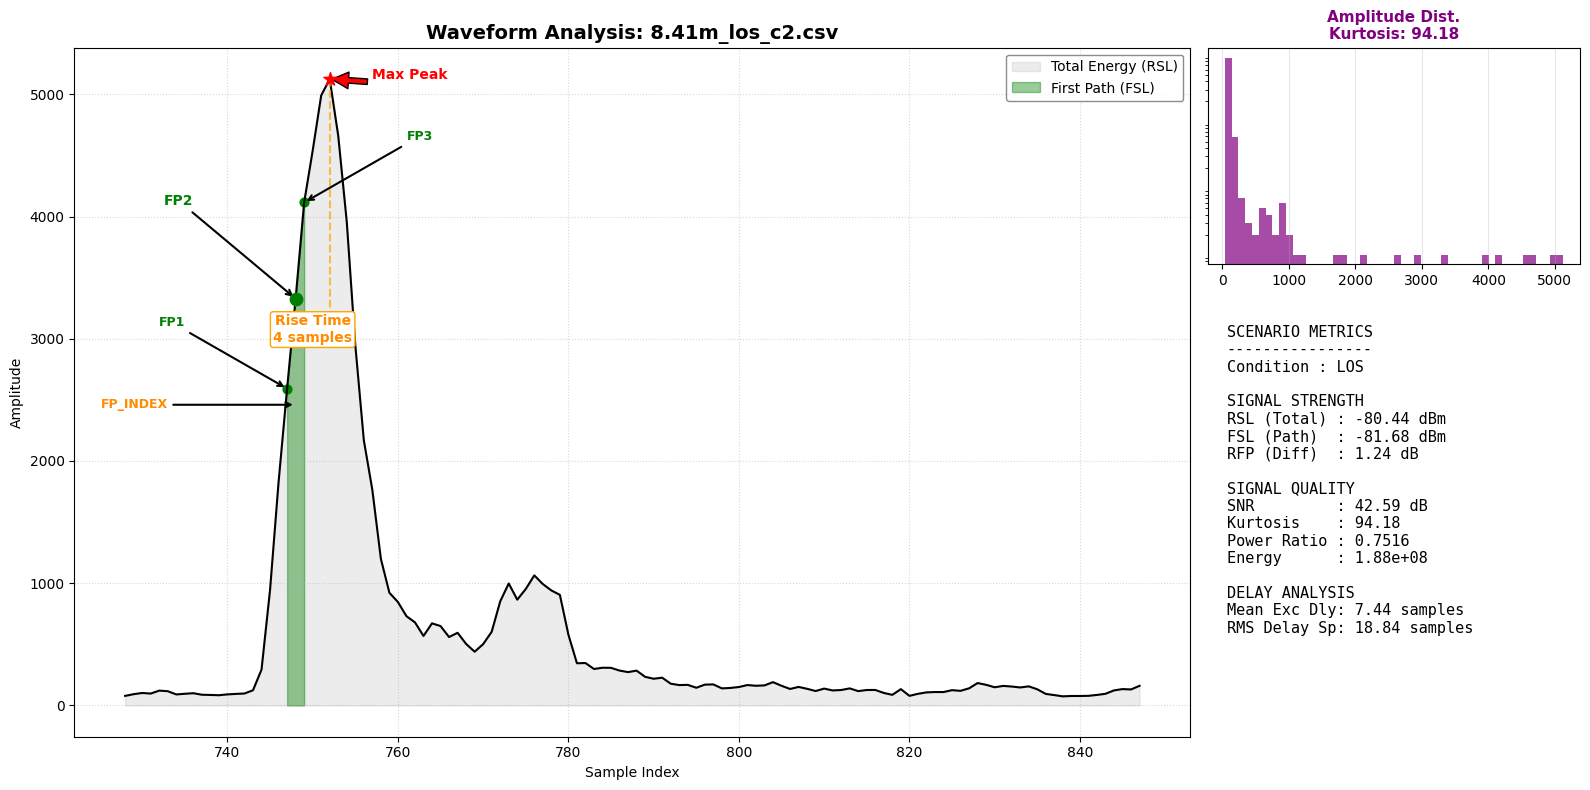

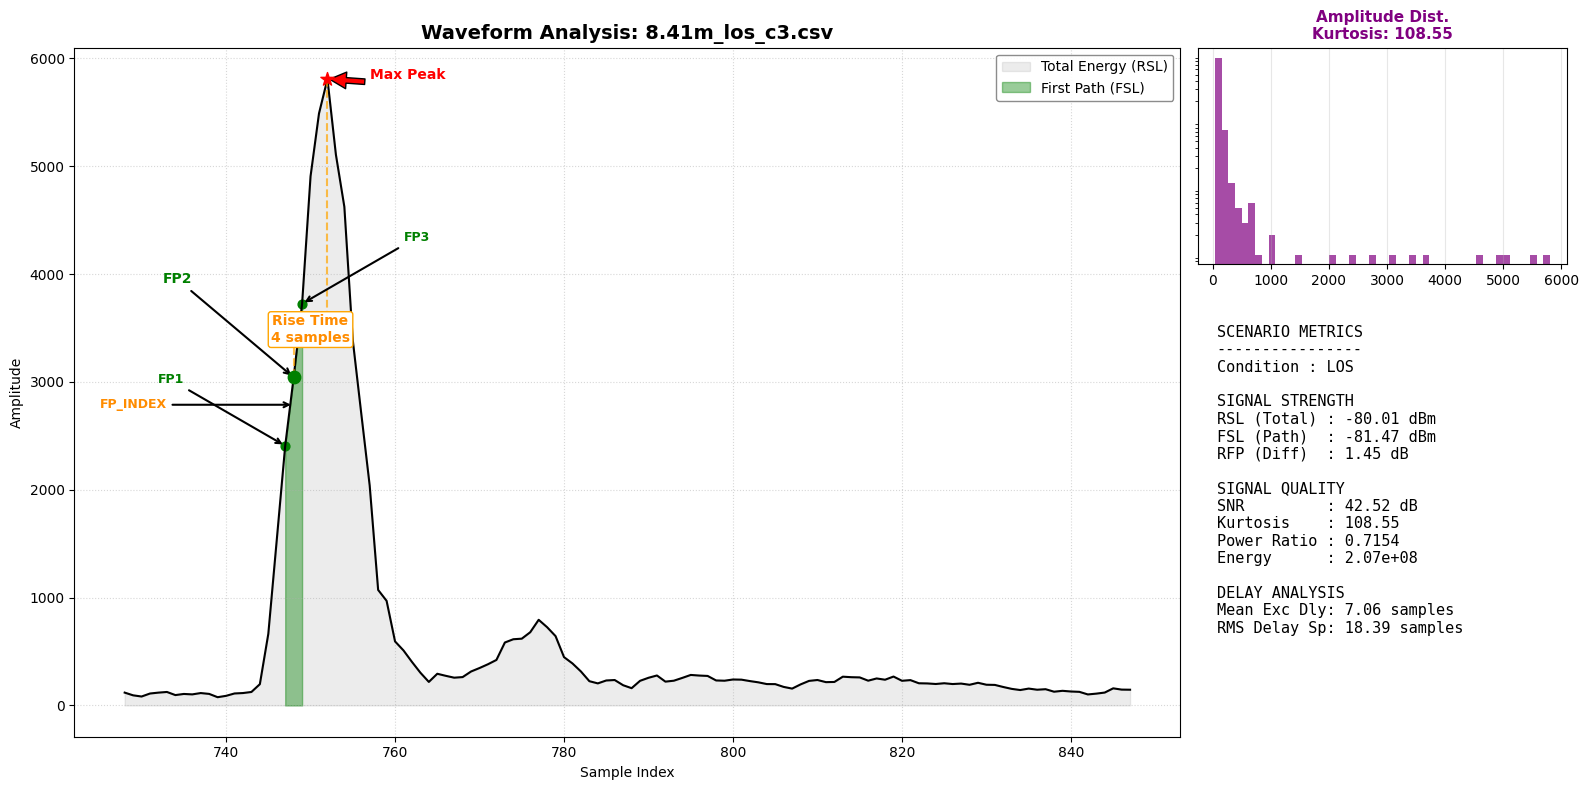

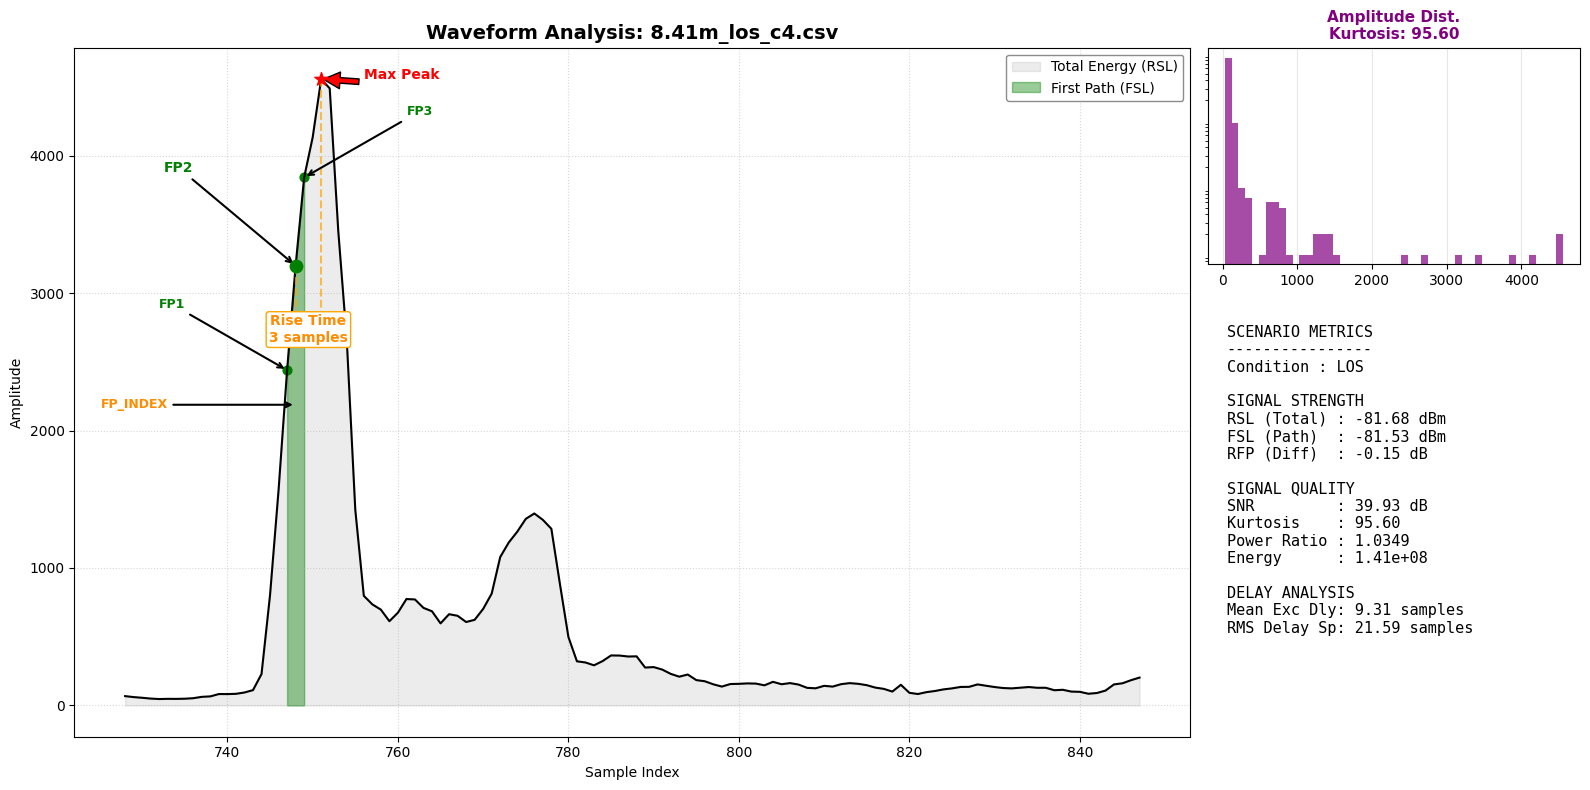

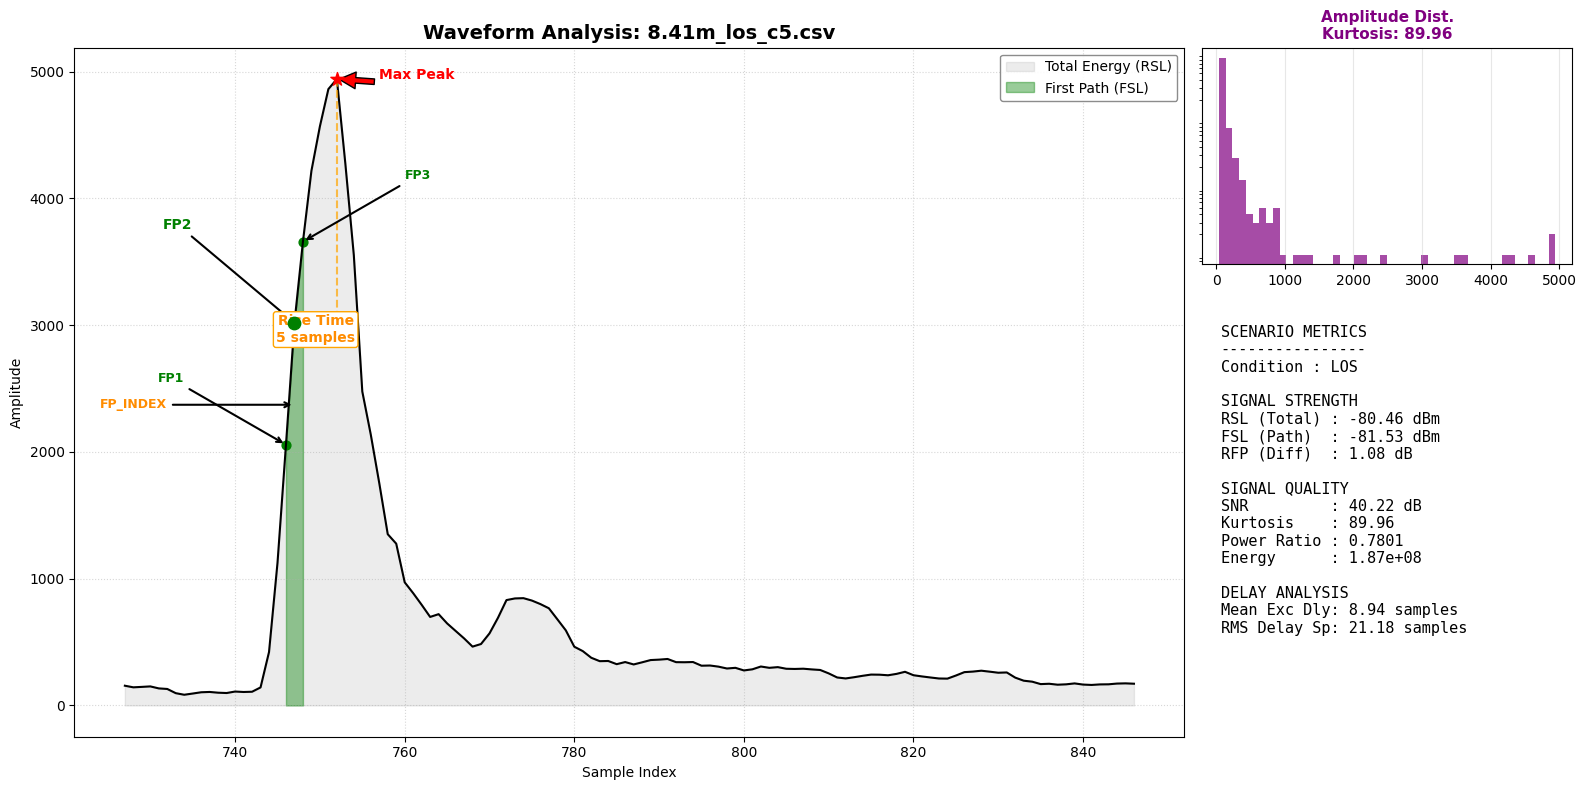

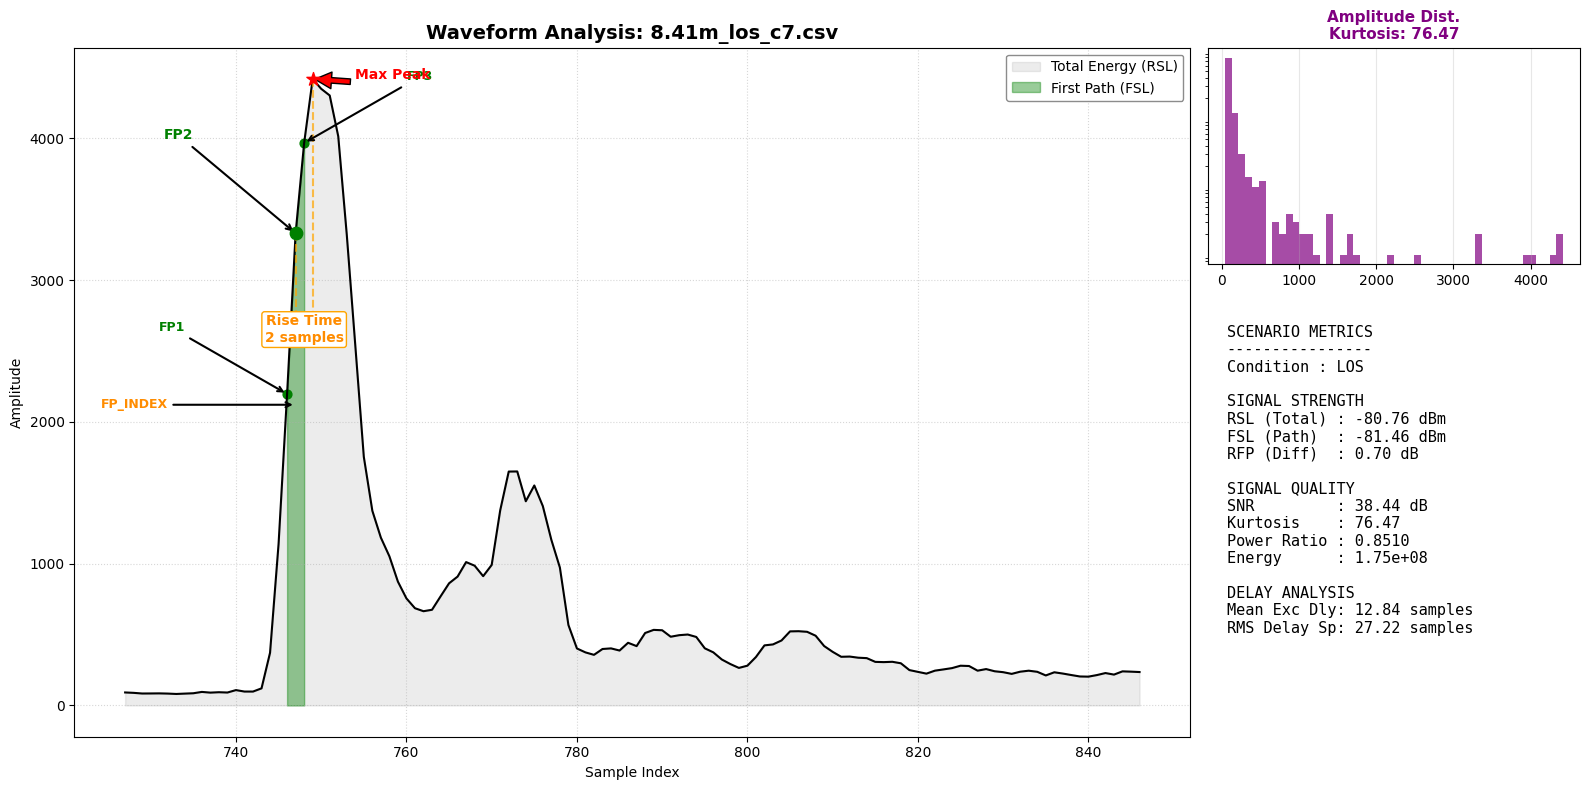

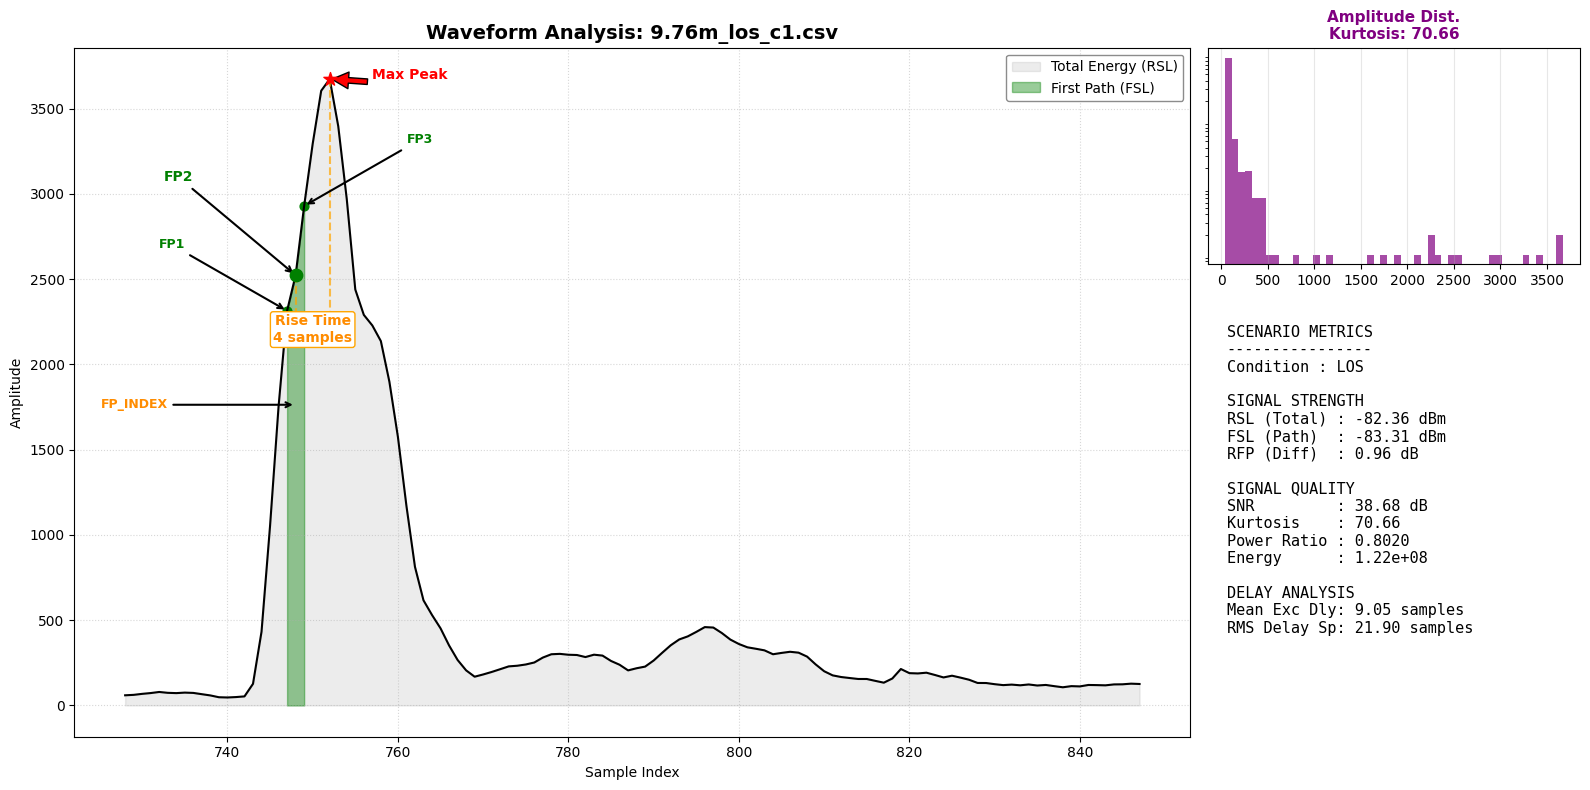

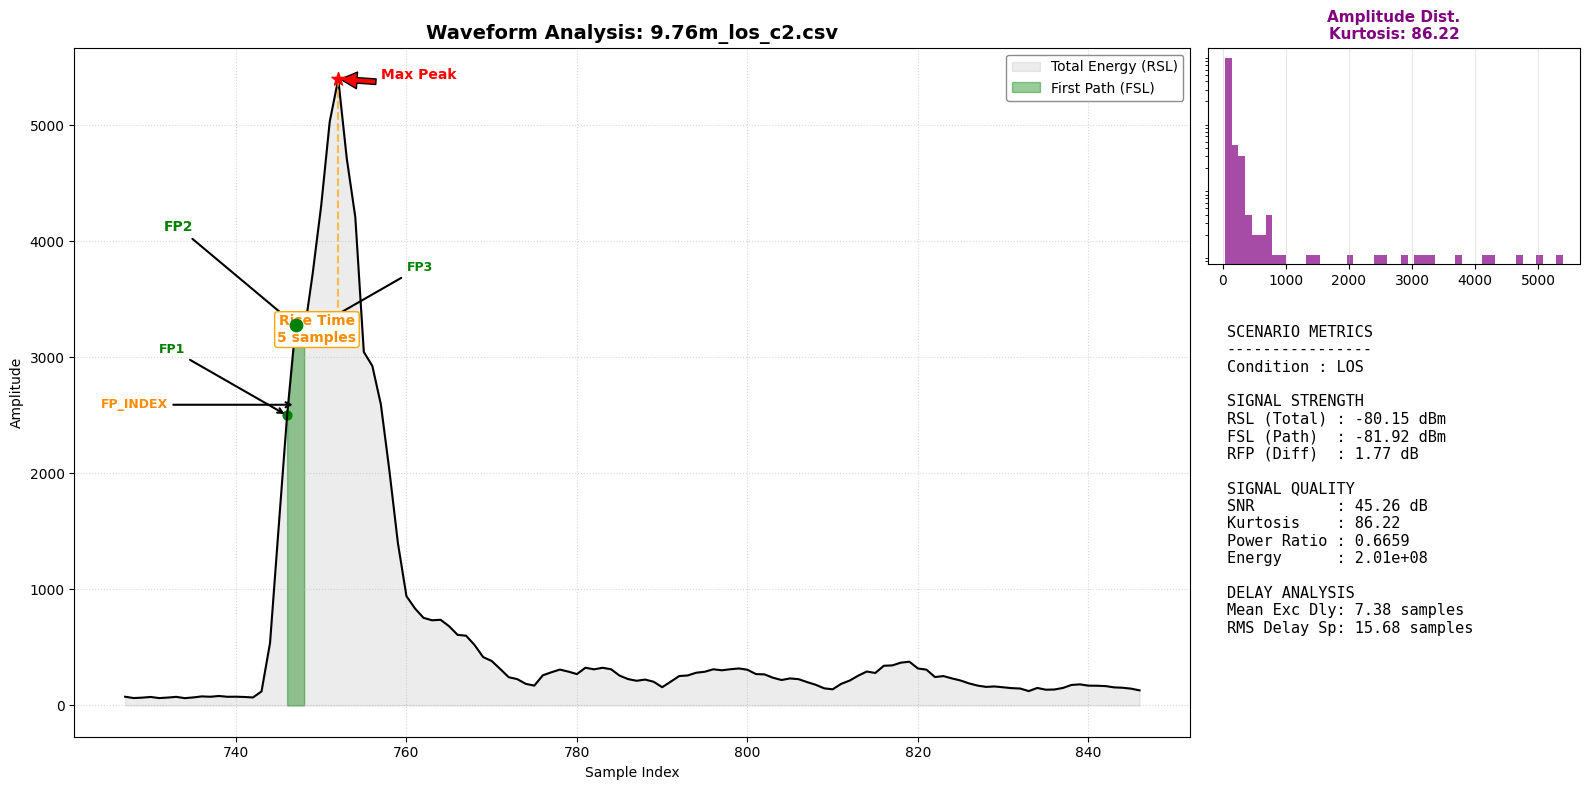

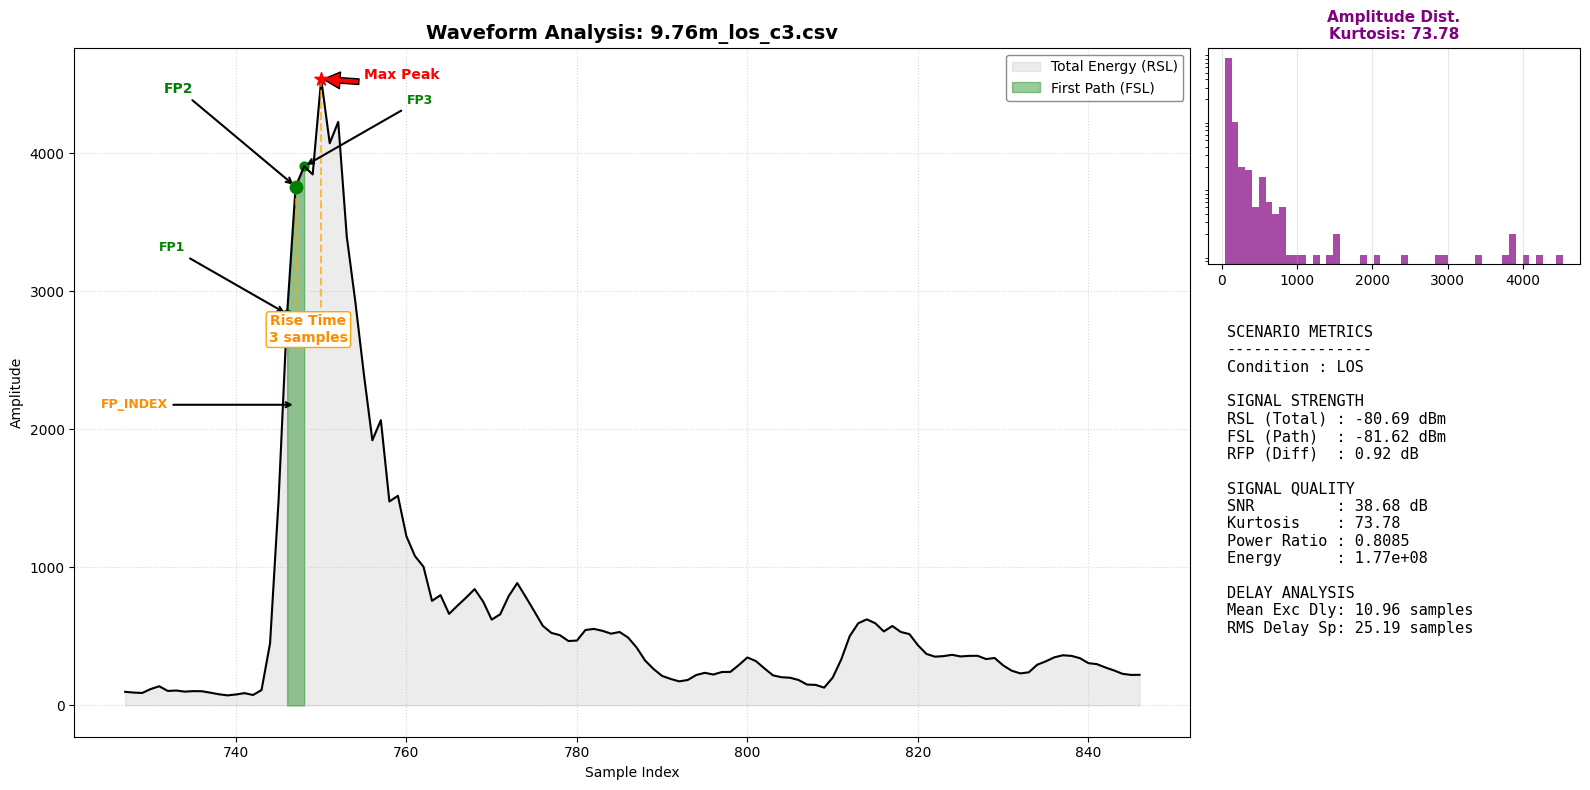

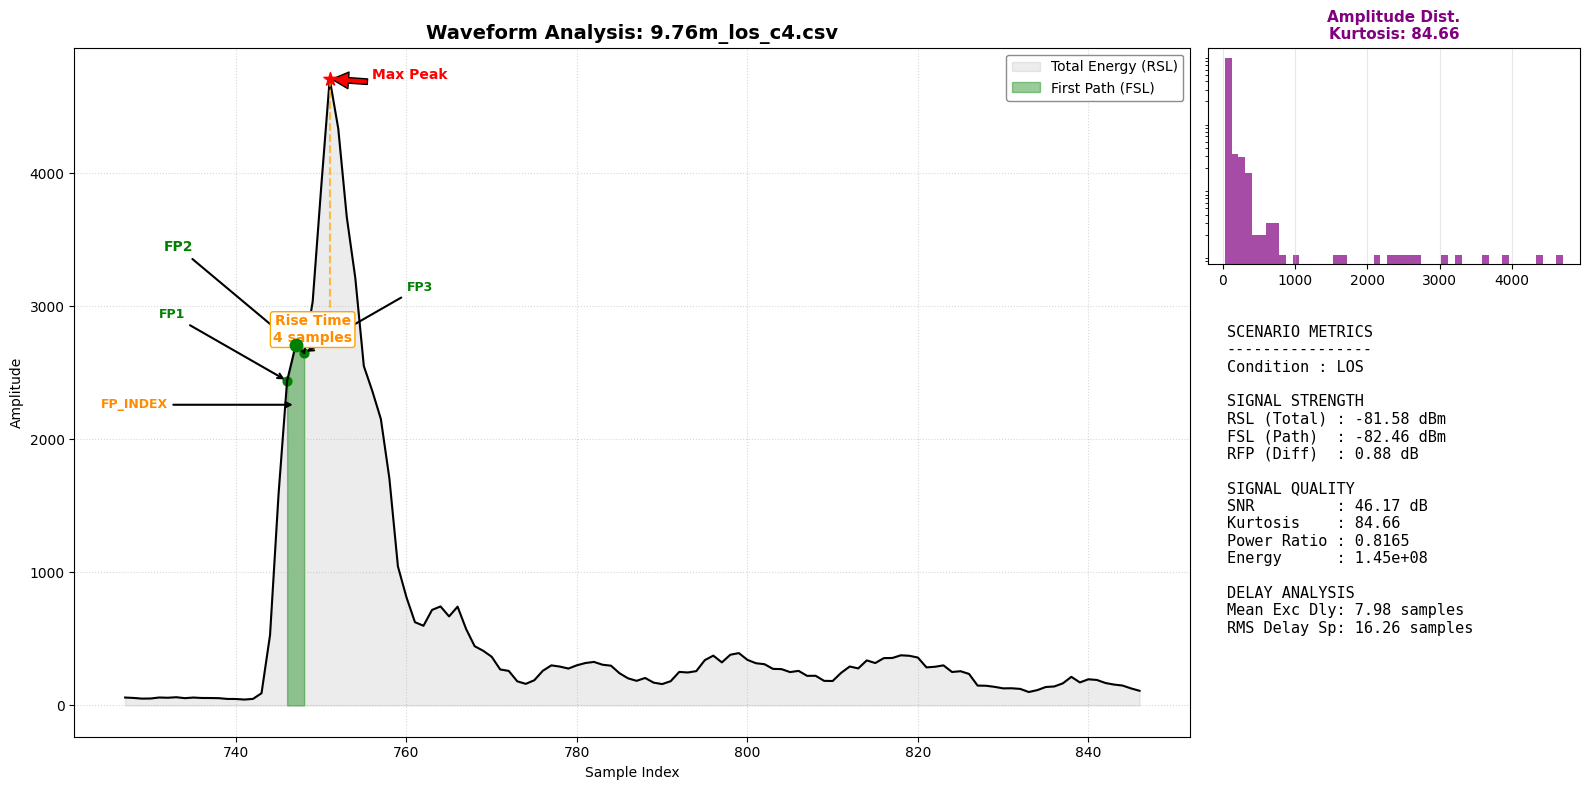

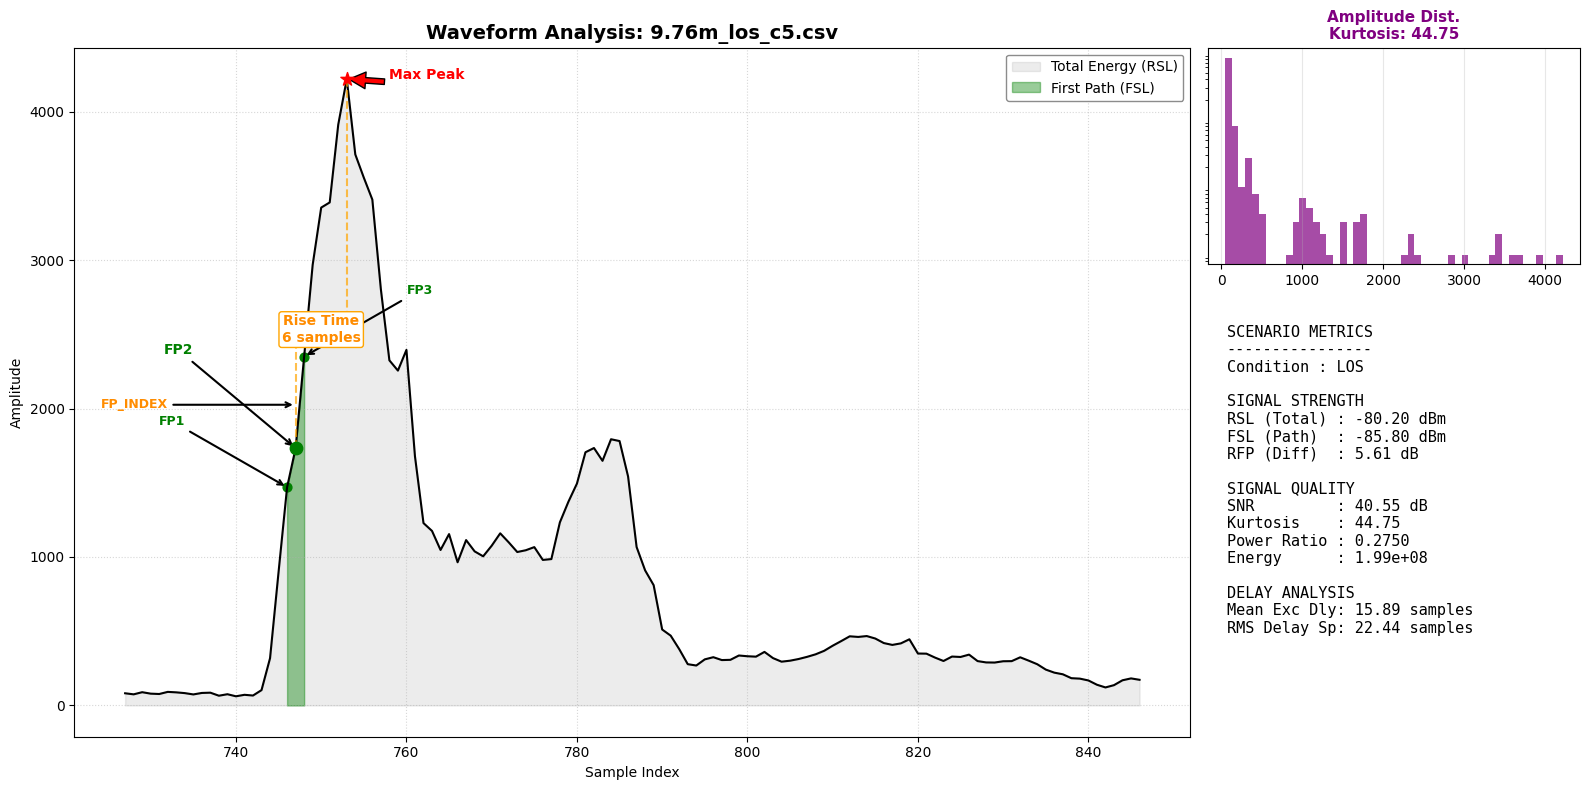

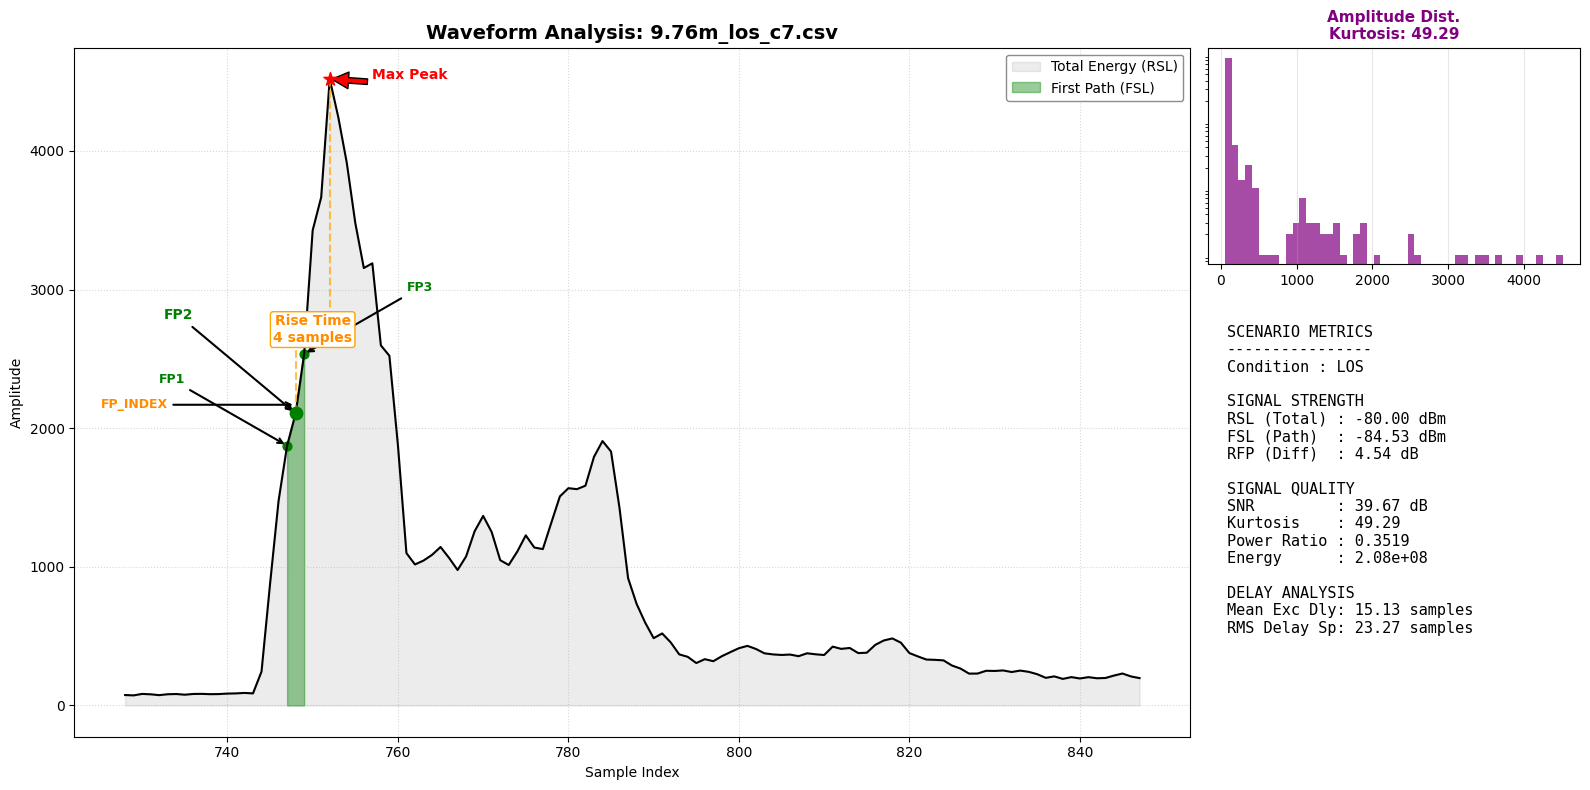

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from scipy.stats import kurtosis
import os
import glob
import re

# ==========================================
# 1. METRIC CALCULATION
# ==========================================
def analyze_hardware_dataset(filepath):
    try:
        df = pd.read_csv(filepath)
        cir_cols = sorted([c for c in df.columns if c.startswith('CIR')], key=lambda x: int(x.replace('CIR', '')))
        if not cir_cols: return None 

        raw_waves = df[cir_cols].values 
        avg_wave = np.mean(raw_waves, axis=0)
        
        # Constants
        A = 121.74 
        if 'RXPACC' in df.columns: N = df['RXPACC'].mean()
        elif 'RXP_ACC' in df.columns: N = df['RXP_ACC'].mean()
        else: N = 128.0 

        # --- ENERGY & RSL ---
        raw_sum_squares = np.sum(avg_wave**2)
        if 'CIR_PWR' in df.columns: C = df['CIR_PWR'].mean()
        else: C = raw_sum_squares / (2**17) 
        safe_C = max(C, 1e-9)
        RSL = 10 * np.log10( (safe_C * (2**17)) / (N**2) ) - A

        # --- FSL & FIRST PATH ---
        hw_fp_idx = int(df['FP_INDEX'].mean() / 64)
        idx_f1 = max(0, hw_fp_idx - 1)
        idx_f2 = hw_fp_idx
        idx_f3 = min(len(avg_wave)-1, hw_fp_idx + 1)
        
        # Plot Values
        plot_F1 = avg_wave[idx_f1]
        plot_F2 = avg_wave[idx_f2]
        plot_F3 = avg_wave[idx_f3]
        
        # Math Values
        if 'FP_AMPL1' in df.columns:
            math_F1, math_F2, math_F3 = df['FP_AMPL1'].mean(), df['FP_AMPL2'].mean(), df['FP_AMPL3'].mean()
        else:
            math_F1, math_F2, math_F3 = plot_F1, plot_F2, plot_F3

        F_sum = (math_F1**2) + (math_F2**2) + (math_F3**2)
        safe_F = max(F_sum, 1e-9)
        FSL = 10 * np.log10( safe_F / (N**2) ) - A

        # --- SNR ---
        if 'STD_NOISE' in df.columns: std_noise = df['STD_NOISE'].mean()
        else: std_noise = np.std(avg_wave[0:30])
        max_amp = np.max(avg_wave)
        SNR = 20 * np.log10(max_amp / (std_noise + 1e-9))

        # --- ADDITIONAL METRICS ---
        kurt_val = kurtosis(avg_wave)
        fp_energy_raw = math_F1**2 + math_F2**2 + math_F3**2
        total_energy_raw = np.sum(avg_wave**2)
        power_ratio = fp_energy_raw / max(total_energy_raw, 1e-9)
        
        # --- DELAY SPREAD CALCULATIONS ---
        pdp = avg_wave[hw_fp_idx:]**2
        times = np.arange(len(pdp))
        total_pdp_pwr = np.sum(pdp) + 1e-9
        mean_excess_delay = np.sum(pdp * times) / total_pdp_pwr
        second_moment = np.sum(pdp * (times**2)) / total_pdp_pwr
        rms_delay_spread = np.sqrt(max(0, second_moment - (mean_excess_delay**2)))
        
        RFP = RSL - FSL
        if RFP < 6.0: condition = "LOS"
        elif RFP <= 10.0: condition = "Soft NLOS"
        else: condition = "Hard NLOS"
        
        peak_idx = np.argmax(avg_wave)
        rise_time = peak_idx - hw_fp_idx

        return {
            "Filename": os.path.basename(filepath),
            "Avg_Wave": avg_wave,
            "HW_FP_Index": hw_fp_idx,
            "Indices": (idx_f1, idx_f2, idx_f3, peak_idx),
            "Plot_Amps": (plot_F1, plot_F2, plot_F3),
            "Max_Amp": max_amp,
            "RSL_dBm": RSL,
            "FSL_dBm": FSL,
            "RFP_Metric": RFP,
            "SNR_dB": SNR,
            "Kurtosis": kurt_val,
            "Power_Ratio": power_ratio,
            "Total_Energy": total_energy_raw,
            "Rise_Time": rise_time,
            "Mean_Excess_Delay": mean_excess_delay,
            "RMS_Delay_Spread": rms_delay_spread,
            "Condition": condition
        }
    except Exception as e: return None

# ==========================================
# 2. PLOTTER (Standard Close Labels)
# ==========================================
def plot_final_standard_labels(scenario_prefix):
    files = glob.glob(f"{scenario_prefix}_c*.csv")
    if not files: return

    for f in sorted(files):
        data = analyze_hardware_dataset(f)
        if not data: continue

        avg_wave = data['Avg_Wave']
        hw_fp = data['HW_FP_Index']
        idx_f1, idx_f2, idx_f3, peak_idx = data['Indices']
        f1, f2, f3 = data['Plot_Amps']
        max_amp = data['Max_Amp']
        
        # --- SETUP GRID ---
        fig = plt.figure(figsize=(16, 8))
        gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1, 2])
        
        ax_main = fig.add_subplot(gs[:, 0])      # Main Waveform
        ax_hist = fig.add_subplot(gs[0, 1])      # Histogram
        ax_text = fig.add_subplot(gs[1, 1])      # Metrics
        
        # --- 1. MAIN WAVEFORM PLOT (Left) ---
        start = max(0, hw_fp - 20)
        end = min(len(avg_wave), hw_fp + 100)
        x_zoom = np.arange(start, end)
        y_zoom = avg_wave[start:end]
        
        # Shading
        ax_main.fill_between(x_zoom, 0, y_zoom, color='gray', alpha=0.15, label='Total Energy (RSL)')
        ax_main.fill_between([idx_f1, idx_f2, idx_f3], 0, [f1, f2, f3], color='green', alpha=0.4, label='First Path (FSL)')
        ax_main.plot(x_zoom, y_zoom, color='black', linewidth=1.5)
        
        # --- POINT ANNOTATIONS ---
        ax_main.scatter(idx_f2, f2, color='green', s=80, zorder=5)
        ax_main.annotate('FP2', xy=(idx_f2, f2), xytext=(idx_f2 - 12, f2 + (max_amp*0.15)),
                    arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5),
                    fontsize=10, color='green', fontweight='bold', ha='right')

        ax_main.scatter(idx_f1, f1, color='green', s=40)
        ax_main.annotate('FP1', xy=(idx_f1, f1), xytext=(idx_f1 - 12, f1 + (max_amp*0.1)),
                    arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5), 
                    fontsize=9, color='green', fontweight='bold', ha='right')
        
        ax_main.scatter(idx_f3, f3, color='green', s=40)
        ax_main.annotate('FP3', xy=(idx_f3, f3), xytext=(idx_f3 + 12, f3 + (max_amp*0.1)),
                    arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5), 
                    fontsize=9, color='green', fontweight='bold', ha='left')

        ax_main.scatter(peak_idx, max_amp, color='red', s=100, marker='*', zorder=5)
        ax_main.annotate('Max Peak', xy=(peak_idx, max_amp), xytext=(peak_idx + 5, max_amp),
                    arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10, color='red', fontweight='bold')
        
        # --- RISE TIME & FP_INDEX ---
        dim_y = max_amp * 0.6 
        ax_main.plot([hw_fp, hw_fp], [f2, dim_y], color='orange', linestyle='--', alpha=0.7)
        ax_main.annotate('FP_INDEX', xy=(hw_fp, dim_y * 0.8), xytext=(hw_fp - 15, dim_y * 0.8),
                         arrowprops=dict(facecolor='orange', arrowstyle='->', lw=1.5),
                         color='darkorange', fontsize=9, fontweight='bold', ha='right', va='center')
        
        ax_main.plot([peak_idx, peak_idx], [max_amp, dim_y], color='orange', linestyle='--', alpha=0.7)
        ax_main.annotate('', xy=(hw_fp, dim_y), xytext=(peak_idx, dim_y), arrowprops=dict(arrowstyle='<->', color='orange', lw=2))
        mid_x = (hw_fp + peak_idx) / 2
        ax_main.text(mid_x, dim_y, f"Rise Time\n{data['Rise_Time']} samples", 
                color='darkorange', fontsize=10, ha='center', va='center', fontweight='bold',
                bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.2'))

        ax_main.legend(loc='upper right', framealpha=0.9, edgecolor='gray')
        ax_main.set_title(f"Waveform Analysis: {data['Filename']}", fontsize=14, fontweight='bold')
        ax_main.set_xlabel("Sample Index")
        ax_main.set_ylabel("Amplitude")
        ax_main.grid(True, linestyle=':', alpha=0.5)

        # --- 2. HISTOGRAM (Top Right) ---
        ax_hist.hist(avg_wave, bins=50, color='purple', alpha=0.7)
        ax_hist.set_title(f"Amplitude Dist.\nKurtosis: {data['Kurtosis']:.2f}", fontsize=11, fontweight='bold', color='purple')
        ax_hist.set_yscale('log')
        ax_hist.tick_params(left=False, labelleft=False)
        ax_hist.grid(axis='x', alpha=0.3)

        # --- 3. METRICS LIST (Bottom Right) ---
        ax_text.axis('off')
        info_text = (
            f"SCENARIO METRICS\n"
            f"----------------\n"
            f"Condition : {data['Condition']}\n\n"
            f"SIGNAL STRENGTH\n"
            f"RSL (Total) : {data['RSL_dBm']:.2f} dBm\n"
            f"FSL (Path)  : {data['FSL_dBm']:.2f} dBm\n"
            f"RFP (Diff)  : {data['RFP_Metric']:.2f} dB\n\n"
            f"SIGNAL QUALITY\n"
            f"SNR         : {data['SNR_dB']:.2f} dB\n"
            f"Kurtosis    : {data['Kurtosis']:.2f}\n"
            f"Power Ratio : {data['Power_Ratio']:.4f}\n"
            f"Energy      : {data['Total_Energy']:.2e}\n\n"
            f"DELAY ANALYSIS\n"
            f"Mean Exc Dly: {data['Mean_Excess_Delay']:.2f} samples\n"
            f"RMS Delay Sp: {data['RMS_Delay_Spread']:.2f} samples"
        )
        ax_text.text(0.05, 0.95, info_text, transform=ax_text.transAxes, fontsize=11, family='monospace', va='top')

        plt.tight_layout()
        plt.show()

# Run — search in dataset/channel/
all_csvs = glob.glob(os.path.join(CHANNEL_DIR, "*.csv"))
scenarios = sorted(list(set([re.sub(r'_c\d+\.csv$', '', f) for f in all_csvs if "_c" in f])))
for s in scenarios:
    plot_final_standard_labels(s)

PHYSICS-BASED 1-BOUNCE CIR ANALYSIS — PER-FILE SUMMARY
Filename                  | Cond  |  Ch |  Rows |  d_true |  <anchor> |  <target> |  <peak> |  <offset> |  std(off)
--------------------------------------------------------------------------------------------------------------
4.55m_los_c1.csv          | LOS   | c1 |   100 |    4.55 |     748.1 |     747.7 |   750.0 |     +2.25 |     0.604
4.55m_los_c2.csv          | LOS   | c2 |   100 |    4.55 |     748.1 |     747.7 |   751.9 |     +4.19 |     1.218
4.55m_los_c3.csv          | LOS   | c3 |   100 |    4.55 |     748.1 |     747.6 |   749.9 |     +2.23 |     0.647
4.55m_los_c4.csv          | LOS   | c4 |   100 |    4.55 |     748.1 |     747.8 |   751.5 |     +3.73 |     1.322
4.55m_los_c5.csv          | LOS   | c5 |   100 |    4.55 |     747.5 |     747.0 |   749.7 |     +2.66 |     0.734
4.55m_los_c7.csv          | LOS   | c7 |   100 |    4.55 |     747.5 |     747.3 |   749.5 |     +2.23 |     0.855
8.41m_los_c1.csv          | 

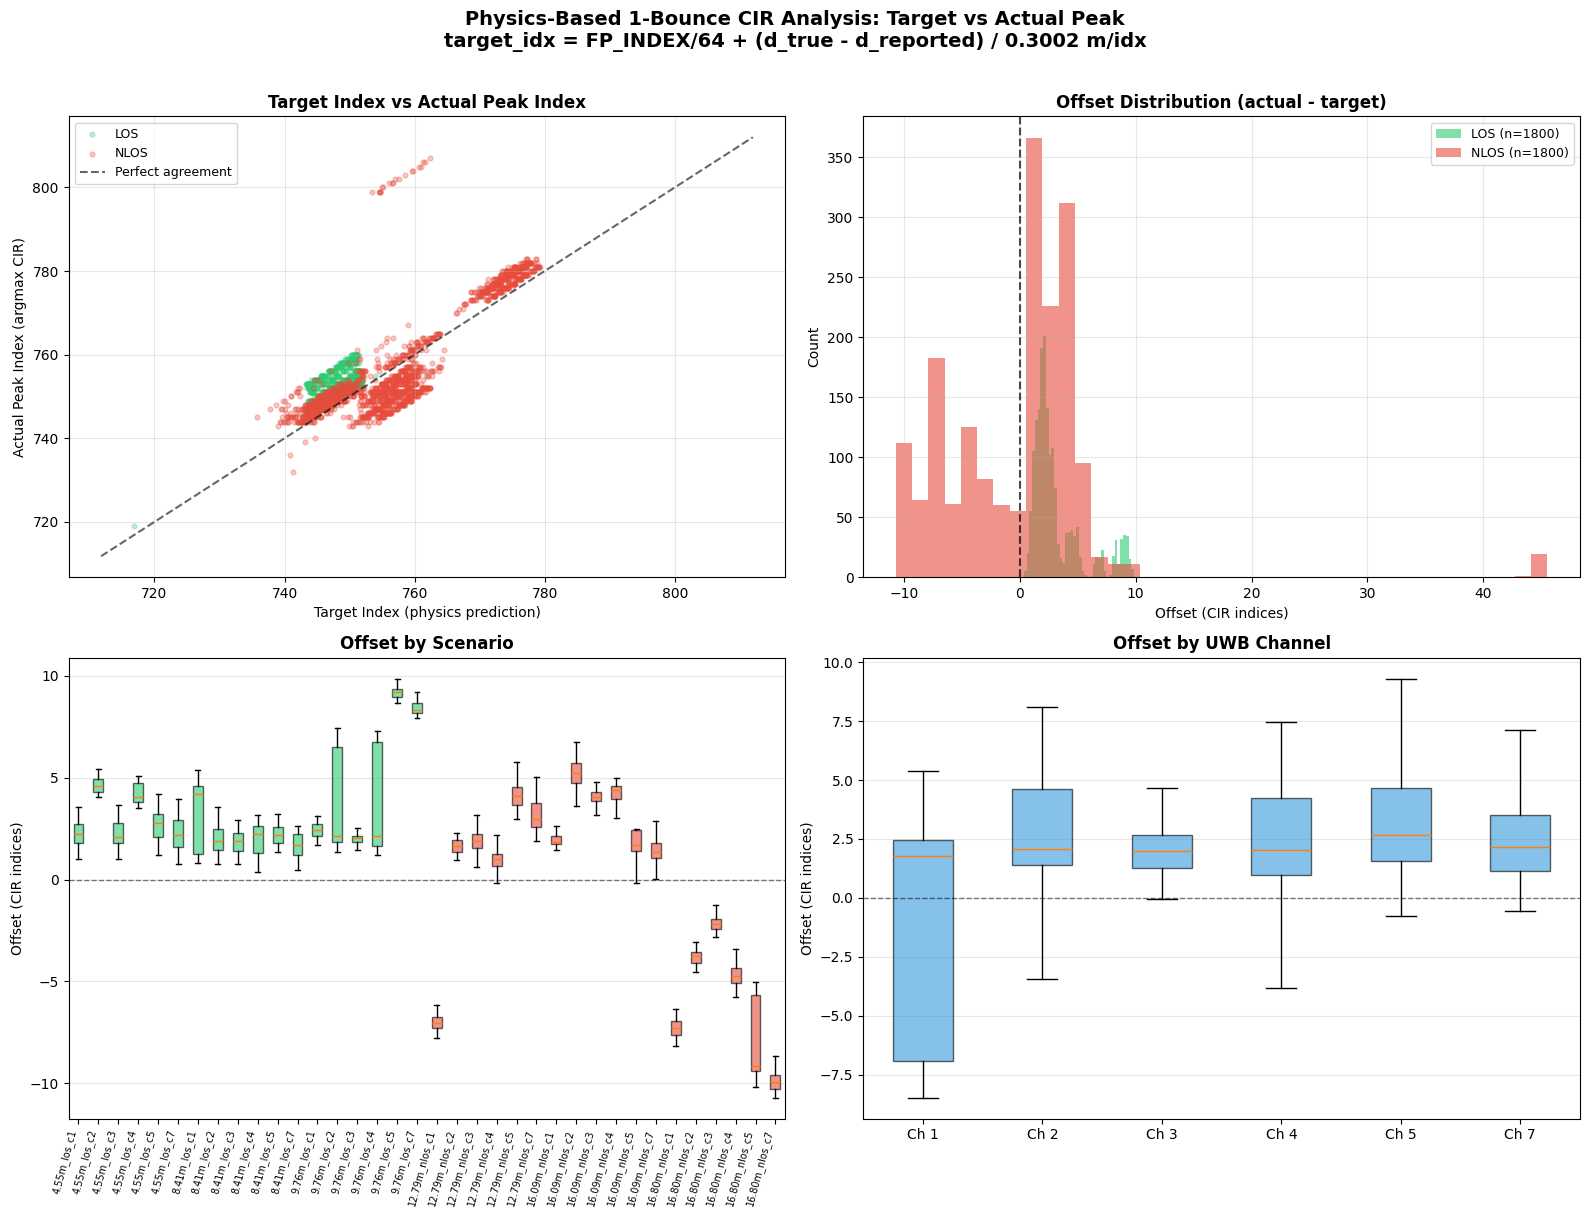

In [33]:
# ==========================================
# PHYSICS-BASED 1-BOUNCE CIR ANALYSIS
# ==========================================
# This analysis uses the DW1000 hardware anchor point (FP_INDEX) and the
# laser-measured ground-truth distance (encoded in each filename) to
# calculate exactly WHERE on the CIR waveform the single-bounce
# reflection SHOULD appear, then compares it to where the actual
# maximum-energy peak is.
#
# UWB PHYSICS BACKGROUND:
# -----------------------
# The DW1000 CIR accumulator records 1016 time-domain samples of the
# received impulse response. Each sample corresponds to one chip period
# of ~1.0016 ns. At the speed of light (c = 299,792,458 m/s), each CIR
# index spans approximately:
#
#   distance_per_index = c × 1.0016e-9 ≈ 0.3002 m
#
# The hardware provides FP_INDEX, a 16-bit register where the upper 10
# bits are the integer CIR sample index and the lower 6 bits are a
# fractional part (1/64 resolution). Dividing by 64.0 converts this to
# the floating-point CIR array index where the leading edge was detected.
#
# TIME-OF-FLIGHT OFFSET:
# ----------------------
# The hardware anchor (FP_INDEX/64) corresponds to the reported distance.
# If the true physical path is LONGER than what the hardware reports, the
# signal must have arrived LATER, meaning its CIR peak sits at a HIGHER
# index. The offset in CIR indices is:
#
#   target_idx = anchor_idx + (true_distance - reported_distance) / 0.3002
#
# For LOS:  true_distance ≈ reported_distance → target ≈ anchor (validates calibration)
# For NLOS: true_distance = d_bounce > reported_distance → target > anchor
#           This predicts exactly where the single-bounce reflection should land.
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re

# Speed-of-light constant: metres per CIR accumulator sample
# c × 1.0016 ns ≈ 0.3002 m one-way distance per CIR index
DIST_PER_CIR_INDEX = 0.3002

# ==========================================
# 1. FILE ITERATION & ROW-BY-ROW ANALYSIS
# ==========================================
results = []

all_csvs = sorted(glob.glob(os.path.join(CHANNEL_DIR, "*.csv")))

for filepath in all_csvs:
    basename = os.path.basename(filepath)

    # Skip the combined dataset (no distance prefix in filename)
    if basename == "combined_uwb_dataset.csv":
        continue

    # --- Parse ground-truth distance from filename ---
    # e.g. "16.09m_nlos_c1.csv" → 16.09, "4.55m_los_c1.csv" → 4.55
    dist_match = re.match(r'^([\d.]+)m', basename)
    if not dist_match:
        continue
    true_distance = float(dist_match.group(1))

    # --- Parse channel number ---
    ch_match = re.search(r'_c(\d+)\.csv', basename)
    if not ch_match:
        continue
    channel = int(ch_match.group(1))

    # --- Determine LOS vs NLOS from filename ---
    if '_nlos_' in basename:
        condition = 'NLOS'
    elif '_los_' in basename:
        condition = 'LOS'
    else:
        continue

    # --- Read CSV and extract CIR columns ---
    try:
        df = pd.read_csv(filepath)
    except Exception:
        continue

    cir_cols = sorted(
        [c for c in df.columns if c.startswith('CIR')],
        key=lambda x: int(x.replace('CIR', ''))
    )
    if not cir_cols:
        continue

    # --- Row-by-row physics computation ---
    for idx, row in df.iterrows():

        # STEP 1: Hardware anchor — convert DW1000 FP_INDEX (6-bit fractional)
        # to a floating-point CIR array index.
        # Example: FP_INDEX=48088 → 48088/64.0 = 751.375
        anchor_idx = float(row['FP_INDEX']) / 64.0

        # STEP 2: Hardware-reported distance (TWR result in metres)
        reported_distance = float(row['Distance'])

        # STEP 3: Calculate the theoretical 1-bounce target index.
        # The difference (true_distance - reported_distance) is the extra
        # path length in metres. Dividing by 0.3002 m/index converts to
        # CIR sample offset from the anchor.
        target_idx = anchor_idx + (true_distance - reported_distance) / DIST_PER_CIR_INDEX

        # STEP 4: Locate the actual signal energy peak.
        # Scan the FULL 1016-sample CIR waveform for the absolute maximum.
        cir_waveform = pd.to_numeric(row[cir_cols], errors='coerce').fillna(0).astype(float).values
        actual_peak_idx = int(np.argmax(cir_waveform))

        # STEP 5: Compute the offset between physics prediction and reality.
        # Positive offset = actual peak arrived LATER than predicted.
        offset = actual_peak_idx - target_idx

        results.append({
            'filename':          basename,
            'channel':           channel,
            'condition':         condition,
            'true_distance':     true_distance,
            'reported_distance': reported_distance,
            'anchor_idx':        anchor_idx,
            'target_idx':        target_idx,
            'actual_peak_idx':   actual_peak_idx,
            'offset':            offset,
        })

df_physics = pd.DataFrame(results)

# ==========================================
# 2. SUMMARY TABLE — Per-File Statistics
# ==========================================
print("=" * 110)
print("PHYSICS-BASED 1-BOUNCE CIR ANALYSIS — PER-FILE SUMMARY")
print("=" * 110)
print(f"{'Filename':<25} | {'Cond':<5} | {'Ch':>3} | {'Rows':>5} | "
      f"{'d_true':>7} | {'<anchor>':>9} | {'<target>':>9} | {'<peak>':>7} | "
      f"{'<offset>':>9} | {'std(off)':>9}")
print("-" * 110)

# Sort by condition (LOS first), then true_distance, then channel
file_groups = df_physics.groupby(['filename', 'condition', 'channel', 'true_distance'], sort=False)
summary_rows = []
for (fname, cond, ch, d_true), grp in file_groups:
    summary_rows.append({
        'filename': fname, 'condition': cond, 'channel': ch,
        'true_distance': d_true, 'count': len(grp),
        'mean_anchor': grp['anchor_idx'].mean(),
        'mean_target': grp['target_idx'].mean(),
        'mean_peak':   grp['actual_peak_idx'].mean(),
        'mean_offset': grp['offset'].mean(),
        'std_offset':  grp['offset'].std(),
    })

df_summary = pd.DataFrame(summary_rows).sort_values(
    by=['condition', 'true_distance', 'channel'],
    ascending=[True, True, True]  # LOS before NLOS alphabetically
)

for _, r in df_summary.iterrows():
    print(f"{r['filename']:<25} | {r['condition']:<5} | c{r['channel']:>1} | {r['count']:>5} | "
          f"{r['true_distance']:>7.2f} | {r['mean_anchor']:>9.1f} | {r['mean_target']:>9.1f} | "
          f"{r['mean_peak']:>7.1f} | {r['mean_offset']:>+9.2f} | {r['std_offset']:>9.3f}")

# ==========================================
# 3. AGGREGATE STATISTICS — LOS vs NLOS
# ==========================================
print(f"\n{'=' * 110}")
print("AGGREGATE STATISTICS BY CONDITION")
print(f"{'=' * 110}")
print(f"{'Condition':<10} | {'Count':>6} | {'Mean Offset':>12} | {'Std Offset':>11} | "
      f"{'MAE':>8} | {'RMSE':>8}")
print(f"{'-' * 70}")

for cond in ['LOS', 'NLOS']:
    mask = df_physics['condition'] == cond
    if mask.sum() == 0:
        continue
    offsets = df_physics.loc[mask, 'offset']
    mae  = offsets.abs().mean()
    rmse = np.sqrt((offsets ** 2).mean())
    print(f"{cond:<10} | {mask.sum():>6} | {offsets.mean():>+12.4f} | {offsets.std():>11.4f} | "
          f"{mae:>8.4f} | {rmse:>8.4f}")

# Overall
all_offsets = df_physics['offset']
overall_mae  = all_offsets.abs().mean()
overall_rmse = np.sqrt((all_offsets ** 2).mean())
print(f"{'-' * 70}")
print(f"{'OVERALL':<10} | {len(df_physics):>6} | {all_offsets.mean():>+12.4f} | {all_offsets.std():>11.4f} | "
      f"{overall_mae:>8.4f} | {overall_rmse:>8.4f}")

print(f"\nTotal rows processed: {len(df_physics)}")
print(f"  Offset unit: CIR indices (1 index ≈ {DIST_PER_CIR_INDEX} m)")
print(f"  Offset sign: positive = actual peak arrived LATER than physics prediction")

# ==========================================
# 4. VISUALIZATION — 2×2 Analysis Grid
# ==========================================
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.35, wspace=0.3)

COLOR_LOS  = '#2ecc71'
COLOR_NLOS = '#e74c3c'

los_mask  = df_physics['condition'] == 'LOS'
nlos_mask = df_physics['condition'] == 'NLOS'

# --- (0,0) Scatter: target_idx vs actual_peak_idx ---
ax = axs[0, 0]
if los_mask.any():
    ax.scatter(df_physics.loc[los_mask, 'target_idx'],
               df_physics.loc[los_mask, 'actual_peak_idx'],
               alpha=0.3, s=12, color=COLOR_LOS, label='LOS')
if nlos_mask.any():
    ax.scatter(df_physics.loc[nlos_mask, 'target_idx'],
               df_physics.loc[nlos_mask, 'actual_peak_idx'],
               alpha=0.3, s=12, color=COLOR_NLOS, label='NLOS')
all_vals = np.concatenate([df_physics['target_idx'].values, df_physics['actual_peak_idx'].values])
lims = [np.min(all_vals) - 5, np.max(all_vals) + 5]
ax.plot(lims, lims, 'k--', lw=1.5, alpha=0.6, label='Perfect agreement')
ax.set_xlabel("Target Index (physics prediction)")
ax.set_ylabel("Actual Peak Index (argmax CIR)")
ax.set_title("Target Index vs Actual Peak Index", fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# --- (0,1) Histogram: offset distribution by condition ---
ax = axs[0, 1]
if los_mask.any():
    ax.hist(df_physics.loc[los_mask, 'offset'], bins=40, alpha=0.6,
            color=COLOR_LOS, label=f'LOS (n={los_mask.sum()})')
if nlos_mask.any():
    ax.hist(df_physics.loc[nlos_mask, 'offset'], bins=40, alpha=0.6,
            color=COLOR_NLOS, label=f'NLOS (n={nlos_mask.sum()})')
ax.axvline(0, color='black', ls='--', lw=1.5, alpha=0.7)
ax.set_xlabel("Offset (CIR indices)")
ax.set_ylabel("Count")
ax.set_title("Offset Distribution (actual - target)", fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# --- (1,0) Box plot: offset grouped by filename ---
ax = axs[1, 0]
# Sort filenames by (condition, true_distance) for logical ordering
file_order = df_summary.sort_values(['condition', 'true_distance', 'channel'])['filename'].values
boxplot_data = [df_physics.loc[df_physics['filename'] == fn, 'offset'].values for fn in file_order]
boxplot_colors = [COLOR_LOS if '_los_' in fn else COLOR_NLOS for fn in file_order]

bp = ax.boxplot(boxplot_data, patch_artist=True, showfliers=False)
for patch, color in zip(bp['boxes'], boxplot_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax.axhline(0, color='black', ls='--', lw=1, alpha=0.5)
ax.set_xticklabels([fn.replace('.csv', '') for fn in file_order],
                    rotation=75, ha='right', fontsize=7)
ax.set_ylabel("Offset (CIR indices)")
ax.set_title("Offset by Scenario", fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# --- (1,1) Box plot: offset grouped by UWB channel ---
ax = axs[1, 1]
channels_sorted = sorted(df_physics['channel'].unique())
ch_data = [df_physics.loc[df_physics['channel'] == ch, 'offset'].values for ch in channels_sorted]
bp2 = ax.boxplot(ch_data, patch_artist=True, showfliers=False)
for patch in bp2['boxes']:
    patch.set_facecolor('#3498db')
    patch.set_alpha(0.6)
ax.axhline(0, color='black', ls='--', lw=1, alpha=0.5)
ax.set_xticklabels([f'Ch {ch}' for ch in channels_sorted], fontsize=10)
ax.set_ylabel("Offset (CIR indices)")
ax.set_title("Offset by UWB Channel", fontweight='bold')
ax.grid(axis='y', alpha=0.3)

fig.suptitle(
    "Physics-Based 1-Bounce CIR Analysis: Target vs Actual Peak\n"
    f"target_idx = FP_INDEX/64 + (d_true - d_reported) / {DIST_PER_CIR_INDEX} m/idx",
    fontsize=14, fontweight='bold', y=1.01
)
plt.tight_layout()
plt.show()

*Visualization moved into ground-truth labeling cell below.*

Loaded 3600 rows from combined_uwb_dataset.csv
Columns: 1027 (1016 CIR + 11 metadata)

GROUND-TRUTH PATH LABELING — PER-SCENARIO SUMMARY
Formula: los_path_idx = FP_INDEX/64 + (d_direct - Distance) / 0.3002
Source Pattern         | Cond  | d_direct | d_bounce |  <los_idx> | <bounce_idx> |  <fp_idx> |  <fp-los> |  <peak>
------------------------------------------------------------------------------------------------------------------------
4.55m_los_c*           | LOS   |     4.55 |      N/A |     747.53 |          N/A
7.79m_nlos_c*          | NLOS  |     7.79 |    12.79 |     731.37 |       748.03 |    744.52 |    +13.15 |   748.8
8.41m_los_c*           | LOS   |     8.41 |      N/A |     748.04 |          N/A
9.76m_los_c*           | LOS   |     9.76 |      N/A |     747.21 |          N/A
10.77m_nlos_c*         | NLOS  |    10.77 |    16.09 |     749.18 |       766.90 |    743.14 |     -6.04 |   770.2
14m_nlos_c*            | NLOS  |    14.00 |    16.80 |     747.49 |       756.82 |   

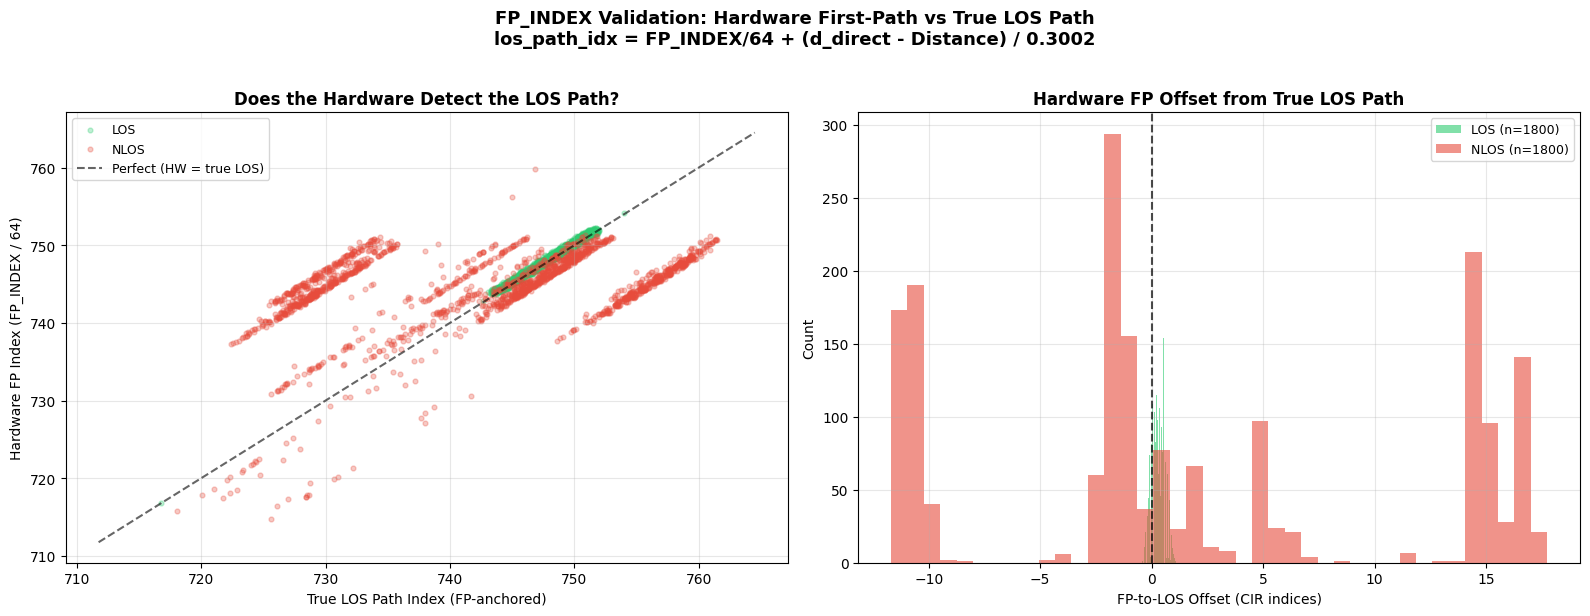

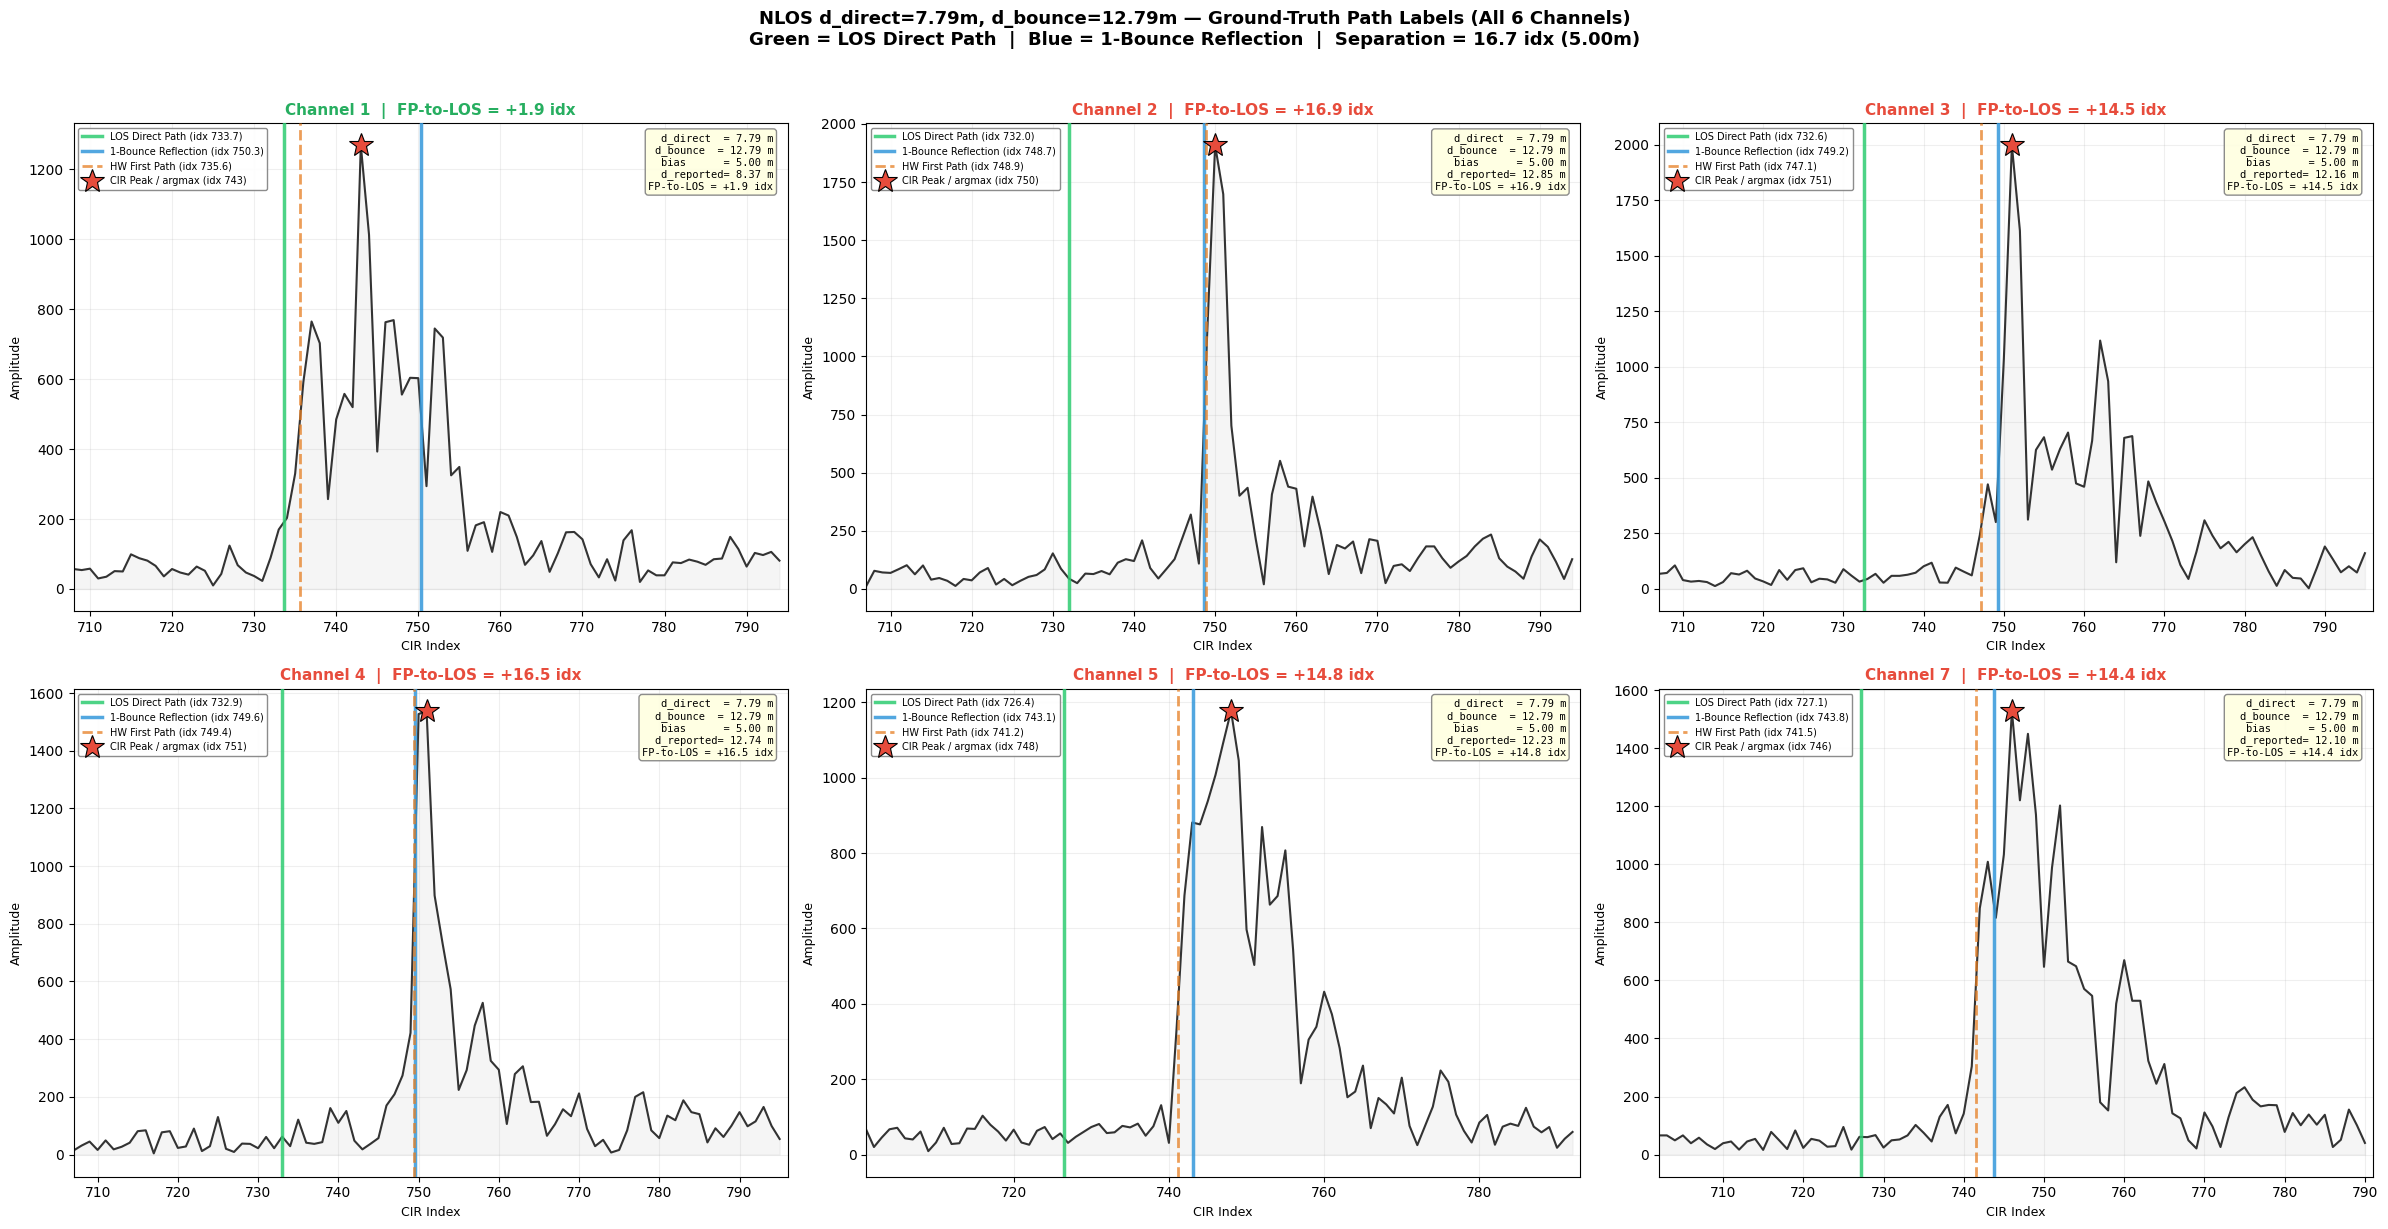

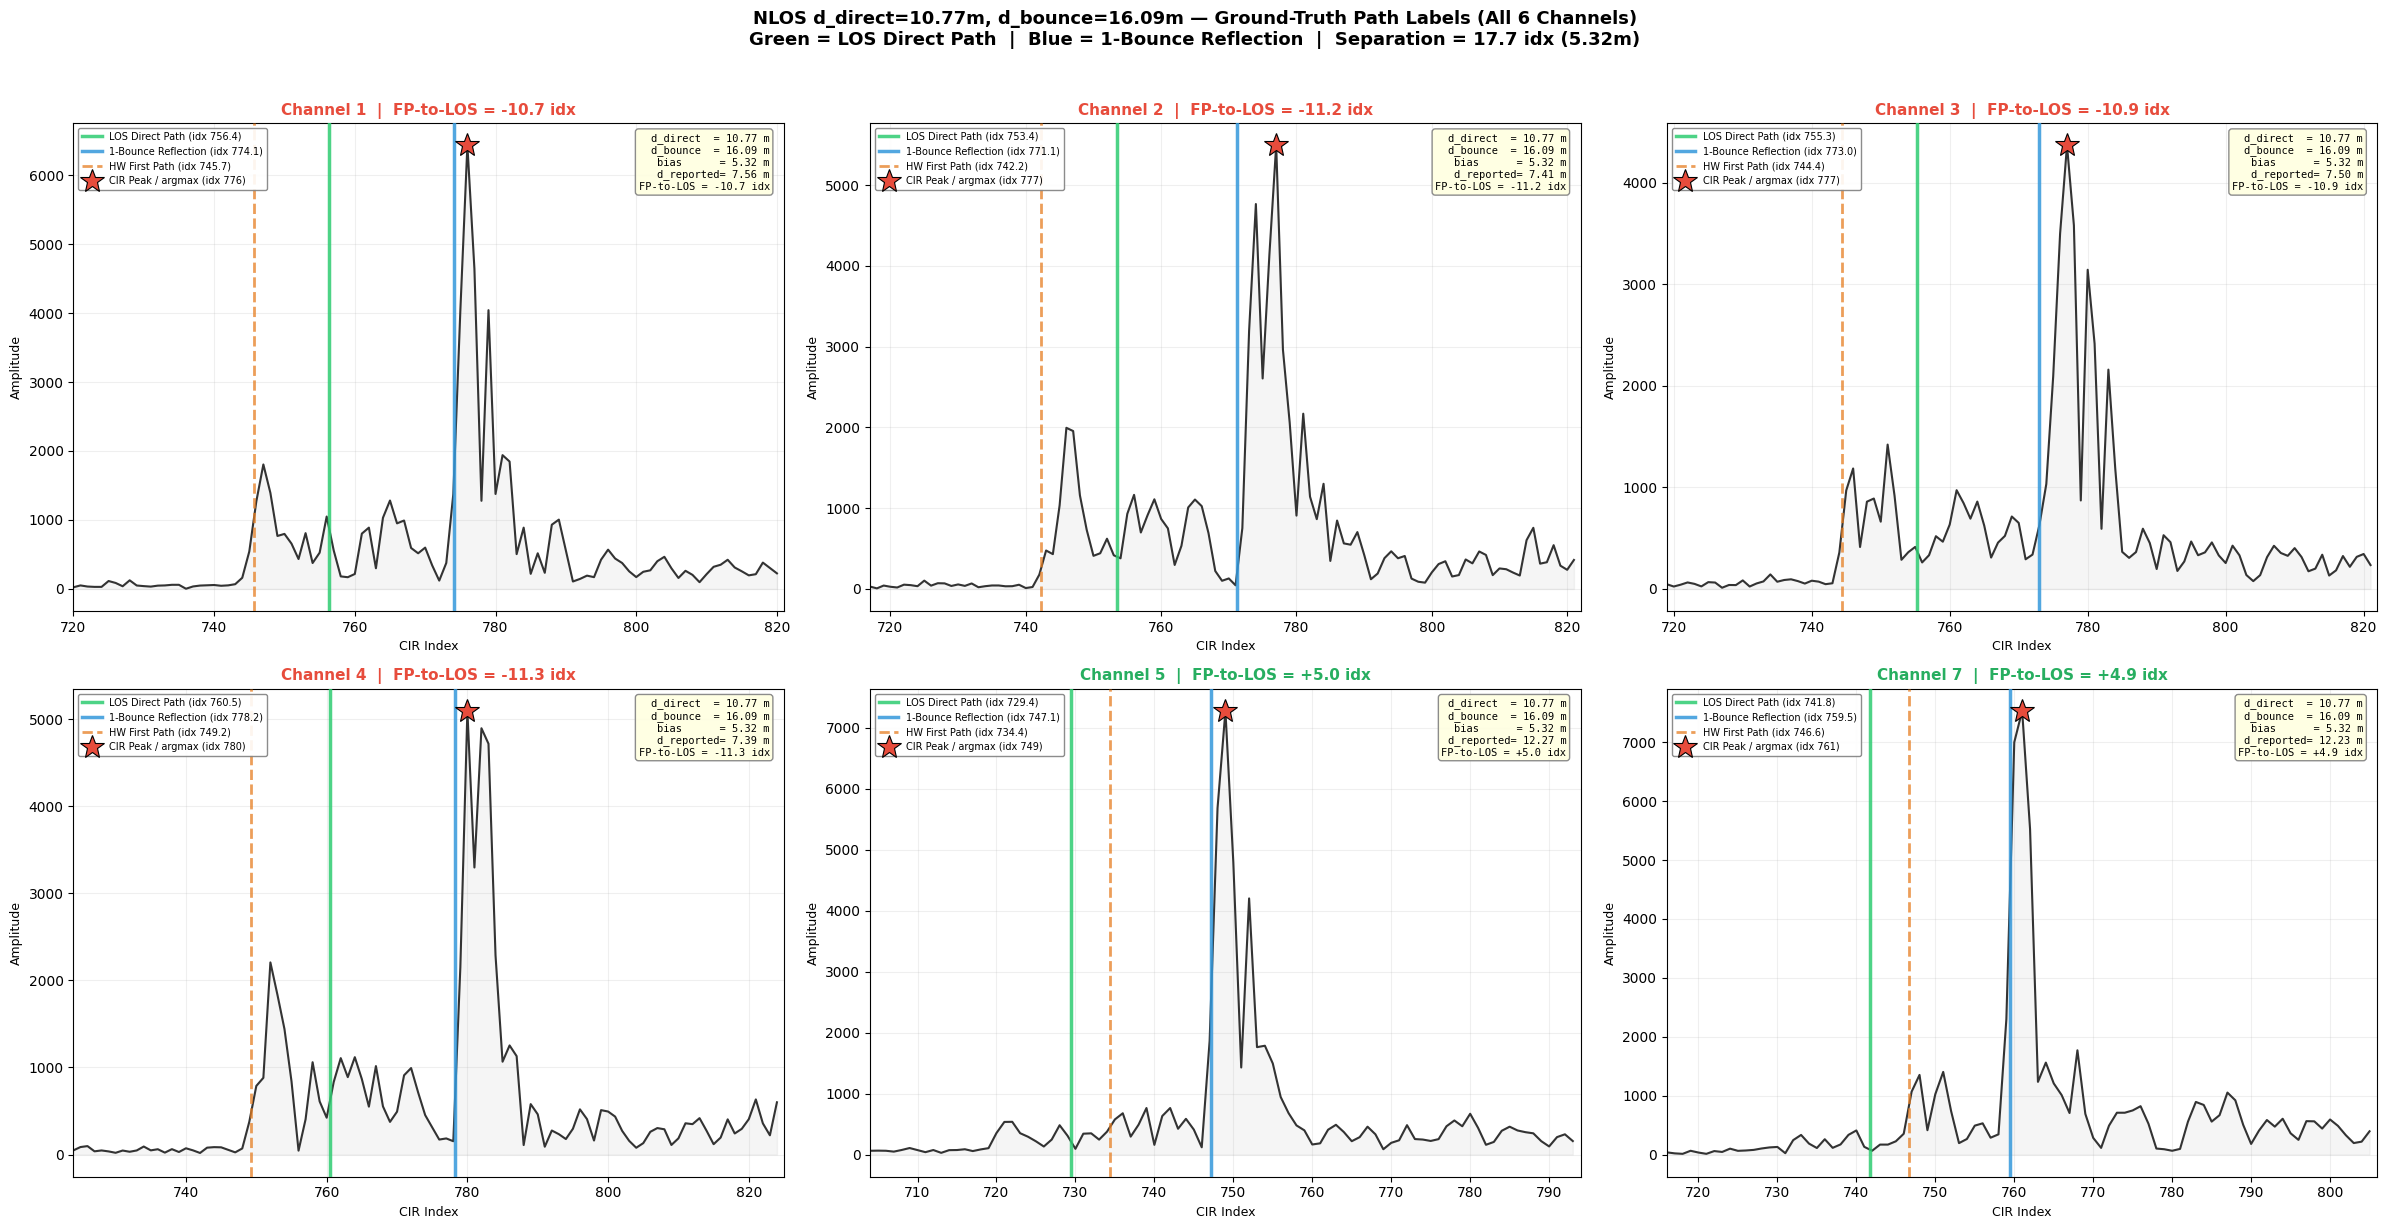

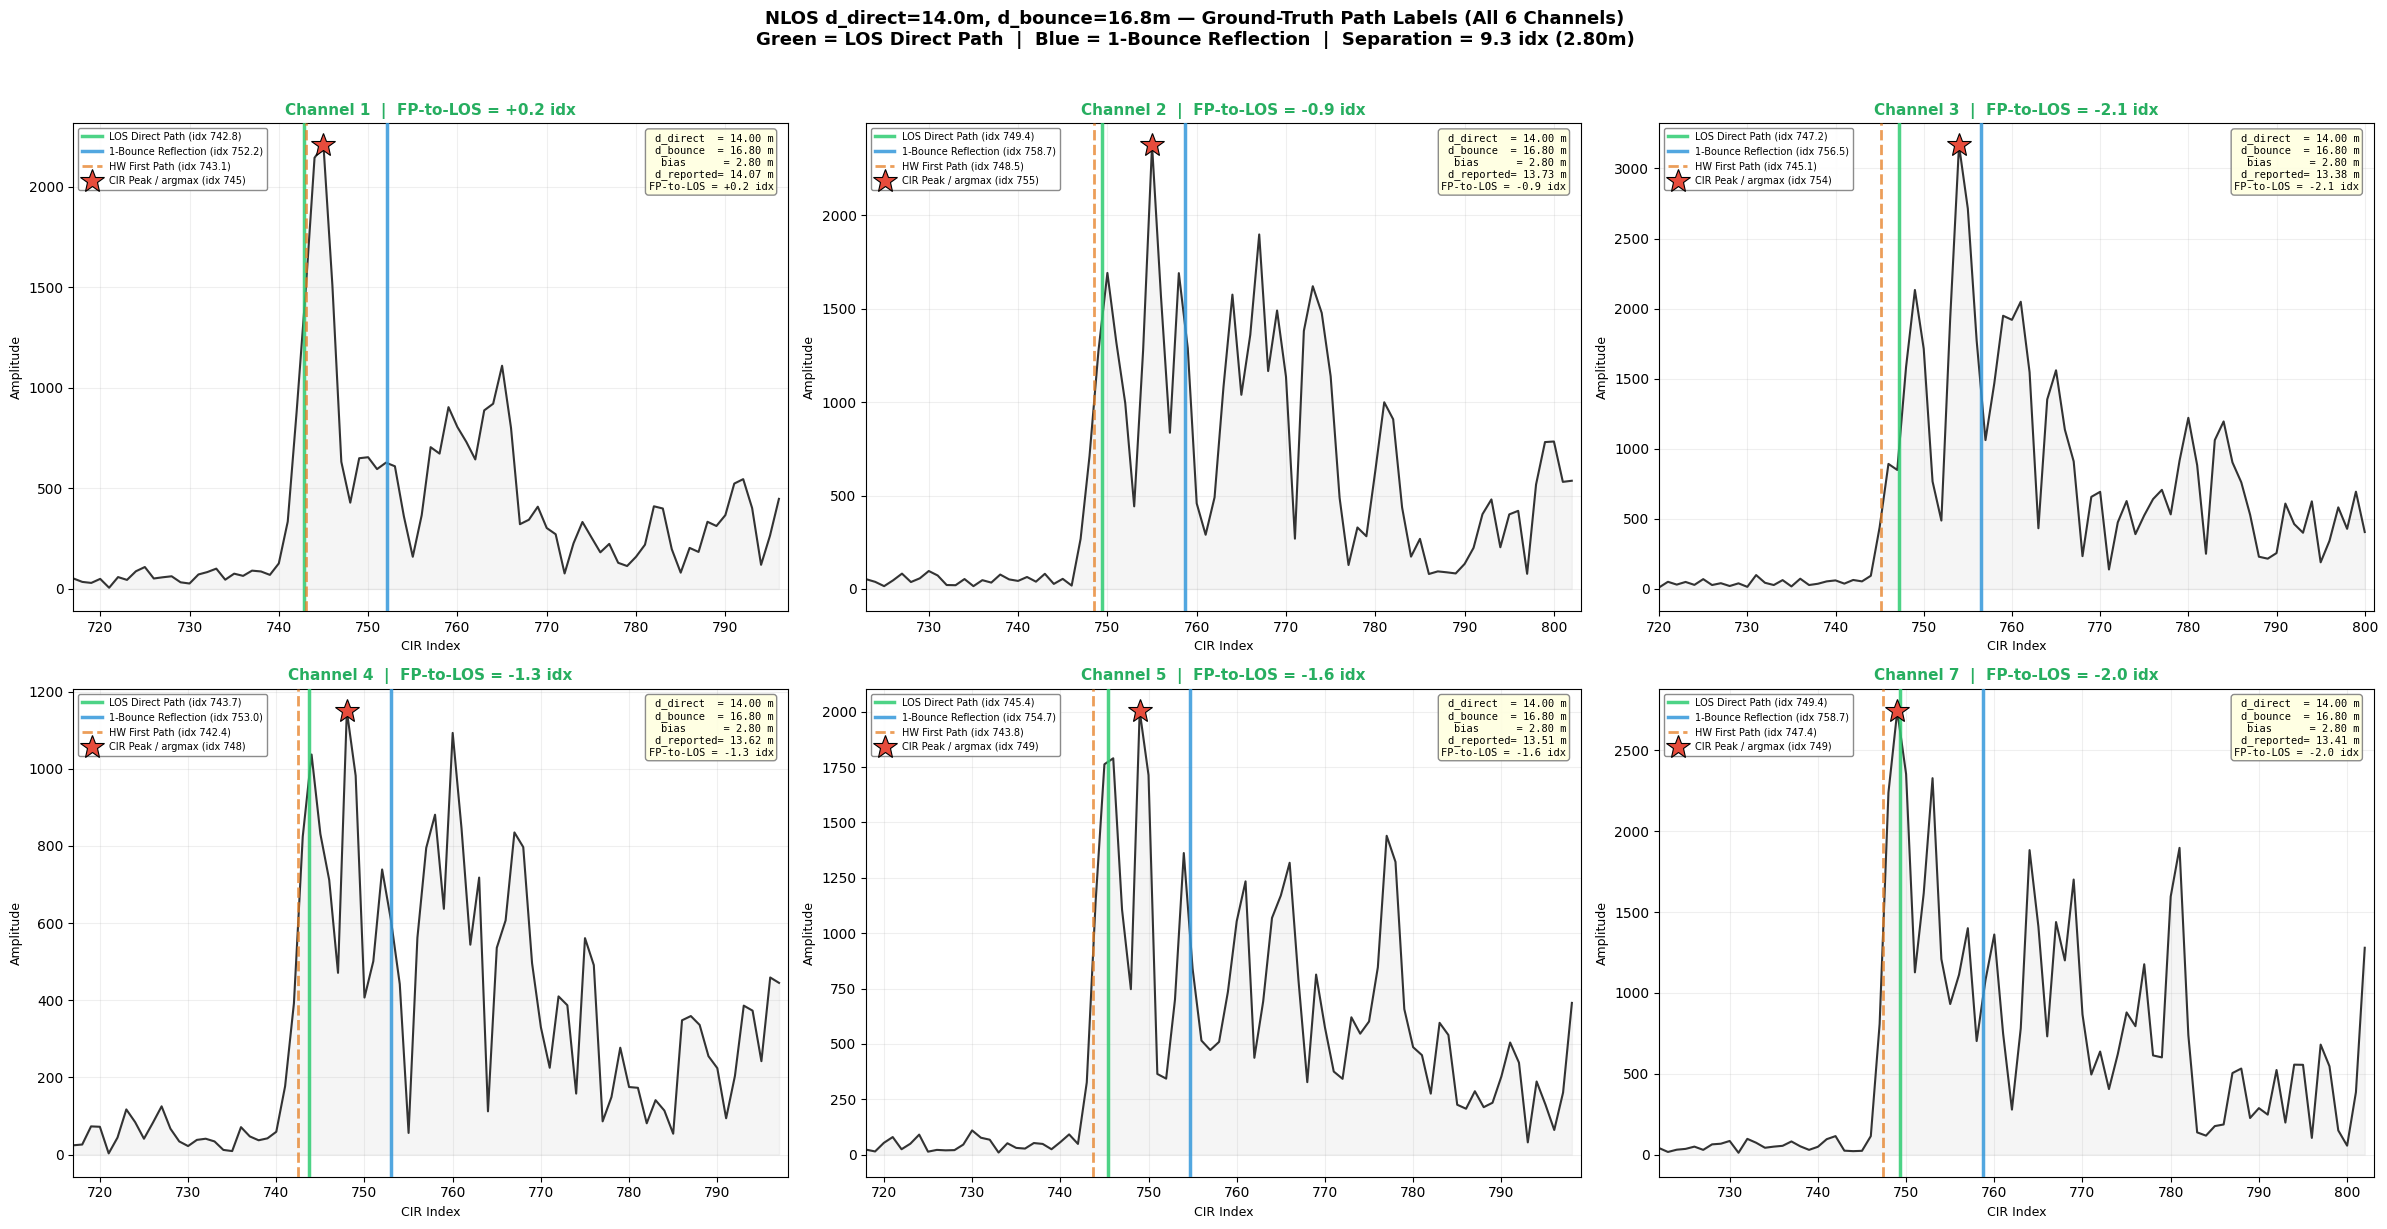


Labeling complete. New columns added to df_combined:
  d_direct, d_bounce, los_path_idx, bounce_path_idx, fp_idx,
  fp_to_los_offset, peak_idx, channel, cir_at_los_path

Formula used (FP-anchored, same as physics analysis above):
  los_path_idx    = FP_INDEX/64 + (d_direct - Distance) / 0.3002
  bounce_path_idx = FP_INDEX/64 + (d_bounce - Distance) / 0.3002


In [34]:
# ==========================================
# GROUND-TRUTH PATH LABELING & FP VALIDATION
# ==========================================
# For every UWB measurement, compute the CIR index where the LOS (direct)
# path and the 1-Bounce (reflected) path physically arrive, using the
# hardware FP_INDEX anchor and the laser-measured ground-truth distances.
#
# FP-ANCHORED FORMULA (same approach as cell above):
#   fp_idx          = FP_INDEX / 64.0
#   los_path_idx    = fp_idx + (d_direct - Distance) / 0.3002
#   bounce_path_idx = fp_idx + (d_bounce - Distance) / 0.3002   (NLOS only)
#
# Why FP-relative and NOT absolute?
# The DW1000 dynamically shifts its CIR accumulator receive window so the
# leading edge always lands near index ~746, regardless of actual distance.
# FP_INDEX/64 is approximately constant across all distances (4.55m-14m).
# An absolute formula (739.3 + d/0.3002) would place markers 20-40 indices
# away from the real signal — visibly wrong on the CIR plot.
#
# The FP-anchored approach is correct because:
#   - FP_INDEX/64 corresponds to the hardware-reported "Distance"
#   - The DIFFERENCE (d_direct - Distance) converts to a CIR index offset
#   - For LOS: d_direct ≈ Distance → los_path_idx ≈ fp_idx (validated)
#   - For NLOS: d_bounce > Distance → bounce_path_idx > fp_idx
#
# FP_AMPL1/2/3 VALIDATION:
# The DW1000 reports three amplitude samples (F1, F2, F3) at/around the
# hardware-detected first path. If |fp_idx - los_path_idx| is small, then
# F1/F2/F3 faithfully represent the LOS signal. If the offset is large,
# the hardware was fooled by a reflection.
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

# ==========================================
# 1. CONSTANTS & GROUND-TRUTH LOOKUP
# ==========================================

DIST_PER_CIR_INDEX = 0.3002  # metres per CIR sample (c × 1.0016 ns)

# Ground truth: d_direct prefix (as used in combined_uwb_dataset.csv Source_File)
# maps to (d_direct, d_bounce) in metres.
# The combined CSV uses d_direct naming for NLOS: 7.79m, 10.77m, 14m
NLOS_GROUND_TRUTH = {
    "7.79":  {"d_direct": 7.79,  "d_bounce": 12.79},
    "10.77": {"d_direct": 10.77, "d_bounce": 16.09},
    "14":    {"d_direct": 14.00, "d_bounce": 16.80},
}

# ==========================================
# 2. LOAD DATA & COMPUTE LABELS
# ==========================================
filepath = os.path.join(CHANNEL_DIR, "combined_uwb_dataset.csv")
df_combined = pd.read_csv(filepath)

cir_cols = sorted(
    [c for c in df_combined.columns if c.startswith('CIR')],
    key=lambda x: int(x.replace('CIR', ''))
)

# Drop old label columns if they exist (from previous buggy export)
old_label_cols = ['d_direct', 'd_bounce', 'los_path_idx', 'bounce_path_idx',
                  'fp_idx', 'fp_to_los_offset', 'peak_idx', 'channel', 'cir_at_los_path']
for col in old_label_cols:
    if col in df_combined.columns:
        df_combined.drop(columns=[col], inplace=True)

print(f"Loaded {len(df_combined)} rows from combined_uwb_dataset.csv")
print(f"Columns: {len(df_combined.columns)} ({len(cir_cols)} CIR + {len(df_combined.columns) - len(cir_cols)} metadata)")

# --- Parse Source_File → d_direct, d_bounce ---
d_direct_list = []
d_bounce_list = []

for _, row in df_combined.iterrows():
    fname = str(row['Source_File'])
    prefix_match = re.match(r'^([\d.]+)m', fname)
    if not prefix_match:
        d_direct_list.append(np.nan)
        d_bounce_list.append(np.nan)
        continue

    prefix = prefix_match.group(1)
    is_nlos = '_nlos_' in fname

    if is_nlos:
        # Combined CSV uses d_direct prefix for NLOS Source_File
        gt = NLOS_GROUND_TRUTH.get(prefix)
        if gt:
            d_direct_list.append(gt['d_direct'])
            d_bounce_list.append(gt['d_bounce'])
        else:
            d_direct_list.append(np.nan)
            d_bounce_list.append(np.nan)
    else:
        # LOS: prefix IS d_direct, no bounce path
        d_direct_list.append(float(prefix))
        d_bounce_list.append(np.nan)

df_combined['d_direct'] = d_direct_list
df_combined['d_bounce'] = d_bounce_list

# --- Hardware first-path position ---
df_combined['fp_idx'] = df_combined['FP_INDEX'] / 64.0

# --- Compute FP-anchored CIR indices ---
# los_path_idx: where the direct (LOS) signal physically arrives
# The offset from fp_idx is (d_direct - Distance) converted to CIR indices
df_combined['los_path_idx'] = (
    df_combined['fp_idx']
    + (df_combined['d_direct'] - df_combined['Distance']) / DIST_PER_CIR_INDEX
)

# bounce_path_idx: where the single-bounce reflection arrives (NaN for LOS)
df_combined['bounce_path_idx'] = (
    df_combined['fp_idx']
    + (df_combined['d_bounce'] - df_combined['Distance']) / DIST_PER_CIR_INDEX
)

# --- FP-to-LOS offset: how far the hardware is from the true direct path ---
df_combined['fp_to_los_offset'] = df_combined['fp_idx'] - df_combined['los_path_idx']

# --- Actual CIR peak (argmax) ---
cir_matrix = df_combined[cir_cols].values.astype(float)
df_combined['peak_idx'] = np.argmax(cir_matrix, axis=1)

# --- Parse channel number for convenience ---
df_combined['channel'] = df_combined['Source_File'].apply(
    lambda x: int(re.search(r'_c(\d+)\.csv', str(x)).group(1))
    if re.search(r'_c(\d+)\.csv', str(x)) else None
)

# ==========================================
# 3. SUMMARY TABLE — Per-Scenario Statistics
# ==========================================
print(f"\n{'=' * 120}")
print("GROUND-TRUTH PATH LABELING — PER-SCENARIO SUMMARY")
print(f"Formula: los_path_idx = FP_INDEX/64 + (d_direct - Distance) / {DIST_PER_CIR_INDEX}")
print(f"{'=' * 120}")
print(f"{'Source Pattern':<22} | {'Cond':<5} | {'d_direct':>8} | {'d_bounce':>8} | "
      f"{'<los_idx>':>10} | {'<bounce_idx>':>12} | {'<fp_idx>':>9} | "
      f"{'<fp-los>':>9} | {'<peak>':>7}")
print(f"{'-' * 120}")

# Group by scenario (unique d_direct + condition)
scenario_groups = df_combined.groupby(
    ['d_direct', 'Label'],
    sort=True
)

for (d_dir, label), grp in scenario_groups:
    cond = 'NLOS' if label == 1 else 'LOS'
    d_bnc = grp['d_bounce'].iloc[0]
    d_bnc_str = f"{d_bnc:.2f}" if not np.isnan(d_bnc) else "  N/A"
    pattern = grp['Source_File'].iloc[0].rsplit('_c', 1)[0] + '_c*'

    print(f"{pattern:<22} | {cond:<5} | {d_dir:>8.2f} | {d_bnc_str:>8} | "
          f"{grp['los_path_idx'].mean():>10.2f} | "
          f"{'N/A':>12}" if np.isnan(d_bnc) else
          f"{pattern:<22} | {cond:<5} | {d_dir:>8.2f} | {d_bnc_str:>8} | "
          f"{grp['los_path_idx'].mean():>10.2f} | "
          f"{grp['bounce_path_idx'].mean():>12.2f}"
          f" | {grp['fp_idx'].mean():>9.2f} | "
          f"{grp['fp_to_los_offset'].mean():>+9.2f} | "
          f"{grp['peak_idx'].mean():>7.1f}")

# ==========================================
# 4. FP_AMPL VALIDATION — Does hardware detect the LOS path?
# ==========================================
print(f"\n{'=' * 120}")
print("FP-TO-LOS PROXIMITY ANALYSIS")
print("Question: How often does the hardware first-path (FP_INDEX/64) land near the true LOS path?")
print(f"{'=' * 120}")

thresholds = [1, 2, 3, 5, 10]

for cond_label, cond_name in [(0, 'LOS'), (1, 'NLOS')]:
    subset = df_combined[df_combined['Label'] == cond_label]
    n = len(subset)
    offsets = subset['fp_to_los_offset'].abs()

    print(f"\n  {cond_name} (n={n}):")
    print(f"    Mean |fp - los_path| = {offsets.mean():.2f} indices ({offsets.mean() * DIST_PER_CIR_INDEX:.2f} m)")
    print(f"    Std  |fp - los_path| = {offsets.std():.2f} indices")
    for t in thresholds:
        pct = 100 * (offsets <= t).sum() / n
        print(f"    |offset| <= {t:>2} idx ({t * DIST_PER_CIR_INDEX:.2f}m):  "
              f"{(offsets <= t).sum():>5}/{n}  ({pct:>5.1f}%)")

# --- F1/F2/F3 amplitude comparison ---
print(f"\n{'=' * 120}")
print("F1/F2/F3 vs CIR AMPLITUDE AT TRUE LOS PATH")
print("Compares hardware first-path amplitudes to the CIR value at los_path_idx")
print(f"{'=' * 120}")

# Extract CIR amplitude at the true LOS path index (nearest integer)
los_int_idx = df_combined['los_path_idx'].round().astype(int).clip(0, len(cir_cols) - 1)
cir_at_los = cir_matrix[np.arange(len(df_combined)), los_int_idx.values]
df_combined['cir_at_los_path'] = cir_at_los

for cond_label, cond_name in [(0, 'LOS'), (1, 'NLOS')]:
    subset = df_combined[df_combined['Label'] == cond_label]
    print(f"\n  {cond_name}:")
    print(f"    Mean FP_AMPL2 (HW first-path amp)     = {subset['FP_AMPL2'].mean():>8.1f}")
    print(f"    Mean CIR[los_path_idx] (true LOS amp)  = {subset['cir_at_los_path'].mean():>8.1f}")
    if subset['FP_AMPL2'].mean() > 0:
        ratio = subset['cir_at_los_path'].mean() / subset['FP_AMPL2'].mean()
        print(f"    Ratio (CIR@LOS / FP_AMPL2)            = {ratio:>8.3f}")

# ==========================================
# 5. VISUALIZATION — FP vs LOS Path Validation
# ==========================================
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

COLOR_LOS = '#2ecc71'
COLOR_NLOS = '#e74c3c'
los_mask = df_combined['Label'] == 0
nlos_mask = df_combined['Label'] == 1

# --- (0) Scatter: fp_idx vs los_path_idx ---
ax = axs[0]
if los_mask.any():
    ax.scatter(df_combined.loc[los_mask, 'los_path_idx'],
               df_combined.loc[los_mask, 'fp_idx'],
               alpha=0.3, s=12, color=COLOR_LOS, label='LOS')
if nlos_mask.any():
    ax.scatter(df_combined.loc[nlos_mask, 'los_path_idx'],
               df_combined.loc[nlos_mask, 'fp_idx'],
               alpha=0.3, s=12, color=COLOR_NLOS, label='NLOS')
all_vals = np.concatenate([df_combined['los_path_idx'].values, df_combined['fp_idx'].values])
lims = [np.nanmin(all_vals) - 3, np.nanmax(all_vals) + 3]
ax.plot(lims, lims, 'k--', lw=1.5, alpha=0.6, label='Perfect (HW = true LOS)')
ax.set_xlabel("True LOS Path Index (FP-anchored)")
ax.set_ylabel("Hardware FP Index (FP_INDEX / 64)")
ax.set_title("Does the Hardware Detect the LOS Path?", fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# --- (1) Histogram: fp_to_los_offset ---
ax = axs[1]
if los_mask.any():
    ax.hist(df_combined.loc[los_mask, 'fp_to_los_offset'], bins=40, alpha=0.6,
            color=COLOR_LOS, label=f'LOS (n={los_mask.sum()})')
if nlos_mask.any():
    ax.hist(df_combined.loc[nlos_mask, 'fp_to_los_offset'], bins=40, alpha=0.6,
            color=COLOR_NLOS, label=f'NLOS (n={nlos_mask.sum()})')
ax.axvline(0, color='black', ls='--', lw=1.5, alpha=0.7)
ax.set_xlabel("FP-to-LOS Offset (CIR indices)")
ax.set_ylabel("Count")
ax.set_title("Hardware FP Offset from True LOS Path", fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

fig.suptitle(
    "FP_INDEX Validation: Hardware First-Path vs True LOS Path\n"
    f"los_path_idx = FP_INDEX/64 + (d_direct - Distance) / {DIST_PER_CIR_INDEX}",
    fontsize=13, fontweight='bold', y=1.02
)
plt.tight_layout()
plt.show()

# ==========================================
# 6. PER-SCENARIO CIR WAVEFORMS WITH FP-ANCHORED LABELS
# ==========================================
# One figure per distance scenario, 2×3 grid (all 6 channels).
# Markers use FP-anchored indices (relative to hardware FP_INDEX).

CHANNELS = [1, 2, 3, 4, 5, 7]

# Get unique scenarios
scenarios = (
    df_combined
    .groupby(['d_direct', 'd_bounce', 'Label'])
    .first()
    .reset_index()
    .sort_values(['Label', 'd_direct'])
)

for _, sc in scenarios.iterrows():
    d_dir = sc['d_direct']
    d_bnc = sc['d_bounce']
    label = sc['Label']
    cond = 'LOS' if label == 0 else 'NLOS'

    if cond == 'LOS':
        suptitle = (f"LOS d_direct={d_dir}m — Ground-Truth Path Labels (All 6 Channels)\n"
                    f"Green = LOS Direct Path  |  No bounce path in LOS")
    else:
        bias_m = d_bnc - d_dir
        bias_idx = bias_m / DIST_PER_CIR_INDEX
        suptitle = (f"NLOS d_direct={d_dir}m, d_bounce={d_bnc}m — Ground-Truth Path Labels (All 6 Channels)\n"
                    f"Green = LOS Direct Path  |  Blue = 1-Bounce Reflection  |  "
                    f"Separation = {bias_idx:.1f} idx ({bias_m:.2f}m)")

    fig, axs = plt.subplots(2, 3, figsize=(24, 12))
    axs_flat = axs.flatten()

    for ch_idx, ch in enumerate(CHANNELS):
        ax = axs_flat[ch_idx]

        # Get rows for this scenario + channel
        ch_rows = df_combined[
            (df_combined['d_direct'] == d_dir) &
            (df_combined['Label'] == label) &
            (df_combined['channel'] == ch)
        ]

        if len(ch_rows) == 0:
            ax.text(0.5, 0.5, f"No data for Ch {ch}",
                    ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(f"Channel {ch} — No Data", fontsize=11)
            continue

        # Pick median-offset sample (by fp_to_los_offset)
        median_off = ch_rows['fp_to_los_offset'].median()
        pick_idx = (ch_rows['fp_to_los_offset'] - median_off).abs().idxmin()
        pick = ch_rows.loc[pick_idx]

        # Extract CIR waveform
        cir = cir_matrix[pick_idx]

        # Physics values (now FP-anchored, so markers sit on the signal)
        los_idx  = pick['los_path_idx']
        bnc_idx  = pick['bounce_path_idx']  # NaN for LOS
        fp       = pick['fp_idx']
        peak     = int(pick['peak_idx'])
        fp_off   = pick['fp_to_los_offset']
        d_rep    = pick['Distance']

        # --- Zoom window ---
        markers = [los_idx, fp, peak]
        if not np.isnan(bnc_idx):
            markers.append(bnc_idx)
        win_start = int(max(0, min(markers) - 25))
        win_end   = int(min(len(cir), max(markers) + 45))
        x = np.arange(win_start, win_end)
        y = cir[win_start:win_end]
        y_top = np.max(y) if np.max(y) > 0 else 1

        # --- CIR waveform ---
        ax.plot(x, y, color='#333', lw=1.5, zorder=2)
        ax.fill_between(x, 0, y, color='gray', alpha=0.08)

        # ---- MARKER 1: LOS Direct Path (green solid) ----
        ax.axvline(los_idx, color='#2ecc71', ls='-', lw=2.5, alpha=0.85,
                   label=f'LOS Direct Path (idx {los_idx:.1f})', zorder=3)

        # ---- MARKER 2: 1-Bounce Reflection (blue solid, NLOS only) ----
        if not np.isnan(bnc_idx):
            ax.axvline(bnc_idx, color='#3498db', ls='-', lw=2.5, alpha=0.85,
                       label=f'1-Bounce Reflection (idx {bnc_idx:.1f})', zorder=3)

        # ---- MARKER 3: HW First Path (orange dashed) ----
        ax.axvline(fp, color='#e67e22', ls='--', lw=2, alpha=0.75,
                   label=f'HW First Path (idx {fp:.1f})', zorder=3)

        # ---- MARKER 4: CIR Peak / argmax (red star) ----
        peak_amp = cir[peak] if 0 <= peak < len(cir) else 0
        ax.plot(peak, peak_amp, '*', color='#e74c3c', markersize=18,
                markeredgecolor='black', markeredgewidth=0.8,
                label=f'CIR Peak / argmax (idx {peak})', zorder=6)

        # --- Info box ---
        info_lines = [f"d_direct  = {d_dir:.2f} m"]
        if not np.isnan(d_bnc):
            info_lines.append(f"d_bounce  = {d_bnc:.2f} m")
            info_lines.append(f"bias      = {d_bnc - d_dir:.2f} m")
        info_lines.append(f"d_reported= {d_rep:.2f} m")
        info_lines.append(f"FP-to-LOS = {fp_off:+.1f} idx")
        info = '\n'.join(info_lines)
        ax.text(0.98, 0.98, info, transform=ax.transAxes,
                fontsize=7.5, family='monospace', va='top', ha='right',
                bbox=dict(facecolor='lightyellow', edgecolor='gray',
                          boxstyle='round,pad=0.3', alpha=0.9))

        # --- Formatting ---
        ax.set_xlim(win_start, win_end)
        ax.set_xlabel("CIR Index", fontsize=9)
        ax.set_ylabel("Amplitude", fontsize=9)
        title_color = '#27ae60' if abs(fp_off) < 5.0 else '#e74c3c'
        ax.set_title(f"Channel {ch}  |  FP-to-LOS = {fp_off:+.1f} idx",
                     fontsize=11, fontweight='bold', color=title_color)
        ax.legend(fontsize=7, loc='upper left', framealpha=0.9, edgecolor='gray')
        ax.grid(True, alpha=0.2)

    fig.suptitle(suptitle, fontsize=13, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

print(f"\nLabeling complete. New columns added to df_combined:")
print(f"  d_direct, d_bounce, los_path_idx, bounce_path_idx, fp_idx,")
print(f"  fp_to_los_offset, peak_idx, channel, cir_at_los_path")
print(f"\nFormula used (FP-anchored, same as physics analysis above):")
print(f"  los_path_idx    = FP_INDEX/64 + (d_direct - Distance) / {DIST_PER_CIR_INDEX}")
print(f"  bounce_path_idx = FP_INDEX/64 + (d_bounce - Distance) / {DIST_PER_CIR_INDEX}")

In [32]:
# ==========================================
# EXPORT LABELED DATASET
# ==========================================
# Save the combined dataset with ground-truth path labels appended.
# New columns: d_direct, d_bounce, los_path_idx, bounce_path_idx,
#              fp_idx, fp_to_los_offset, peak_idx, channel, cir_at_los_path
# ==========================================

export_path = os.path.join(CHANNEL_DIR, "combined_uwb_dataset.csv")

# Select column order: original columns first, then new label columns
original_cols = ['Label', 'Source_File', 'Capture_ID', 'Distance',
                 'FP_INDEX', 'FP_AMPL1', 'FP_AMPL2', 'FP_AMPL3',
                 'RXPACC', 'STD_NOISE', 'MAX_NOISE']
new_label_cols = ['d_direct', 'd_bounce', 'los_path_idx', 'bounce_path_idx',
                  'fp_idx', 'fp_to_los_offset', 'peak_idx', 'channel',
                  'cir_at_los_path']

# Build export column order: original metadata + new labels + CIR columns
export_cols = original_cols + new_label_cols + cir_cols

# Verify all columns exist
missing = [c for c in export_cols if c not in df_combined.columns]
if missing:
    print(f"WARNING: Missing columns: {missing}")
else:
    df_combined[export_cols].to_csv(export_path, index=False)
    print(f"Exported labeled dataset to: {export_path}")
    print(f"  Rows:    {len(df_combined)}")
    print(f"  Columns: {len(export_cols)} ({len(original_cols)} original + {len(new_label_cols)} labels + {len(cir_cols)} CIR)")
    print(f"\n  New label columns:")
    for col in new_label_cols:
        non_null = df_combined[col].notna().sum()
        print(f"    {col:<20} — {non_null}/{len(df_combined)} non-null values")

Exported labeled dataset to: dataset\channels\combined_uwb_dataset.csv
  Rows:    3600
  Columns: 1036 (11 original + 9 labels + 1016 CIR)

  New label columns:
    d_direct             — 3600/3600 non-null values
    d_bounce             — 1800/3600 non-null values
    los_path_idx         — 3600/3600 non-null values
    bounce_path_idx      — 1800/3600 non-null values
    fp_idx               — 3600/3600 non-null values
    fp_to_los_offset     — 3600/3600 non-null values
    peak_idx             — 3600/3600 non-null values
    channel              — 3600/3600 non-null values
    cir_at_los_path      — 3600/3600 non-null values


Dataset loaded successfully.

FEATURE DISCRIMINATOR POWER TABLE
Feature              | Fisher (FDR) | ROC AUC    | Correlation 
-------------------------------------------------------------------------------------
FSL_dBm              | 8.9704       | 0.9990     | -0.9043     
Total_Energy         | 6.9380       | 0.9877     | -0.8811     
Mean_Excess_Delay    | 5.9982       | 0.9964     | 0.8661      
RMS_Delay_Spread     | 4.5515       | 0.9962     | 0.8336      
Max_Amplitude        | 3.6632       | 0.9582     | -0.8043     
RSL_dBm              | 2.7465       | 0.9877     | -0.7608     
RFP_Metric           | 1.6506       | 0.9082     | 0.6725      
Power_Ratio          | 1.6344       | 0.9082     | -0.6707     
Rise_Time            | 0.5495       | 0.7546     | 0.4644      
Kurtosis             | 0.0042       | 0.5143     | 0.0460      


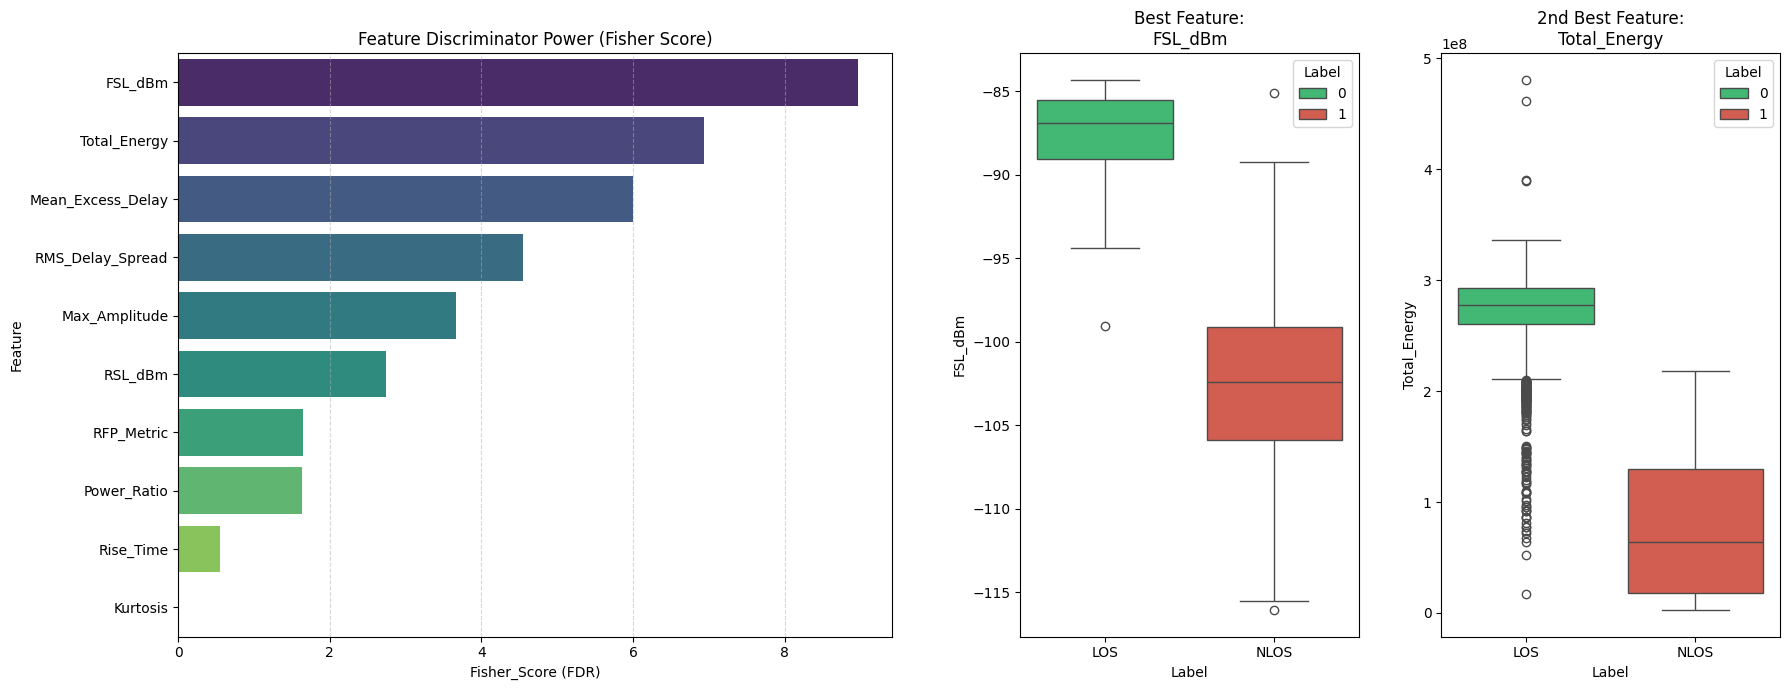

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from sklearn.metrics import roc_auc_score

# ==========================================
# 1. SETUP & LOAD DATA
# ==========================================
filepath = os.path.join(CHANNEL_DIR, "combined_uwb_dataset.csv")
A = 121.74  # PRF 64 MHz constant for DW1000

try:
    df = pd.read_csv(filepath)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {filepath}")
    df = pd.DataFrame() 

cir_cols = sorted([c for c in df.columns if c.startswith('CIR')], key=lambda x: int(x.replace('CIR', '')))

# ==========================================
# 2. FEATURE EXTRACTION
# ==========================================
data = []

if not df.empty:
    for idx, row in df.iterrows():
        # Get Preamble Accumulation Count (N)
        if 'RXPACC' in row: N = float(row['RXPACC'])
        elif 'RXP_ACC' in row: N = float(row['RXP_ACC'])
        else: N = 128.0 
            
        sig = pd.to_numeric(row[cir_cols], errors='coerce').fillna(0).astype(float).values
        if len(sig) == 0: continue
        
        peak_idx = np.argmax(sig)
        peak_val = sig[peak_idx]
        
        try:
            hw_fp_index = float(row['FP_INDEX']) / 64.0
        except (KeyError, ValueError):
            hw_fp_index = peak_idx 
        
        # --- DELAY SPREAD CALCULATIONS ---
        pdp = sig[int(hw_fp_index):]**2
        total_pdp_pwr = np.sum(pdp) + 1e-9
        times = np.arange(len(pdp))
        
        mean_excess_delay = np.sum(pdp * times) / total_pdp_pwr
        second_moment = np.sum(pdp * (times**2)) / total_pdp_pwr
        rms_delay_spread = np.sqrt(max(0, second_moment - (mean_excess_delay**2)))

        # Standard Features
        rise_time = peak_idx - hw_fp_index
        c_max = peak_val
        raw_energy = np.sum(sig**2)
        safe_energy = max(raw_energy, 1e-9)
        
        # Power Metrics
        rsl_dbm = 10 * np.log10(safe_energy / (N**2)) - A
        fp_int_idx = int(hw_fp_index)
        fp_energy_val = np.sum(sig[max(0, fp_int_idx - 1):min(len(sig), fp_int_idx + 2)]**2)
        safe_fp_energy = max(fp_energy_val, 1e-9)
        fsl_dbm = 10 * np.log10(safe_fp_energy / (N**2)) - A
        
        rfp = rsl_dbm - fsl_dbm
        c_power_ratio = safe_fp_energy / safe_energy
        
        # Kurtosis
        window = sig[max(0, peak_idx - 10):min(len(sig), peak_idx + 30)]
        c_kurt = kurtosis(window) if len(window) > 5 else 0
            
        data.append({
            "Max_Amplitude": c_max,
            "Total_Energy": raw_energy,
            "RSL_dBm": rsl_dbm,
            "FSL_dBm": fsl_dbm,
            "RFP_Metric": rfp,
            "Power_Ratio": c_power_ratio,
            "Kurtosis": c_kurt,
            "Rise_Time": rise_time,
            "Mean_Excess_Delay": mean_excess_delay,
            "RMS_Delay_Spread": rms_delay_spread,
            "Label": row['Label']
        })

    df_features = pd.DataFrame(data)

    # ==========================================
    # 3. FEATURE DISCRIMINATOR ANALYSIS
    # ==========================================
    feature_list = [
        "RFP_Metric", "Power_Ratio", "Kurtosis", 
        "Rise_Time", "RSL_dBm", "FSL_dBm", 
        "Total_Energy", "Max_Amplitude",
        "Mean_Excess_Delay", "RMS_Delay_Spread"
    ]
    
    discriminator_data = []
    los_data = df_features[df_features['Label'] == 0]
    nlos_data = df_features[df_features['Label'] == 1]
    
    for feat in feature_list:
        corr = df_features[feat].corr(df_features['Label'])
        mu0, mu1 = los_data[feat].mean(), nlos_data[feat].mean()
        var0, var1 = los_data[feat].var(), nlos_data[feat].var()
        fisher_score = ((mu0 - mu1)**2) / (var0 + var1 + 1e-9)
        try:
            auc = roc_auc_score(df_features['Label'], df_features[feat])
            auc = max(auc, 1 - auc) 
        except:
            auc = 0.5

        discriminator_data.append({
            "Feature": feat,
            "Fisher_Score (FDR)": fisher_score,
            "ROC_AUC": auc,
            "Correlation": corr
        })
    
    df_power = pd.DataFrame(discriminator_data).sort_values(by="Fisher_Score (FDR)", ascending=False)

    print("\nFEATURE DISCRIMINATOR POWER TABLE")
    print("=" * 85)
    print(f"{'Feature':<20} | {'Fisher (FDR)':<12} | {'ROC AUC':<10} | {'Correlation':<12}")
    print("-" * 85)
    for _, row in df_power.iterrows():
        print(f"{row['Feature']:<20} | {row['Fisher_Score (FDR)']:<12.4f} | {row['ROC_AUC']:<10.4f} | {row['Correlation']:<12.4f}")
    print("=" * 85)

    # ==========================================
    # 4. VISUALIZATION
    # ==========================================
    plt.figure(figsize=(18, 7))
    plt.subplot(1, 2, 1)
    sns.barplot(x="Fisher_Score (FDR)", y="Feature", data=df_power, hue="Feature", palette="viridis")
    plt.title("Feature Discriminator Power (Fisher Score)")
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    top_2_features = df_power['Feature'].head(2).values
    plt.subplot(1, 4, 3) 
    sns.boxplot(x='Label', y=top_2_features[0], data=df_features, hue='Label', palette=['#2ecc71', '#e74c3c'])
    plt.title(f"Best Feature:\n{top_2_features[0]}")
    plt.xticks([0, 1], ['LOS', 'NLOS'])
    
    plt.subplot(1, 4, 4)
    sns.boxplot(x='Label', y=top_2_features[1], data=df_features, hue='Label', palette=['#2ecc71', '#e74c3c'])
    plt.title(f"2nd Best Feature:\n{top_2_features[1]}")
    plt.xticks([0, 1], ['LOS', 'NLOS'])

    plt.tight_layout()
    plt.show()

- Metric,LOS (4.55m),NLOS (7.79m),LNN Conclusion
- MaxAmp,High (>5000),Low (~800-1300),Blockage is present.
- Rise_ns,Fast (~3-5ns),Slow (~6-9ns),Leading edge is obstructed.
- Width,Narrow (~3-5),Broad (~8-21),Signal is reflecting/scattering.
- MED,Low (<9),High (>14),Energy is delayed by geometry.